# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM
* Just comment out the plots when running if not needing to regenerate them

# Misc / setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing
import seaborn as sns
import gc

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

In [2]:
import random
SEED = 1337
random.seed(SEED)

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [4]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

meter_id  meter_id_0  meter_id_1  \
0       0x240e5e22734a44a174b7dabcf1ea00d70d9ec168           0           0   
1       0x2ce3d582a1316db5bcfe405cbd6070268944778e           0           0   
2       0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471           0           0   
3       0x391e6c2169c27de797ccbdf2d623365da28a6d3d           0           0   
4       0x423fa805ddb0cba9bdb4460f9a78540287eefd0e           0           0   
...                                            ...         ...         ...   
617640  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617641  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617642  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617643  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617644  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

        meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
617640           1           0           0           1           0   
617641           1           0           0           1           0   
617642           1           0           0           1           0   
617643           1           0           0           1           0   
617644           1           0           0           1           0   

        meter_id_7  meter_id_8  ...  semi_detached  terraced  energy n-7  \
0                0           0  ...            1.0       0.0   11.805677   
1                0           0  ...            1.0       0.0   11.805677   
2                0           0  ...            1.0       0.0   11.805677   
3                0           0  ...            1.0       0.0   11.805677   
4                0           0  ...            1.0       0.0   11.805677   
...            ...         ...  ...            ...       ...         ...   
617640           1           1  ...            0.0       0.0   21.999000   
617641           1           1  ...            0.0       0.0   26.232000   
617642           1           1  ...            0.0       0.0   14.036000   
617643           1           1  ...            0.0       0.0   15.990000   
617644           1           1  ...            0.0       0.0   15.550500   

        energy n-6 energy n-5  energy n-4  energy n-3  energy n-2  energy n-1  \
0        11.942665  11.552484   12.231637   12.903379   12.511848   12.101536   
1        11.942665  11.552484   12.231637   12.903379   12.511848   12.101536   
2        11.942665  11.552484   12.231637   12.903379   12.511848   12.101536   
3        11.942665  11.552484   12.231637   12.903379   12.511848   12.101536   
4        11.942665  11.552484   12.231637   12.903379   12.511848   12.101536   
...            ...        ...         ...         ...         ...         ...   
617640   26.232000  14.036000   15.990000   15.550500   15.111000   16.506000   
617641   14.036000  15.990000   15.550500   15.111000   16.506000   18.758500   
617642   15.990000  15.550500   15.111000   16.506000   18.758500   21.011000   
617643   15.550500  15.111000   16.506000   18.758500   21.011000   19.204000   
617644   15.111000  16.506000   18.758500   21.011000   19.204000   17.397000   

        meter_reading  
0           11.881495  
1           11.881495  
2           11.881495  
3           11.881495  
4           11.881495  
...               ...  
617640      18.758500  
617641      21.011000  
617642      19.204000  
617643      17.397000  
617644      15.237000  

[617645 rows x 38 columns]

meter_id  meter_id_0  meter_id_1  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
...                                             ...         ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

         meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           0           0           1           0   
1185516           1           0           0           1           0   
1185517           1           0           0           1           0   
1185518           1           0           0           1           0   
1185519           1           0           0           1           0   

         meter_id_7  meter_id_8  ...  semi_detached  terraced  energy n-7  \
0                 0           0  ...            0.0       1.0         NaN   
1                 0           0  ...            0.0       1.0         NaN   
2                 0           0  ...            0.0       1.0         NaN   
3                 0           0  ...            0.0       1.0         NaN   
4                 0           0  ...            0.0       1.0         NaN   
...             ...         ...  ...            ...       ...         ...   
1185515           1           1  ...            0.0       0.0         NaN   
1185516           1           1  ...            0.0       0.0         NaN   
1185517           1           1  ...            0.0       0.0         NaN   
1185518           1           1  ...            0.0       0.0         NaN   
1185519           1           1  ...            0.0       0.0         NaN   

         energy n-6 energy n-5  energy n-4  energy n-3  energy n-2  \
0               NaN        NaN         NaN         NaN         NaN   
1               NaN        NaN         NaN         NaN         NaN   
2               NaN        NaN         NaN         NaN         NaN   
3               NaN        NaN         NaN         NaN         NaN   
4               NaN        NaN         NaN         NaN         NaN   
...             ...        ...         ...         ...         ...   
1185515         NaN        NaN         NaN         NaN         NaN   
1185516         NaN        NaN         NaN         NaN         NaN   
1185517         NaN        NaN         NaN         NaN         NaN   
1185518         NaN        NaN         NaN         NaN         NaN   
1185519         NaN        NaN         NaN         NaN         NaN   

         energy n-1  meter_reading  
0               NaN            NaN  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4               NaN            NaN  
...             ...            ...  
1185515         NaN            NaN  
1185516         NaN            NaN  
1185517         NaN            NaN  
1185518         NaN            NaN  
1185519         NaN            NaN  

[1185520 rows x 38 columns]

# formatting the df's

In [5]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

meter_id  meter_id_0  meter_id_1  \
0       0x240e5e22734a44a174b7dabcf1ea00d70d9ec168           0           0   
1       0x2ce3d582a1316db5bcfe405cbd6070268944778e           0           0   
2       0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471           0           0   
3       0x391e6c2169c27de797ccbdf2d623365da28a6d3d           0           0   
4       0x423fa805ddb0cba9bdb4460f9a78540287eefd0e           0           0   
...                                            ...         ...         ...   
617640  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617641  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617642  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617643  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
617644  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

        meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
617640           1           0           0           1           0   
617641           1           0           0           1           0   
617642           1           0           0           1           0   
617643           1           0           0           1           0   
617644           1           0           0           1           0   

        meter_id_7  meter_id_8  ...  month_cos  is_weekend  energy_cluster  \
0                0           0  ...   0.841254           1               0   
1                0           0  ...   0.841254           1               0   
2                0           0  ...   0.841254           1               0   
3                0           0  ...   0.841254           1               0   
4                0           0  ...   0.841254           1               0   
...            ...         ...  ...        ...         ...             ...   
617640           1           1  ...   0.841254           0               1   
617641           1           1  ...   0.841254           0               1   
617642           1           1  ...   0.841254           0               1   
617643           1           1  ...   0.841254           1               1   
617644           1           1  ...   0.841254           1               1   

        num_bedrooms        dwelling_type  detached  flat  semi_detached  \
0                3.0  semi_detached_house       0.0   0.0            1.0   
1                3.0  semi_detached_house       0.0   0.0            1.0   
2                3.0  semi_detached_house       0.0   0.0            1.0   
3                3.0  semi_detached_house       0.0   0.0            1.0   
4                3.0  semi_detached_house       0.0   0.0            1.0   
...              ...                  ...       ...   ...            ...   
617640           3.0       detached_house       1.0   0.0            0.0   
617641           3.0       detached_house       1.0   0.0            0.0   
617642           3.0       detached_house       1.0   0.0            0.0   
617643           3.0       detached_house       1.0   0.0            0.0   
617644           3.0       detached_house       1.0   0.0            0.0   

        terraced  meter_reading  
0            0.0      11.881495  
1            0.0      11.881495  
2            0.0      11.881495  
3            0.0      11.881495  
4            0.0      11.881495  
...          ...            ...  
617640       0.0      18.758500  
617641       0.0      21.011000  
617642       0.0      19.204000  
617643       0.0      17.397000  
617644       0.0      15.237000  

[6176

meter_id  meter_id_0  meter_id_1  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
...                                             ...         ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

         meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           0           0           1           0   
1185516           1           0           0           1           0   
1185517           1           0           0           1           0   
1185518           1           0           0           1           0   
1185519           1           0           0           1           0   

         meter_id_7  meter_id_8  ...  month_cos  is_weekend  energy_cluster  \
0                 0           0  ...   0.841254           0               0   
1                 0           0  ...   0.841254           0               0   
2                 0           0  ...   0.841254           0               0   
3                 0           0  ...   0.841254           0               0   
4                 0           0  ...   0.841254           0               0   
...             ...         ...  ...        ...         ...             ...   
1185515           1           1  ...   0.841254           0               1   
1185516           1           1  ...   0.841254           0               1   
1185517           1           1  ...   0.841254           1               1   
1185518           1           1  ...   0.841254           1               1   
1185519           1           1  ...   0.841254           0               1   

         num_bedrooms   dwelling_type  detached  flat  semi_detached  \
0                 2.0  terraced_house       0.0   0.0            0.0   
1                 2.0  terraced_house       0.0   0.0            0.0   
2                 2.0  terraced_house       0.0   0.0            0.0   
3                 2.0  terraced_house       0.0   0.0            0.0   
4                 2.0  terraced_house       0.0   0.0            0.0   
...               ...             ...       ...   ...            ...   
1185515           3.0  detached_house       1.0   0.0            0.0   
1185516           3.0  detached_house       1.0   0.0            0.0   
1185517           3.0  detached_house       1.0   0.0            0.0   
1185518           3.0  detached_house       1.0   0.0            0.0   
1185519           3.0  detached_house       1.0   0.0            0.0   

         terraced  meter_reading  
0             1.0              0  
1             1.0              0  
2             1.0              0  
3             1.0              0  
4             1.0              0  
...           ...            ...  
1185515       0.0              0  
1185516       0.0              0  
1185517       0.0              0  
1185518       0.0              0  
1185519       0.0              0  

[11855

# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [6]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_train["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

meter_id  meter_id_ord  meter_id_0  \
0       0x240e5e22734a44a174b7dabcf1ea00d70d9ec168           425           0   
1       0x2ce3d582a1316db5bcfe405cbd6070268944778e           542           0   
2       0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471           585           0   
3       0x391e6c2169c27de797ccbdf2d623365da28a6d3d           688           0   
4       0x423fa805ddb0cba9bdb4460f9a78540287eefd0e           793           0   
...                                            ...           ...         ...   
617640  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617641  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617642  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617643  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617644  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

        meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
617640           1           1           0           0           1   
617641           1           1           0           0           1   
617642           1           1           0           0           1   
617643           1           1           0           0           1   
617644           1           1           0           0           1   

        meter_id_6  meter_id_7  ...  month_cos  is_weekend  energy_cluster  \
0                0           0  ...   0.841254           1               0   
1                0           0  ...   0.841254           1               0   
2                0           0  ...   0.841254           1               0   
3                0           0  ...   0.841254           1               0   
4                0           0  ...   0.841254           1               0   
...            ...         ...  ...        ...         ...             ...   
617640           0           1  ...   0.841254           0               1   
617641           0           1  ...   0.841254           0               1   
617642           0           1  ...   0.841254           0               1   
617643           0           1  ...   0.841254           1               1   
617644           0           1  ...   0.841254           1               1   

        num_bedrooms        dwelling_type detached  flat  semi_detached  \
0                3.0  semi_detached_house      0.0   0.0            1.0   
1                3.0  semi_detached_house      0.0   0.0            1.0   
2                3.0  semi_detached_house      0.0   0.0            1.0   
3                3.0  semi_detached_house      0.0   0.0            1.0   
4                3.0  semi_detached_house      0.0   0.0            1.0   
...              ...                  ...      ...   ...            ...   
617640           3.0       detached_house      1.0   0.0            0.0   
617641           3.0       detached_house      1.0   0.0            0.0   
617642           3.0       detached_house      1.0   0.0            0.0   
617643           3.0       detached_house      1.0   0.0            0.0   
617644           3.0       detached_house      1.0   0.0            0.0   

        terraced  meter_reading  
0            0.0      11.881495  
1            0.0      11.881495  
2            0.0      11.881495  
3            0.0      11.881495  
4            0.0      11.881495  
...          ...            ...  
617640       0.0      18.758500  
617641       0.0      21.011000  
617642       0.0      19.204000  
617643       0.0      17.397000  
617644       0.0      15.237

meter_id  meter_id_ord  meter_id_0  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
...                                             ...           ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

         meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           1           0           0           1   
1185516           1           1           0           0           1   
1185517           1           1           0           0           1   
1185518           1           1           0           0           1   
1185519           1           1           0           0           1   

         meter_id_6  meter_id_7  ...  month_cos  is_weekend  energy_cluster  \
0                 0           0  ...   0.841254           0               0   
1                 0           0  ...   0.841254           0               0   
2                 0           0  ...   0.841254           0               0   
3                 0           0  ...   0.841254           0               0   
4                 0           0  ...   0.841254           0               0   
...             ...         ...  ...        ...         ...             ...   
1185515           0           1  ...   0.841254           0               1   
1185516           0           1  ...   0.841254           0               1   
1185517           0           1  ...   0.841254           1               1   
1185518           0           1  ...   0.841254           1               1   
1185519           0           1  ...   0.841254           0               1   

         num_bedrooms   dwelling_type detached  flat  semi_detached  terraced  \
0                 2.0  terraced_house      0.0   0.0            0.0       1.0   
1                 2.0  terraced_house      0.0   0.0            0.0       1.0   
2                 2.0  terraced_house      0.0   0.0            0.0       1.0   
3                 2.0  terraced_house      0.0   0.0            0.0       1.0   
4                 2.0  terraced_house      0.0   0.0            0.0       1.0   
...               ...             ...      ...   ...            ...       ...   
1185515           3.0  detached_house      1.0   0.0            0.0       0.0   
1185516           3.0  detached_house      1.0   0.0            0.0       0.0   
1185517           3.0  detached_house      1.0   0.0            0.0       0.0   
1185518           3.0  detached_house      1.0   0.0            0.0       0.0   
1185519           3.0  detached_house      1.0   0.0            0.0       0.0   

         meter_reading  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1185515              0  
1185516              0  
1185517              0  
1185518              0  
1185519             

# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [7]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_train["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

meter_id  meter_id_ord  meter_id_0  \
0       0x240e5e22734a44a174b7dabcf1ea00d70d9ec168           425           0   
1       0x2ce3d582a1316db5bcfe405cbd6070268944778e           542           0   
2       0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471           585           0   
3       0x391e6c2169c27de797ccbdf2d623365da28a6d3d           688           0   
4       0x423fa805ddb0cba9bdb4460f9a78540287eefd0e           793           0   
...                                            ...           ...         ...   
617640  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617641  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617642  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617643  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
617644  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

        meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
617640           1           1           0           0           1   
617641           1           1           0           0           1   
617642           1           1           0           0           1   
617643           1           1           0           0           1   
617644           1           1           0           0           1   

        meter_id_6  meter_id_7  ...  is_weekend  energy_cluster  num_bedrooms  \
0                0           0  ...           1               0           3.0   
1                0           0  ...           1               0           3.0   
2                0           0  ...           1               0           3.0   
3                0           0  ...           1               0           3.0   
4                0           0  ...           1               0           3.0   
...            ...         ...  ...         ...             ...           ...   
617640           0           1  ...           0               1           3.0   
617641           0           1  ...           0               1           3.0   
617642           0           1  ...           0               1           3.0   
617643           0           1  ...           1               1           3.0   
617644           0           1  ...           1               1           3.0   

              dwelling_type  dwelling_type_ord detached  flat  semi_detached  \
0       semi_detached_house                  3      0.0   0.0            1.0   
1       semi_detached_house                  3      0.0   0.0            1.0   
2       semi_detached_house                  3      0.0   0.0            1.0   
3       semi_detached_house                  3      0.0   0.0            1.0   
4       semi_detached_house                  3      0.0   0.0            1.0   
...                     ...                ...      ...   ...            ...   
617640       detached_house                  1      1.0   0.0            0.0   
617641       detached_house                  1      1.0   0.0            0.0   
617642       detached_house                  1      1.0   0.0            0.0   
617643       detached_house                  1      1.0   0.0            0.0   
617644       detached_house                  1      1.0   0.0            0.0   

        terraced  meter_reading  
0            0.0      11.881495  
1            0.0      11.881495  
2            0.0      11.881495  
3            0.0      11.881495  
4            0.0      11.881495  
...          ...            ...  
617640       0.0      18.758500  
617641       0.0      21.011000  


meter_id  meter_id_ord  meter_id_0  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
...                                             ...           ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

         meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           1           0           0           1   
1185516           1           1           0           0           1   
1185517           1           1           0           0           1   
1185518           1           1           0           0           1   
1185519           1           1           0           0           1   

         meter_id_6  meter_id_7  ...  is_weekend  energy_cluster  \
0                 0           0  ...           0               0   
1                 0           0  ...           0               0   
2                 0           0  ...           0               0   
3                 0           0  ...           0               0   
4                 0           0  ...           0               0   
...             ...         ...  ...         ...             ...   
1185515           0           1  ...           0               1   
1185516           0           1  ...           0               1   
1185517           0           1  ...           1               1   
1185518           0           1  ...           1               1   
1185519           0           1  ...           0               1   

         num_bedrooms   dwelling_type  dwelling_type_ord detached  flat  \
0                 2.0  terraced_house                  4      0.0   0.0   
1                 2.0  terraced_house                  4      0.0   0.0   
2                 2.0  terraced_house                  4      0.0   0.0   
3                 2.0  terraced_house                  4      0.0   0.0   
4                 2.0  terraced_house                  4      0.0   0.0   
...               ...             ...                ...      ...   ...   
1185515           3.0  detached_house                  1      1.0   0.0   
1185516           3.0  detached_house                  1      1.0   0.0   
1185517           3.0  detached_house                  1      1.0   0.0   
1185518           3.0  detached_house                  1      1.0   0.0   
1185519           3.0  detached_house                  1      1.0   0.0   

         semi_detached  terraced  meter_reading  
0                  0.0       1.0              0  
1                  0.0       1.0              0  
2                  0.0       1.0              0  
3                  0.0       1.0              0  
4                  0.0       1.0              0  
...                ...       ...            ...  
1185515            0.0       0.0              0  
1185516            0.0       0.0              0  
1185517            0.0       0.0              0  

# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* firefly algorithm hyper parameter tuning will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [8]:
# REFERENCE the lgbm used inside this function has taken inspiration from the proposed model in the work of Wenlong Wu's : "Solution to the IEEE-CIS Second Technical Challenge with Machine Learning Modeling"

import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=3333,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(time_of_execution)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {valid_score}\n")
    
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running FA hyper param optim on the LGBM skf-cv function


In [9]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped

In [10]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [11]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for GA
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in GA

In [12]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params
    
    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 1337}


In [13]:
#array of names of keys for the params we tune in the dic ; will be used in mutation of GA
tuned_hyper_names = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
whole_number_hyper_names = ["num_leaves","max_depth","bagging_freq","lambda_l1","lambda_l2"]
fractional_hyper_names = ["bagging_fraction","feature_fraction"]

## Running the Firefly Hyper Param Optimization
### creating the initial population

In [14]:
population_size = 12

In [15]:
population = []
# loading the description of the best model from RS and the RS main effects to be used as 2 of the original population
rs_best_model = pd.read_pickle("../Results/Unclustered Random Search/128_best_model_desc.pkl")
rs_best_model_features = rs_best_model["features"]
rs_best_model_col_groups = []
for key in possible_columns.keys():
    if(possible_columns[key][0] in rs_best_model_features):
        rs_best_model_col_groups+=[key]
population.append((rs_best_model_features,rs_best_model["params"], rs_best_model_col_groups))

rs_main_effects_model = pd.read_pickle("../Results/Unclustered Random Search/128_main_effects_desc.pkl")
rs_main_effects_features = rs_main_effects_model["features"]
rs_main_effects_col_groups = []
for key in possible_columns.keys():
    if(possible_columns[key][0] in rs_main_effects_features):
        rs_main_effects_col_groups+=[key]
population.append((rs_main_effects_features,rs_best_model["params"], rs_main_effects_col_groups))

#filling the rest of the population with random models
while (len(population)<population_size):
    #firstly randomly picking the features we will use
    X_cols = []#this will store the X_cols we use
    X_col_groups = []
    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<=prob_to_beat):
            X_col_groups+=[key]
            X_cols+=possible_columns[key]

    #then get LGBM hyper parameters
    this_params = params.copy()
    this_params["learning_rate"] = random.randrange(10,100)/1000 #between 0.01 and 0.1
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*1)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 100%)
    this_params["bagging_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["lambda_l1"] = random.randrange(4,20)
    this_params["lambda_l2"] = random.randrange(4,20)
    
    #adding this random model to the initial population
    population.append((X_cols,this_params,X_col_groups))
    
#viewing the initial population
print(f"{color.BOLD}The initial population is{color.END}\n")
for i in range(len(population)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}population member {i}{color.END}")
    print(f"{color.BOLD}features{color.END}\n",population[i][0])
    print(f"{color.BOLD}feature groups{color.END}\n",population[i][2])
    print(f"{color.BOLD}labels{color.END}")
    pprint(population[i][1])
    print()

The initial population is

population member 0
features
 ['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
feature groups
 ['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
labels
{'bagging_fraction': 0.98,
 'bagging_freq': 16,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.56,
 'lambda_l1': 17,
 'lambda_l2': 16,
 'learning_rate': 0.06,
 'max_depth': 11,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 1443,
 'num_threads': -1,
 'seed': 1337}

population member 1
features
 ['num_bedrooms']


### Running the firefly algorithm

* 12 fireflies * 20 iterations = 240 models

<b> this one doesn't store the lgbm model as my machine was running out of memory due to the GA being more complicated. Instead will just save the description and will have to retrain the best one with that description at the end of the algorithm </b>

Firefly Algorithm hyper parameter optimization



  0%|          | 0/20 [00:00<?, ?it/s]

Training the fireflies


  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 0, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.06, 'num_leaves': 1443, 'max_depth': 11, 'bagging_fraction': 0.98, 'bagging_freq': 16, 'feature_fraction': 0.56, 'lambda_l1': 17, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [War

Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.62, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.62
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.99373
MAE = 4.990623305637164, TOE = 0:00:06, Intensity = 0.040150450195050556

Iteration 0, Firefly 3
Feature groups
['day_of_week', 'day_of_month', 'month_cyclic', 'is_weekend', 'num_bedro

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.01113
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.53, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.00384
Fold 3
Training the LGBM
[LightGBM] [Warning] 

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.71, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.96622
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.71, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71
[LightGBM] [Warning] lambda_l1 is

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0087
MAE = 5.005687761290327, TOE = 0:00:09, Intensity = 0.0399091508671826

Iteration 0, Firefly 11
Feature groups
['is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.038, 'num_leaves': 1110, 'max_depth': 11, 'bagging_fraction': 0.95, 'bagging_freq': 19, 'feature_fraction': 0.79, 'lambda_l1': 16, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGB

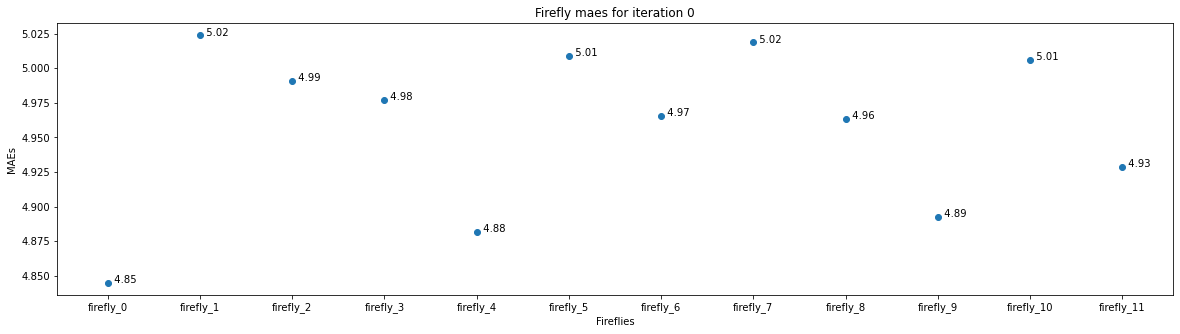


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0426, 0.0396, 0.0402, 0.0404, 0.042, 0.0399, 0.0406, 0.0397, 0.0406, 0.0418, 0.0399, 0.0412]

firefly_ranked_indexes
[0, 4, 9, 11, 8, 6, 3, 2, 10, 5, 7, 1]

firefly ranked intensities
[0.043, 0.042, 0.042, 0.041, 0.041, 0.041, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]

Moving the fireflies
Firefly_A = 0 MAE = 4.845213922417806 | Firefly_B = 4 MAE = 4.881970228838986 | B is better than A? False
Firefly_A = 0 MAE = 4.845213922417806 | Firefly_B = 9 MAE = 4.892342220100242 | B is better than A? False
Firefly_A = 0 MAE = 4.845213922417806 | Firefly_B = 11 MAE = 4.928910724018273 | B is better than A? False
Firefly_A = 0 MAE = 4.845213922417806 | Firefly_B = 8 MAE = 4.963578982597942 | B is better than A? False
Firefly_A = 0 MAE = 4.845213922417806 | Firefly_B = 6 MAE = 4.965204850444586 | B is better than A? False
Firefly_A = 0 MAE = 4.845213922417806 | Firefly_B = 3 MAE = 4.97705389490744 | B is better than 

Decided to keep using is_weekend as firefly 10 already uses it
Decided to stop using energy_cluster as firefly 10 doesn't already use it
Decided to keep using num_bedrooms as firefly 10 already uses it
Decided to keep using dwelling_type_ord as firefly 10 already uses it
Decided to stop using dwelling_type_onehot as firefly 10 doesn't already use it
Firefly_A = 10 MAE = 5.005687761290327 | Firefly_B = 5 MAE = 5.008989032620252 | B is better than A? False
Firefly_A = 10 MAE = 5.005687761290327 | Firefly_B = 7 MAE = 5.01862197706478 | B is better than A? False
Firefly_A = 10 MAE = 5.005687761290327 | Firefly_B = 1 MAE = 5.023660018752025 | B is better than A? False
Firefly_A = 5 MAE = 5.008989032620252 | Firefly_B = 0 MAE = 4.845213922417806 | B is better than A? True
Intensity difference between 5 and 0 is 0.005611654699699514
learning_rate has changed from 0.015 to 0.015252524461486477 taking a step of size 1
num_leaves has changed from 403 to 408.8361208876875 taking a step of size 1


  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 1, Firefly 0
Feature groups
['day_of_year_cyclic']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.06, 'num_leaves': 1530, 'max_depth': 11, 'bagging_fraction': 0.8918, 'bagging_freq': 16, 'feature_fraction': 0.56, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8918
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03015
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6206339653072188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6206339653072188
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8906544488735687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8906544488735687
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03758
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5315920951668069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315920951668069
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.9689218572333171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9689218572333171
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03609
MAE = 5.033046610733622, TOE = 0:00:06, Intensity = 0.03947645038906003

Iteration 1, Firefly 8
Feature groups
['month_cyclic']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03936923230348939, 'num_leaves': 305, 'max_depth': 9, 'bagging_fraction': 0.7904624138879911, 'bagging_freq': 5, 'feature_fraction': 0.7595702259525469, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7595702259525469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7595702259525469
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7904624138879911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790462413

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03016
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5910095964380351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5910095964380351
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6815632704359373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6815632704359373
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

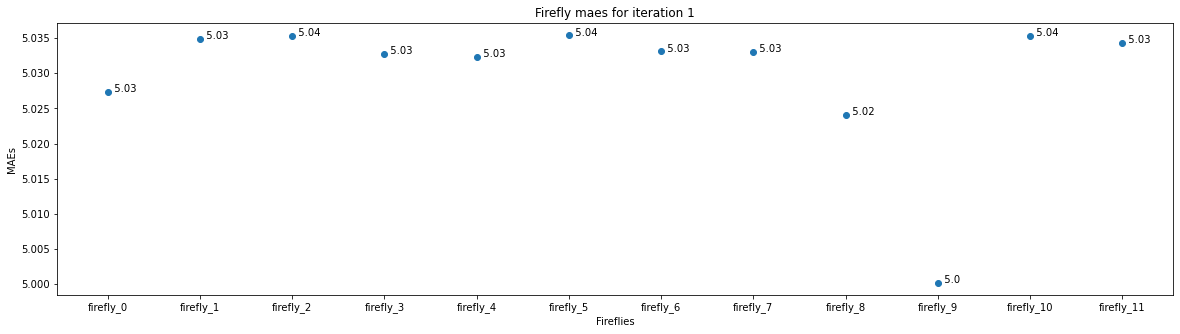


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0396, 0.0394, 0.0394, 0.0395, 0.0395, 0.0394, 0.0395, 0.0395, 0.0396, 0.04, 0.0394, 0.0395]

firefly_ranked_indexes
[9, 8, 0, 4, 3, 7, 6, 11, 1, 2, 10, 5]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 9 MAE = 5.000223092330791 | Firefly_B = 8 MAE = 5.024019928112655 | B is better than A? False
Firefly_A = 9 MAE = 5.000223092330791 | Firefly_B = 0 MAE = 5.02740613324134 | B is better than A? False
Firefly_A = 9 MAE = 5.000223092330791 | Firefly_B = 4 MAE = 5.032380878477009 | B is better than A? False
Firefly_A = 9 MAE = 5.000223092330791 | Firefly_B = 3 MAE = 5.032775651030903 | B is better than A? False
Firefly_A = 9 MAE = 5.000223092330791 | Firefly_B = 7 MAE = 5.033046610733622 | B is better than A? False
Firefly_A = 9 MAE = 5.000223092330791 | Firefly_B = 6 MAE = 5.033108165132404 | B is better than

Decided to stop using meter_id_binary as firefly 0 doesn't use it
Decided to stop using day_of_year_cyclic as firefly 10 doesn't already use it
Decided to stop using day_of_week as firefly 0 doesn't use it
Decided to stop using day_of_month as firefly 10 doesn't already use it
Decided to stop using month_ord as firefly 0 doesn't use it
Decided to stop using month_cyclic as firefly 0 doesn't use it
Decided to stop using is_weekend as firefly 10 doesn't already use it
Decided to stop using energy_cluster as firefly 10 doesn't already use it
Decided to stop using num_bedrooms as firefly 10 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 0 doesn't use it
Decided to stop using dwelling_type_onehot as firefly 10 doesn't already use it
Firefly_A = 10 MAE = 5.035361806717837 | Firefly_B = 4 MAE = 5.032380878477009 | B is better than A? True
Intensity difference between 10 and 4 is 9.853712033575102e-05
learning_rate has changed from 0.0155817815613871 to 0.01558258698

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 2, Firefly 0
Feature groups
['day_of_month']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.06003579128467161, 'num_leaves': 1529, 'max_depth': 11, 'bagging_fraction': 0.8914660047956662, 'bagging_freq': 16, 'feature_fraction': 0.5603652761582472, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5603652761582472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5603652761582472
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8914660047956662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8914660047956662
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambd

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02578
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.621045436643684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.621045436643684
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8011888184512648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8011888184512648
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03819
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5800251226353633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5800251226353633
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.9683632116125499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683632116125499
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03834
MAE = 5.035343316010505, TOE = 0:00:05, Intensity = 0.039440446848035646

Iteration 2, Firefly 8
Feature groups
['day_of_week', 'month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.039418056332250456, 'num_leaves': 332, 'max_depth': 9, 'bagging_fraction': 0.7902554651573389, 'bagging_freq': 5, 'feature_fraction': 0.7597214631930514, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7597214631930514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597214631930514
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7902554651573389, subsample=1.0 will be ignored. Current value: bagging_fracti

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02885
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5914642047987899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5914642047987899
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6814210662690653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814210662690653
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

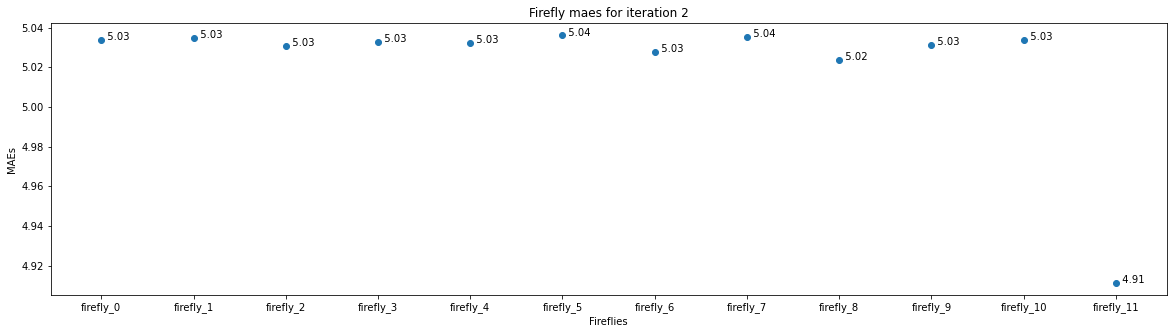


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0394, 0.0395, 0.0395, 0.0395, 0.0394, 0.0396, 0.0394, 0.0396, 0.0395, 0.0395, 0.0415]

firefly_ranked_indexes
[11, 8, 6, 2, 9, 4, 3, 0, 10, 1, 7, 5]

firefly ranked intensities
[0.041, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 11 MAE = 4.911579919862021 | Firefly_B = 8 MAE = 5.023673607524079 | B is better than A? False
Firefly_A = 11 MAE = 4.911579919862021 | Firefly_B = 6 MAE = 5.0276702337333985 | B is better than A? False
Firefly_A = 11 MAE = 4.911579919862021 | Firefly_B = 2 MAE = 5.030932219990534 | B is better than A? False
Firefly_A = 11 MAE = 4.911579919862021 | Firefly_B = 9 MAE = 5.031443553647288 | B is better than A? False
Firefly_A = 11 MAE = 4.911579919862021 | Firefly_B = 4 MAE = 5.03238662126069 | B is better than A? False
Firefly_A = 11 MAE = 4.911579919862021 | Firefly_B = 3 MAE = 5.0327744612393355 | B is be

max_depth has changed from 7 to 7.000385503902378 taking a step of size 0.5
bagging_fraction has changed from 0.9091606067200406 to 0.9091376875219981 taking a step of size 0.5
bagging_freq has changed from 18 to 17.997494224634544 taking a step of size 0.5
feature_fraction has changed from 0.6905151532271273 to 0.6905284928784079 taking a step of size 0.5
lambda_l1 has changed from 13 to 12.99845798439049 taking a step of size 0.5
lambda_l2 has changed from 16 to 15.999228992195246 taking a step of size 0.5
Decided to stop using meter_id_ord as firefly 7 doesn't already use it
Decided to stop using meter_id_binary as firefly 7 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 8 doesn't use it
Decided to start using day_of_week as firefly 8 uses it
Decided to stop using day_of_month as firefly 7 doesn't already use it
Decided to stop using month_ord as firefly 7 doesn't already use it
Decided to stop using month_cyclic as firefly 8 doesn't use it
Decided to sto

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 3, Firefly 0
Feature groups
['day_of_week']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.059946363632324855, 'num_leaves': 1527, 'max_depth': 11, 'bagging_fraction': 0.8916852772943773, 'bagging_freq': 17, 'feature_fraction': 0.5610295810184831, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5610295810184831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610295810184831
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8916852772943773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8916852772943773
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambd

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02267
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6214276655463643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6214276655463643
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.801793258063914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.801793258063914
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.99363
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5806243255659297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5806243255659297
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.9682279031085607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9682279031085607
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.99528
MAE = 4.99225556643068, TOE = 0:00:05, Intensity = 0.04012419941880571

Iteration 3, Firefly 8
Feature groups
['month_cyclic']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03941772805909184, 'num_leaves': 335, 'max_depth': 9, 'bagging_fraction': 0.7908664872476279, 'bagging_freq': 5, 'feature_fraction': 0.7595330341961357, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7595330341961357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7595330341961357
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7908664872476279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7908664872

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03021
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5919943313431721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5919943313431721
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6825682774059741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6825682774059741
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

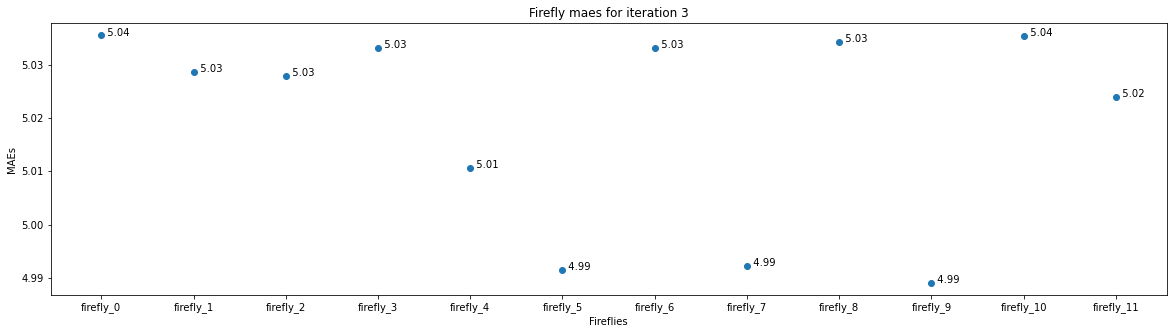


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0394, 0.0395, 0.0396, 0.0395, 0.0398, 0.0401, 0.0395, 0.0401, 0.0395, 0.0402, 0.0394, 0.0396]

firefly_ranked_indexes
[9, 5, 7, 4, 11, 2, 1, 3, 6, 8, 10, 0]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 9 MAE = 4.989154656669657 | Firefly_B = 5 MAE = 4.991448488831983 | B is better than A? False
Firefly_A = 9 MAE = 4.989154656669657 | Firefly_B = 7 MAE = 4.99225556643068 | B is better than A? False
Firefly_A = 9 MAE = 4.989154656669657 | Firefly_B = 4 MAE = 5.010555685461193 | B is better than A? False
Firefly_A = 9 MAE = 4.989154656669657 | Firefly_B = 11 MAE = 5.02400440655396 | B is better than A? False
Firefly_A = 9 MAE = 4.989154656669657 | Firefly_B = 2 MAE = 5.027879307831863 | B is better than A? False
Firefly_A = 9 MAE = 4.989154656669657 | Firefly_B = 1 MAE = 5.02869295677082 | B is better than A?

Decided to stop using is_weekend as firefly 9 doesn't use it
Decided to stop using energy_cluster as firefly 9 doesn't use it
Decided to stop using num_bedrooms as firefly 9 doesn't use it
Decided to stop using dwelling_type_ord as firefly 9 doesn't use it
Decided to stop using dwelling_type_onehot as firefly 9 doesn't use it
Firefly_A = 10 MAE = 5.035409070493347 | Firefly_B = 5 MAE = 4.991448488831983 | B is better than A? True
Intensity difference between 10 and 5 is 0.001465032048722989
learning_rate has changed from 0.014581164374921431 to 0.014582213184201824 taking a step of size 0.5
num_leaves has changed from 2043 to 2041.8059988802909 taking a step of size 0.5
max_depth has changed from 11 to 10.997802451926916 taking a step of size 0.5
bagging_fraction has changed from 0.6823368461468682 to 0.6825462659273143 taking a step of size 0.5
bagging_freq has changed from 5 to 5.003662580121808 taking a step of size 0.5
feature_fraction has changed from 0.5925439989093009 to 0.59253

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 4, Firefly 0
Feature groups
['num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05996180944360178, 'num_leaves': 1523, 'max_depth': 11, 'bagging_fraction': 0.8911695798080792, 'bagging_freq': 17, 'feature_fraction': 0.5617331226684804, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5617331226684804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5617331226684804
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8911695798080792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8911695798080792
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambd

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03011
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6529638502752003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6529638502752003
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8416477943728427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8416477943728427
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03318
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5400071285241012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5400071285241012
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.9681941329938534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9681941329938534
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03834
MAE = 5.03533818813413, TOE = 0:00:05, Intensity = 0.03944052717862359

Iteration 4, Firefly 8
Feature groups
['month_cyclic']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03948829592984206, 'num_leaves': 335, 'max_depth': 8, 'bagging_fraction': 0.7906360929362022, 'bagging_freq': 5, 'feature_fraction': 0.7596822437700347, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7596822437700347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596822437700347
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7906360929362022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906360929

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0302
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5926113998202692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926113998202692
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6826324887740016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826324887740016
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5

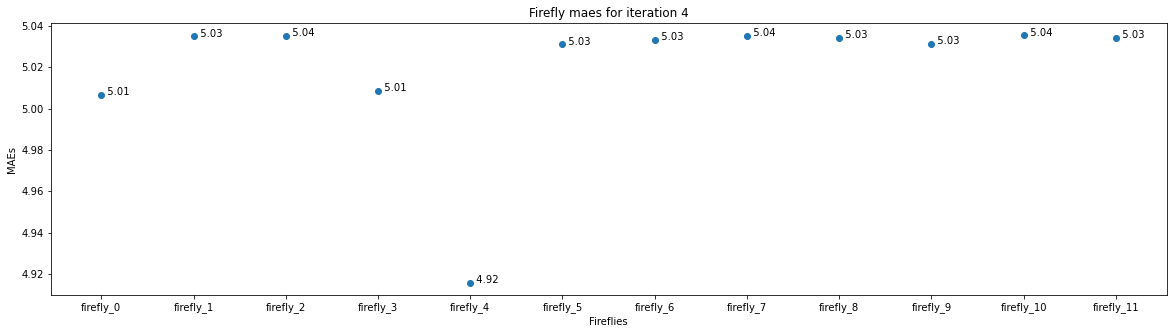


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0399, 0.0394, 0.0394, 0.0399, 0.0414, 0.0395, 0.0395, 0.0394, 0.0395, 0.0395, 0.0394, 0.0395]

firefly_ranked_indexes
[4, 0, 3, 5, 9, 6, 8, 11, 1, 2, 7, 10]

firefly ranked intensities
[0.041, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 4 MAE = 4.9158042118902125 | Firefly_B = 0 MAE = 5.006812692528973 | B is better than A? False
Firefly_A = 4 MAE = 4.9158042118902125 | Firefly_B = 3 MAE = 5.008515819650047 | B is better than A? False
Firefly_A = 4 MAE = 4.9158042118902125 | Firefly_B = 5 MAE = 5.031067446623856 | B is better than A? False
Firefly_A = 4 MAE = 4.9158042118902125 | Firefly_B = 9 MAE = 5.031467461387917 | B is better than A? False
Firefly_A = 4 MAE = 4.9158042118902125 | Firefly_B = 6 MAE = 5.0330785323752965 | B is better than A? False
Firefly_A = 4 MAE = 4.9158042118902125 | Firefly_B = 8 MAE = 5.034295228894085 | B is be

learning_rate has changed from 0.016531229664741784 to 0.016531241611269558 taking a step of size 0.015625
num_leaves has changed from 1056 to 1055.9996248019488 taking a step of size 0.015625
max_depth has changed from 11 to 10.999998438843061 taking a step of size 0.015625
bagging_fraction has changed from 0.8408913870867704 to 0.8408913609346366 taking a step of size 0.015625
bagging_freq has changed from 11 to 10.99999687768612 taking a step of size 0.015625
feature_fraction has changed from 0.6541143472026404 to 0.6541144021386585 taking a step of size 0.015625
lambda_l1 has changed from 7 to 6.999998959228707 taking a step of size 0.015625
lambda_l2 has changed from 12 to 12.0 taking a step of size 0.015625
Decided to keep using meter_id_ord as firefly 2 already uses it
Decided to stop using meter_id_binary as firefly 2 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 2 doesn't already use it
Decided to stop using day_of_week as firefly 2 doesn't already

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 5, Firefly 0
Feature groups
['meter_id_binary', 'day_of_month', 'month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05402430136210632, 'num_leaves': 1521, 'max_depth': 11, 'bagging_fraction': 0.8904509891696237, 'bagging_freq': 17, 'feature_fraction': 0.5629428636520369, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5629428636520369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5629428636520369
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8904509891696237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8904509891696237
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0301
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6541144318429228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6541144318429228
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8408913761664664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408913761664664
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1:

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03756
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5416350195792126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5416350195792126
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.9668944394560316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668944394560316
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03833
MAE = 5.035326558063351, TOE = 0:00:05, Intensity = 0.03944070937004538

Iteration 5, Firefly 8
Feature groups
['month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.038878354395296015, 'num_leaves': 338, 'max_depth': 8, 'bagging_fraction': 0.7901279019738591, 'bagging_freq': 5, 'feature_fraction': 0.7603200642755078, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7603200642755078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7603200642755078
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7901279019738591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79012790197

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03019
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5940525183653822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5940525183653822
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6826388935814612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826388935814612
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

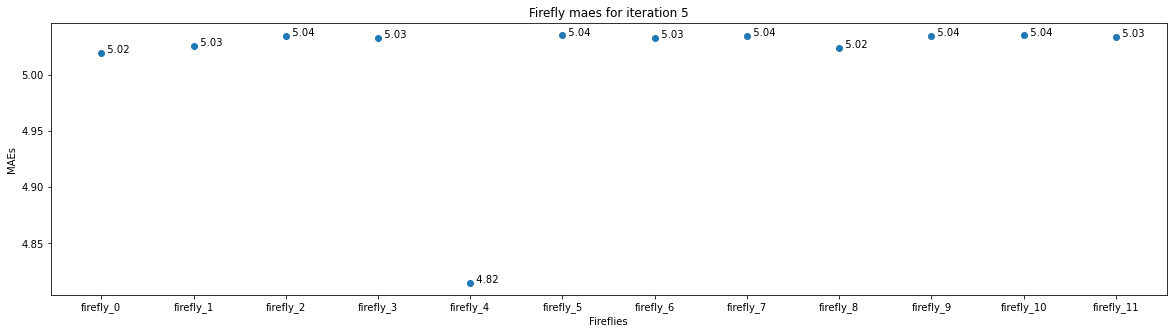


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0397, 0.0396, 0.0394, 0.0395, 0.0431, 0.0394, 0.0395, 0.0394, 0.0396, 0.0394, 0.0394, 0.0395]

firefly_ranked_indexes
[4, 0, 8, 1, 6, 3, 11, 9, 2, 7, 5, 10]

firefly ranked intensities
[0.043, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 4 MAE = 4.815153487535586 | Firefly_B = 0 MAE = 5.019858507095028 | B is better than A? False
Firefly_A = 4 MAE = 4.815153487535586 | Firefly_B = 8 MAE = 5.0241689900226065 | B is better than A? False
Firefly_A = 4 MAE = 4.815153487535586 | Firefly_B = 1 MAE = 5.02623936644549 | B is better than A? False
Firefly_A = 4 MAE = 4.815153487535586 | Firefly_B = 6 MAE = 5.032902563975423 | B is better than A? False
Firefly_A = 4 MAE = 4.815153487535586 | Firefly_B = 3 MAE = 5.033038214726094 | B is better than A? False
Firefly_A = 4 MAE = 4.815153487535586 | Firefly_B = 11 MAE = 5.034309315704436 | B is better 

Decided to stop using day_of_month as firefly 5 doesn't already use it
Decided to stop using month_ord as firefly 5 doesn't already use it
Decided to stop using month_cyclic as firefly 5 doesn't already use it
Decided to stop using is_weekend as firefly 5 doesn't already use it
Decided to keep using energy_cluster as firefly 5 already uses it
Decided to stop using num_bedrooms as firefly 5 doesn't already use it
Decided to keep using dwelling_type_ord as firefly 5 already uses it
Decided to stop using dwelling_type_onehot as firefly 5 doesn't already use it
Firefly_A = 5 MAE = 5.035360594949262 | Firefly_B = 3 MAE = 5.033038214726094 | B is better than A? True
Intensity difference between 5 and 3 is 7.622194417888917e-05
learning_rate has changed from 0.016813022532480678 to 0.01681315749908801 taking a step of size 0.03125
num_leaves has changed from 417 to 417.0030679332532 taking a step of size 0.03125
max_depth has changed from 8 to 8.000009527743023 taking a step of size 0.03125
b

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 6, Firefly 0
Feature groups
['num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05421741396461469, 'num_leaves': 1516, 'max_depth': 11, 'bagging_fraction': 0.8887997278024585, 'bagging_freq': 17, 'feature_fraction': 0.5651754473777061, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5651754473777061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651754473777061
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8887997278024585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8887997278024585
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambd

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03008
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6557972888474717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6557972888474717
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8395053028447955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8395053028447955
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03641
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5442311776781178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5442311776781178
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9644853903942128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9644853903942128
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0383
MAE = 5.035300002532757, TOE = 0:00:05, Intensity = 0.03944112538169341

Iteration 6, Firefly 8
Feature groups
['month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.039187767939037874, 'num_leaves': 341, 'max_depth': 9, 'bagging_fraction': 0.7891893202180245, 'bagging_freq': 5, 'feature_fraction': 0.7611305137068318, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7611305137068318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7611305137068318
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7891893202180245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789189320218

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03013
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6379592901405664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6379592901405664
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6825367514631143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6825367514631143
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

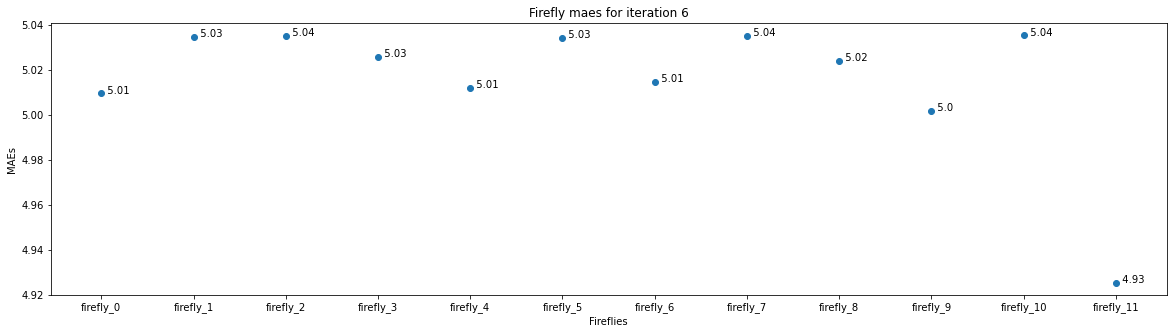


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0398, 0.0394, 0.0394, 0.0396, 0.0398, 0.0395, 0.0398, 0.0394, 0.0396, 0.04, 0.0394, 0.0412]

firefly_ranked_indexes
[11, 9, 0, 4, 6, 8, 3, 5, 1, 2, 7, 10]

firefly ranked intensities
[0.041, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 11 MAE = 4.925428413131193 | Firefly_B = 9 MAE = 5.001563473446263 | B is better than A? False
Firefly_A = 11 MAE = 4.925428413131193 | Firefly_B = 0 MAE = 5.009527429676569 | B is better than A? False
Firefly_A = 11 MAE = 4.925428413131193 | Firefly_B = 4 MAE = 5.012140298911566 | B is better than A? False
Firefly_A = 11 MAE = 4.925428413131193 | Firefly_B = 6 MAE = 5.014580394066315 | B is better than A? False
Firefly_A = 11 MAE = 4.925428413131193 | Firefly_B = 8 MAE = 5.024074717948938 | B is better than A? False
Firefly_A = 11 MAE = 4.925428413131193 | Firefly_B = 3 MAE = 5.025651723363199 | B is better 

Intensity difference between 2 and 8 is 0.0003690385661617862
learning_rate has changed from 0.01718758414596987 to 0.01718783786210369 taking a step of size 0.03125
num_leaves has changed from 1136 to 1135.9908316981218 taking a step of size 0.03125
max_depth has changed from 11 to 10.999976935089615 taking a step of size 0.03125
bagging_fraction has changed from 0.839722357422537 to 0.8397217746525496 taking a step of size 0.03125
bagging_freq has changed from 11 to 10.999930805268844 taking a step of size 0.03125
feature_fraction has changed from 0.6563875739319873 to 0.6563887818752471 taking a step of size 0.03125
lambda_l1 has changed from 7 to 6.999976935089615 taking a step of size 0.03125
lambda_l2 has changed from 12 to 12.0 taking a step of size 0.03125
Decided to stop using meter_id_ord as firefly 2 doesn't already use it
Decided to stop using meter_id_binary as firefly 2 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 2 doesn't already use it
Dec

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 7, Firefly 0
Feature groups
['day_of_year_cyclic', 'month_cyclic']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05418231410681798, 'num_leaves': 1515, 'max_depth': 11, 'bagging_fraction': 0.8889148104495088, 'bagging_freq': 17, 'feature_fraction': 0.5658005306706015, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5658005306706015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5658005306706015
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8889148104495088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8889148104495088
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03083
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6563883508311722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6563883508311722
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8397207725588617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8397207725588617
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03753
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5453241874948511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5453241874948511
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9641298740032886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9641298740032886
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.01758
MAE = 5.014487003239372, TOE = 0:00:05, Intensity = 0.039769211462121555

Iteration 7, Firefly 8
Feature groups
['meter_id_ord', 'day_of_month']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.0352957130413846, 'num_leaves': 344, 'max_depth': 9, 'bagging_fraction': 0.789624629645772, 'bagging_freq': 5, 'feature_fraction': 0.761203619580941, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.761203619580941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.761203619580941
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.789624629645772, subsample=1.0 will be ignored. Current value: bagging_fraction=

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03012
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6386338533142742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6386338533142742
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6834829097242163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6834829097242163
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

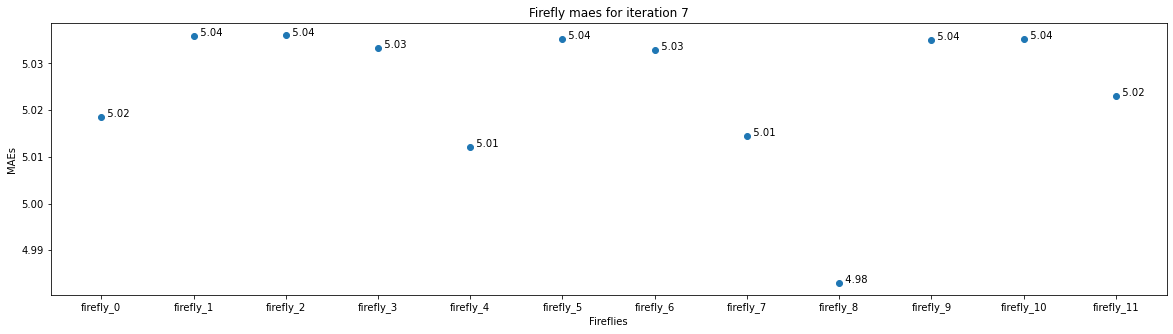


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0397, 0.0394, 0.0394, 0.0395, 0.0398, 0.0394, 0.0395, 0.0398, 0.0403, 0.0394, 0.0394, 0.0396]

firefly_ranked_indexes
[8, 4, 7, 0, 11, 6, 3, 9, 10, 5, 1, 2]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 8 MAE = 4.983084271641039 | Firefly_B = 4 MAE = 5.012167240840464 | B is better than A? False
Firefly_A = 8 MAE = 4.983084271641039 | Firefly_B = 7 MAE = 5.014487003239372 | B is better than A? False
Firefly_A = 8 MAE = 4.983084271641039 | Firefly_B = 0 MAE = 5.018526049141309 | B is better than A? False
Firefly_A = 8 MAE = 4.983084271641039 | Firefly_B = 11 MAE = 5.023023866576627 | B is better than A? False
Firefly_A = 8 MAE = 4.983084271641039 | Firefly_B = 6 MAE = 5.032896367357204 | B is better than A? False
Firefly_A = 8 MAE = 4.983084271641039 | Firefly_B = 3 MAE = 5.033327507520302 | B is better th

Decided to stop using is_weekend as firefly 5 doesn't already use it
Decided to stop using energy_cluster as firefly 4 doesn't use it
Decided to stop using num_bedrooms as firefly 5 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 5 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 5 doesn't already use it
Firefly_A = 5 MAE = 5.03533470673348 | Firefly_B = 7 MAE = 5.014487003239372 | B is better than A? True
Intensity difference between 5 and 7 is 0.0006913763316425264
learning_rate has changed from 0.017016247181058597 to 0.01701619231304543 taking a step of size 0.25
num_leaves has changed from 420 to 419.9398502591471 taking a step of size 0.25
max_depth has changed from 8 to 7.99982715591709 taking a step of size 0.25
bagging_fraction has changed from 0.963708750441205 to 0.9636987730122556 taking a step of size 0.25
bagging_freq has changed from 9 to 9.001037064497464 taking a step of size 0.25
feature_fraction has changed from 0

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 8, Firefly 0
Feature groups
['month_cyclic', 'num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.053619729828658806, 'num_leaves': 1514, 'max_depth': 11, 'bagging_fraction': 0.8887729816921803, 'bagging_freq': 17, 'feature_fraction': 0.5660693598631253, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5660693598631253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660693598631253
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8887729816921803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8887729816921803
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Cur

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03011
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6566571094341968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6566571094341968
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8395798646705966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8395798646705966
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03752
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5458552836089157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5458552836089157
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03014
Fold 3
Training the 

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.761203619580941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.761203619580941
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.789624629645772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789624629645772
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03669
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.761203619580941, colsample_bytree=1.0 will be ignored. Curre

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6389404771907722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6389404771907722
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.683719978556252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683719978556252
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03831
MAE = 5.035310352817492, TOE = 0:00:05, Intensity = 0.039440963236193005

Iteration 8, Firefly 11
Feature groups
['num_bedrooms']
Hyper p

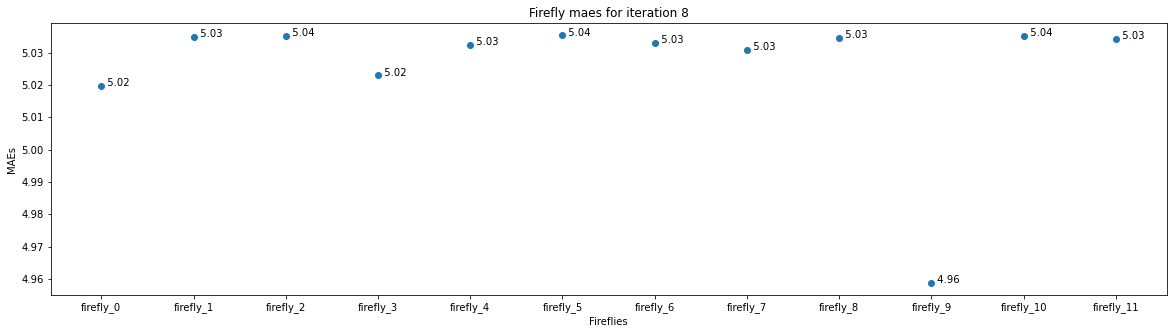


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0397, 0.0394, 0.0394, 0.0396, 0.0395, 0.0394, 0.0395, 0.0395, 0.0395, 0.0407, 0.0394, 0.0395]

firefly_ranked_indexes
[9, 0, 3, 7, 4, 6, 11, 8, 1, 2, 10, 5]

firefly ranked intensities
[0.041, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 9 MAE = 4.9588523376704 | Firefly_B = 0 MAE = 5.019778672360496 | B is better than A? False
Firefly_A = 9 MAE = 4.9588523376704 | Firefly_B = 3 MAE = 5.02293778789693 | B is better than A? False
Firefly_A = 9 MAE = 4.9588523376704 | Firefly_B = 7 MAE = 5.030860430726489 | B is better than A? False
Firefly_A = 9 MAE = 4.9588523376704 | Firefly_B = 4 MAE = 5.032516021749027 | B is better than A? False
Firefly_A = 9 MAE = 4.9588523376704 | Firefly_B = 6 MAE = 5.032903833723576 | B is better than A? False
Firefly_A = 9 MAE = 4.9588523376704 | Firefly_B = 11 MAE = 5.034288652299773 | B is better than A? False

learning_rate has changed from 0.01586664954008238 to 0.015876360898542722 taking a step of size 0.5
num_leaves has changed from 1818 to 1817.921801004067 taking a step of size 0.5
max_depth has changed from 11 to 11.0 taking a step of size 0.5
bagging_fraction has changed from 0.6833388905681763 to 0.6833917351065194 taking a step of size 0.5
bagging_freq has changed from 5 to 5.003086802471039 taking a step of size 0.5
feature_fraction has changed from 0.6398659066468804 to 0.6398469236999664 taking a step of size 0.5
lambda_l1 has changed from 8 to 8.002057868314026 taking a step of size 0.5
lambda_l2 has changed from 18 to 17.999485532921494 taking a step of size 0.5
Decided to stop using meter_id_ord as firefly 0 doesn't use it
Decided to stop using meter_id_binary as firefly 10 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 10 doesn't already use it
Decided to stop using day_of_week as firefly 0 doesn't use it
Decided to stop using day_of_month as fire

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 9, Firefly 0
Feature groups
['dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.053725416811724366, 'num_leaves': 1587, 'max_depth': 11, 'bagging_fraction': 0.888044466887387, 'bagging_freq': 17, 'feature_fraction': 0.5669606935392187, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5669606935392187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5669606935392187
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.888044466887387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.888044466887387
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: la

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.99519
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6575003516567447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575003516567447
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8387890588521938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387890588521938
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03753
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5470274977881002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5470274977881002
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9987329678280202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987329678280202
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03828
MAE = 5.035282414491147, TOE = 0:00:05, Intensity = 0.03944140091474548

Iteration 9, Firefly 8
Feature groups
['dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03583515714237648, 'num_leaves': 343, 'max_depth': 9, 'bagging_fraction': 0.7889883437671452, 'bagging_freq': 5, 'feature_fraction': 0.7693522987472846, 'lambda_l1': 5, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7693522987472846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693522987472846
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7889883437671452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02598
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6398363112400451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398363112400451
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6833913005848979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6833913005848979
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

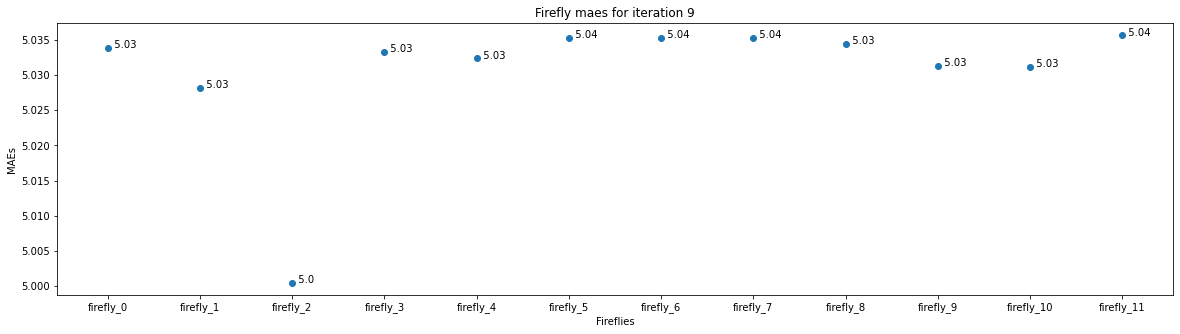


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0396, 0.04, 0.0395, 0.0395, 0.0394, 0.0394, 0.0394, 0.0395, 0.0395, 0.0395, 0.0394]

firefly_ranked_indexes
[2, 1, 10, 9, 4, 3, 0, 8, 7, 6, 5, 11]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 2 MAE = 5.000519115642617 | Firefly_B = 1 MAE = 5.028131648465262 | B is better than A? False
Firefly_A = 2 MAE = 5.000519115642617 | Firefly_B = 10 MAE = 5.031138016316687 | B is better than A? False
Firefly_A = 2 MAE = 5.000519115642617 | Firefly_B = 9 MAE = 5.0313186847539555 | B is better than A? False
Firefly_A = 2 MAE = 5.000519115642617 | Firefly_B = 4 MAE = 5.0323700129785305 | B is better than A? False
Firefly_A = 2 MAE = 5.000519115642617 | Firefly_B = 3 MAE = 5.033326648234798 | B is better than A? False
Firefly_A = 2 MAE = 5.000519115642617 | Firefly_B = 0 MAE = 5.033801400975734 | B is better t

Decided to stop using meter_id_binary as firefly 5 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 5 doesn't already use it
Decided to keep using day_of_week as firefly 5 already uses it
Decided to stop using day_of_month as firefly 5 doesn't already use it
Decided to keep using month_ord as firefly 5 already uses it
Decided to stop using month_cyclic as firefly 5 doesn't already use it
Decided to stop using is_weekend as firefly 5 doesn't already use it
Decided to stop using energy_cluster as firefly 5 doesn't already use it
Decided to stop using num_bedrooms as firefly 5 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 5 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 5 doesn't already use it
Firefly_A = 5 MAE = 5.0353417717938385 | Firefly_B = 3 MAE = 5.033326648234798 | B is better than A? True
Intensity difference between 5 and 3 is 6.661184697959177e-05
learning_rate has changed from 0.01674685553195

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 10, Firefly 0
Feature groups
['day_of_month', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05368228227014203, 'num_leaves': 1729, 'max_depth': 10, 'bagging_fraction': 0.8879571759163412, 'bagging_freq': 17, 'feature_fraction': 0.5671043783924501, 'lambda_l1': 15, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5671043783924501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5671043783924501
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8879571759163412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8879571759163412
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be igno

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03006
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6575003516567447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6575003516567447
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8387890588521938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387890588521938
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.01665
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.547216948720445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.547216948720445
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.998482207217693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998482207217693
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03828
MAE = 5.03528240639867, TOE = 0:00:06, Intensity = 0.039441401041522335

Iteration 10, Firefly 8
Feature groups
['meter_id_binary']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.035813889382785076, 'num_leaves': 344, 'max_depth': 9, 'bagging_fraction': 0.7890219308416566, 'bagging_freq': 5, 'feature_fraction': 0.7692441876141558, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7692441876141558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7692441876141558
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7890219308416566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02598
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6398699415295641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6398699415295641
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6835479835007208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6835479835007208
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

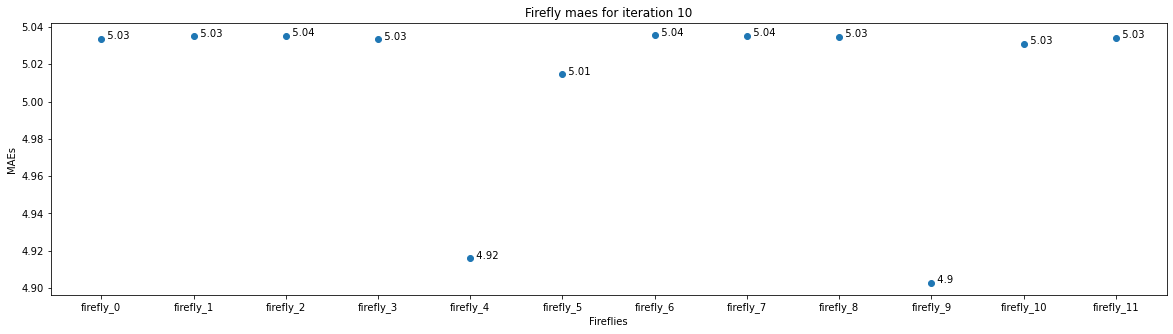


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0394, 0.0394, 0.0395, 0.0414, 0.0398, 0.0394, 0.0394, 0.0395, 0.0416, 0.0395, 0.0395]

firefly_ranked_indexes
[9, 4, 5, 10, 3, 0, 11, 8, 1, 2, 7, 6]

firefly ranked intensities
[0.042, 0.041, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 9 MAE = 4.902954264171366 | Firefly_B = 4 MAE = 4.915867242445253 | B is better than A? False
Firefly_A = 9 MAE = 4.902954264171366 | Firefly_B = 5 MAE = 5.014572662194145 | B is better than A? False
Firefly_A = 9 MAE = 4.902954264171366 | Firefly_B = 10 MAE = 5.031137091969737 | B is better than A? False
Firefly_A = 9 MAE = 4.902954264171366 | Firefly_B = 3 MAE = 5.033334037510006 | B is better than A? False
Firefly_A = 9 MAE = 4.902954264171366 | Firefly_B = 0 MAE = 5.033620541660204 | B is better than A? False
Firefly_A = 9 MAE = 4.902954264171366 | Firefly_B = 11 MAE = 5.034274595216992 | B is bette

Decided to stop using dwelling_type_onehot as firefly 4 doesn't use it
Firefly_A = 6 MAE = 5.035471582735411 | Firefly_B = 5 MAE = 5.014572662194145 | B is better than A? True
Intensity difference between 6 and 5 is 0.0006893352453370971
learning_rate has changed from 0.07168384384970489 to 0.07167434751194121 taking a step of size 0.25
num_leaves has changed from 523 to 522.9822496174326 taking a step of size 0.25
max_depth has changed from 9 to 8.999655332377332 taking a step of size 0.25
bagging_fraction has changed from 0.8449978414610043 to 0.8450242920067355 taking a step of size 0.25
bagging_freq has changed from 12 to 11.999482998565998 taking a step of size 0.25
feature_fraction has changed from 0.695399653597365 to 0.6953741167070597 taking a step of size 0.25
lambda_l1 has changed from 11 to 11.001034002868005 taking a step of size 0.25
lambda_l2 has changed from 16 to 15.999827666188665 taking a step of size 0.25
Decided to keep using meter_id_ord as firefly 6 already uses 

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 11, Firefly 0
Feature groups
['meter_id_binary', 'day_of_week']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.053957084206141134, 'num_leaves': 1720, 'max_depth': 10, 'bagging_fraction': 0.8859556224108978, 'bagging_freq': 17, 'feature_fraction': 0.5696390805738414, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5696390805738414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696390805738414
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8859556224108978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8859556224108978
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02519
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6594583841411014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6594583841411014
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8370927364484413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8370927364484413
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03286
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5494972492051782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5494972492051782
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9961468900833271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9961468900833271
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03826
MAE = 5.035264633875171, TOE = 0:00:05, Intensity = 0.039441679467589245

Iteration 11, Firefly 8
Feature groups
['is_weekend', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.0362093369415856, 'num_leaves': 344, 'max_depth': 9, 'bagging_fraction': 0.787667735313174, 'bagging_freq': 5, 'feature_fraction': 0.7704456641852854, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7704456641852854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704456641852854
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.787667735313174, subsample=1.0 will be ignored. Current value: bagging

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03008
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6418862017804734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6418862017804734
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.6829061706377733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6829061706377733
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

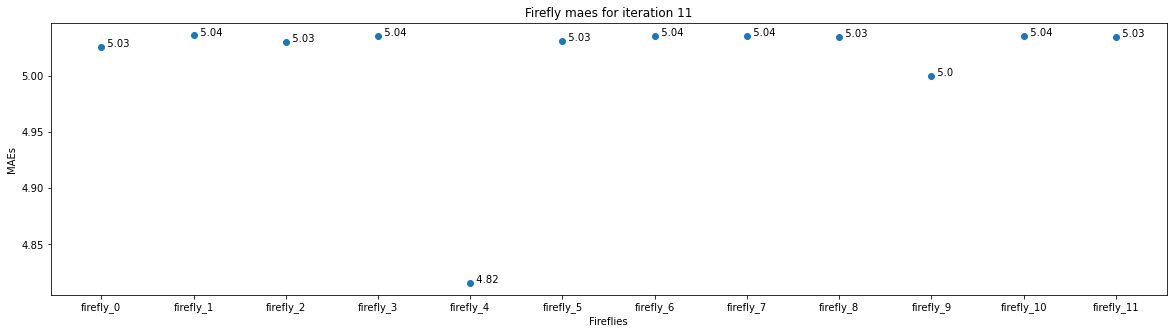


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0396, 0.0394, 0.0395, 0.0394, 0.0431, 0.0395, 0.0394, 0.0394, 0.0395, 0.04, 0.0394, 0.0395]

firefly_ranked_indexes
[4, 9, 0, 2, 5, 11, 8, 7, 10, 3, 6, 1]

firefly ranked intensities
[0.043, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 4 MAE = 4.816088800629515 | Firefly_B = 9 MAE = 4.999882193407948 | B is better than A? False
Firefly_A = 4 MAE = 4.816088800629515 | Firefly_B = 0 MAE = 5.025577384687742 | B is better than A? False
Firefly_A = 4 MAE = 4.816088800629515 | Firefly_B = 2 MAE = 5.030330377683422 | B is better than A? False
Firefly_A = 4 MAE = 4.816088800629515 | Firefly_B = 5 MAE = 5.030758699918806 | B is better than A? False
Firefly_A = 4 MAE = 4.816088800629515 | Firefly_B = 11 MAE = 5.034254997976275 | B is better than A? False
Firefly_A = 4 MAE = 4.816088800629515 | Firefly_B = 8 MAE = 5.034358885497652 | B is better tha

Decided to stop using month_ord as firefly 0 doesn't use it
Decided to stop using month_cyclic as firefly 6 doesn't already use it
Decided to stop using is_weekend as firefly 6 doesn't already use it
Decided to stop using energy_cluster as firefly 6 doesn't already use it
Decided to stop using num_bedrooms as firefly 6 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 0 doesn't use it
Decided to stop using dwelling_type_onehot as firefly 6 doesn't already use it
Firefly_A = 6 MAE = 5.035465422390788 | Firefly_B = 2 MAE = 5.030330377683422 | B is better than A? True
Intensity difference between 6 and 2 is 0.00016858938866717854
learning_rate has changed from 0.07175635257583349 to 0.07175521946574777 taking a step of size 0.125
num_leaves has changed from 525 to 525.0107686472011 taking a step of size 0.125
max_depth has changed from 9 to 9.000042147347166 taking a step of size 0.125
bagging_fraction has changed from 0.8434383701219594 to 0.8434382363961467 takin

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 12, Firefly 0
Feature groups
['day_of_week']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05417236436581355, 'num_leaves': 1712, 'max_depth': 10, 'bagging_fraction': 0.8841603906567699, 'bagging_freq': 17, 'feature_fraction': 0.57204901594513, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.57204901594513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.57204901594513
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8841603906567699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8841603906567699
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03002
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6612249239060549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6612249239060549
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8356292928220286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356292928220286
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03818
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5521582166620199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5521582166620199
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9933926151576464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9933926151576464
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03821
MAE = 5.0352119073250305, TOE = 0:00:05, Intensity = 0.039442505504156046

Iteration 12, Firefly 8
Feature groups
['month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03658541058507544, 'num_leaves': 347, 'max_depth': 9, 'bagging_fraction': 0.7865753016445282, 'bagging_freq': 5, 'feature_fraction': 0.771335845503212, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.771335845503212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771335845503212
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7865753016445282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786575301644

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02565
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6438572500498032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6438572500498032
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.6826851381637288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826851381637288
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

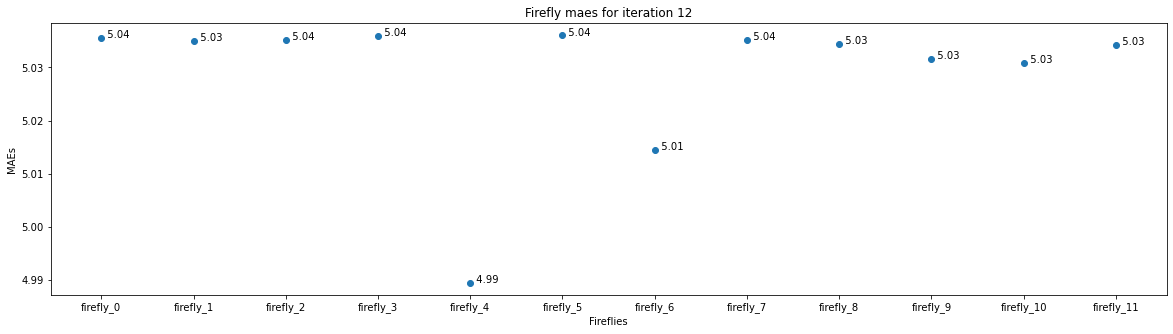


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0394, 0.0394, 0.0394, 0.0394, 0.0402, 0.0394, 0.0398, 0.0394, 0.0395, 0.0395, 0.0395, 0.0395]

firefly_ranked_indexes
[4, 6, 10, 9, 11, 8, 1, 7, 2, 0, 3, 5]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 4 MAE = 4.989594627776148 | Firefly_B = 6 MAE = 5.014560743577578 | B is better than A? False
Firefly_A = 4 MAE = 4.989594627776148 | Firefly_B = 10 MAE = 5.03081151300769 | B is better than A? False
Firefly_A = 4 MAE = 4.989594627776148 | Firefly_B = 9 MAE = 5.031623323046693 | B is better than A? False
Firefly_A = 4 MAE = 4.989594627776148 | Firefly_B = 11 MAE = 5.034140289010857 | B is better than A? False
Firefly_A = 4 MAE = 4.989594627776148 | Firefly_B = 8 MAE = 5.034398905844414 | B is better than A? False
Firefly_A = 4 MAE = 4.989594627776148 | Firefly_B = 1 MAE = 5.034890196460236 | B is better 

Decided to stop using day_of_year_cyclic as firefly 0 doesn't already use it
Decided to stop using day_of_week as firefly 0 doesn't already use it
Decided to stop using day_of_month as firefly 0 doesn't already use it
Decided to keep using month_ord as firefly 0 already uses it
Decided to stop using month_cyclic as firefly 0 doesn't already use it
Decided to stop using is_weekend as firefly 0 doesn't already use it
Decided to stop using energy_cluster as firefly 0 doesn't already use it
Decided to stop using num_bedrooms as firefly 0 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 0 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 0 doesn't already use it
Firefly_A = 0 MAE = 5.035504888531555 | Firefly_B = 7 MAE = 5.0352119073250305 | B is better than A? True
Intensity difference between 0 and 7 is 9.67272248998674e-06
learning_rate has changed from 0.05421830701977964 to 0.05421830428348909 taking a step of size 0.0078125
num_leave

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 13, Firefly 0
Feature groups
['dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.0520495708318857, 'num_leaves': 1711, 'max_depth': 10, 'bagging_fraction': 0.8307646393700164, 'bagging_freq': 17, 'feature_fraction': 0.5725587336671399, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5725587336671399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5725587336671399
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8307646393700164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307646393700164
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current valu

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03083
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6284808622314488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6284808622314488
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8353576807023451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353576807023451
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03804
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5527145364570354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5527145364570354
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9928030479969308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9928030479969308
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03825
MAE = 5.035253095843848, TOE = 0:00:05, Intensity = 0.03944186022507882

Iteration 13, Firefly 8
Feature groups
['month_cyclic']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03666316178276109, 'num_leaves': 348, 'max_depth': 9, 'bagging_fraction': 0.7864019524991204, 'bagging_freq': 5, 'feature_fraction': 0.8408876419544757, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8408876419544757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408876419544757
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7864019524991204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78640195

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03003
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.644182978525973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.644182978525973
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.6827005463441558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6827005463441558
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.

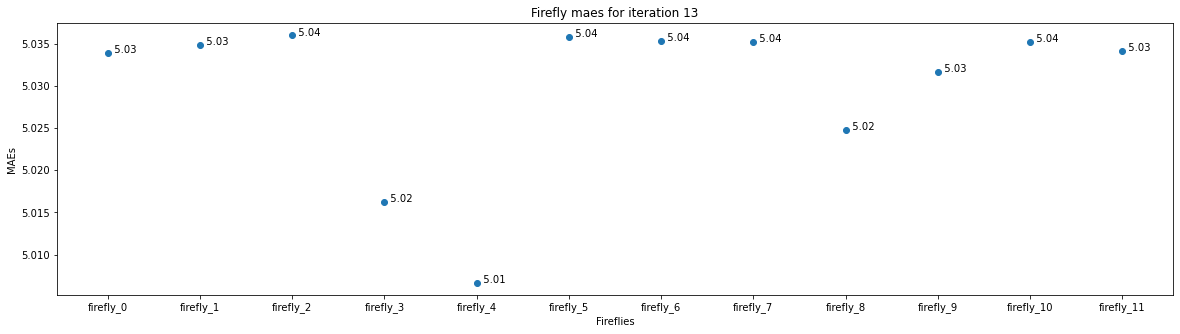


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0394, 0.0394, 0.0397, 0.0399, 0.0394, 0.0394, 0.0394, 0.0396, 0.0395, 0.0394, 0.0395]

firefly_ranked_indexes
[4, 3, 8, 9, 0, 11, 1, 10, 7, 6, 5, 2]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 4 MAE = 5.006688742012814 | Firefly_B = 3 MAE = 5.016235933946824 | B is better than A? False
Firefly_A = 4 MAE = 5.006688742012814 | Firefly_B = 8 MAE = 5.024817442764333 | B is better than A? False
Firefly_A = 4 MAE = 5.006688742012814 | Firefly_B = 9 MAE = 5.031634061718414 | B is better than A? False
Firefly_A = 4 MAE = 5.006688742012814 | Firefly_B = 0 MAE = 5.03389313157336 | B is better than A? False
Firefly_A = 4 MAE = 5.006688742012814 | Firefly_B = 11 MAE = 5.034144531089456 | B is better than A? False
Firefly_A = 4 MAE = 5.006688742012814 | Firefly_B = 1 MAE = 5.034886414452015 | B is better t

Decided to stop using meter_id_binary as firefly 2 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 2 doesn't already use it
Decided to stop using day_of_week as firefly 0 doesn't use it
Decided to stop using day_of_month as firefly 2 doesn't already use it
Decided to stop using month_ord as firefly 2 doesn't already use it
Decided to stop using month_cyclic as firefly 2 doesn't already use it
Decided to stop using is_weekend as firefly 2 doesn't already use it
Decided to stop using energy_cluster as firefly 2 doesn't already use it
Decided to stop using num_bedrooms as firefly 2 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 2 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 2 doesn't already use it
Firefly_A = 2 MAE = 5.03600320929613 | Firefly_B = 11 MAE = 5.034144531089456 | B is better than A? True
Intensity difference between 2 and 11 is 6.139982966504864e-05
learning_rate has changed from 0.01869399

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 14, Firefly 0
Feature groups
['meter_id_binary', 'day_of_month', 'month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05207895155079492, 'num_leaves': 1710, 'max_depth': 10, 'bagging_fraction': 0.8305503513368081, 'bagging_freq': 17, 'feature_fraction': 0.5728278816261345, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5728278816261345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5728278816261345
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8305503513368081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8305503513368081
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03001
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6286970411212758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286970411212758
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.835115282653081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835115282653081
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03749
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5530365686592922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5530365686592922
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9923395841057674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9923395841057674
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03885
MAE = 5.0358661914918255, TOE = 0:00:05, Intensity = 0.03943225704662796

Iteration 14, Firefly 8
Feature groups
['month_cyclic', 'is_weekend']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.036694040850497406, 'num_leaves': 348, 'max_depth': 9, 'bagging_fraction': 0.8492105582396935, 'bagging_freq': 5, 'feature_fraction': 0.8408552615253668, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8408552615253668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8408552615253668
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8492105582396935, subsample=1.0 will be ignored. Current value: bagging_fra

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03005
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6250395769893426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6250395769893426
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7441164269933922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441164269933922
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

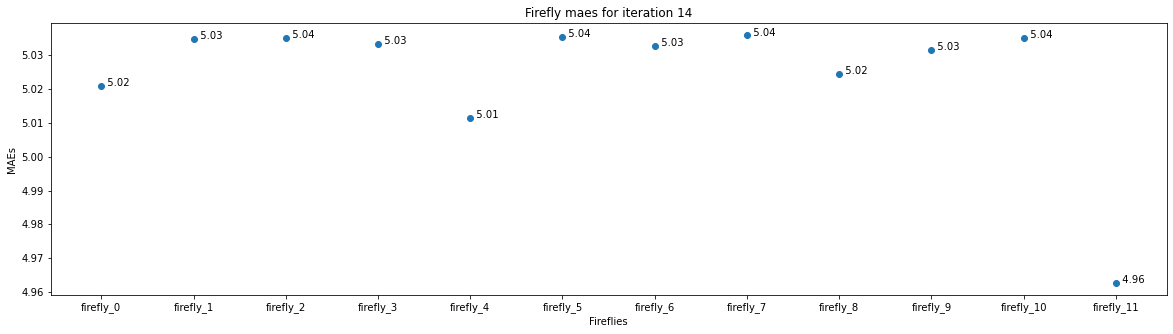


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0397, 0.0394, 0.0394, 0.0395, 0.0398, 0.0394, 0.0395, 0.0394, 0.0396, 0.0395, 0.0394, 0.0406]

firefly_ranked_indexes
[11, 4, 0, 8, 9, 6, 3, 1, 2, 10, 5, 7]

firefly ranked intensities
[0.041, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 11 MAE = 4.962806772780479 | Firefly_B = 4 MAE = 5.011509623021864 | B is better than A? False
Firefly_A = 11 MAE = 4.962806772780479 | Firefly_B = 0 MAE = 5.020857669618188 | B is better than A? False
Firefly_A = 11 MAE = 4.962806772780479 | Firefly_B = 8 MAE = 5.024565314196599 | B is better than A? False
Firefly_A = 11 MAE = 4.962806772780479 | Firefly_B = 9 MAE = 5.031633793154344 | B is better than A? False
Firefly_A = 11 MAE = 4.962806772780479 | Firefly_B = 6 MAE = 5.032893286204183 | B is better than A? False
Firefly_A = 11 MAE = 4.962806772780479 | Firefly_B = 3 MAE = 5.03334204052109 | B is bet

lambda_l1 has changed from 7 to 7.000001055917581 taking a step of size 0.0078125
lambda_l2 has changed from 18 to 17.99999932805245 taking a step of size 0.0078125
Decided to stop using meter_id_ord as firefly 10 doesn't already use it
Decided to stop using meter_id_binary as firefly 10 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 10 doesn't already use it
Decided to stop using day_of_week as firefly 10 doesn't already use it
Decided to stop using day_of_month as firefly 10 doesn't already use it
Decided to stop using month_ord as firefly 10 doesn't already use it
Decided to stop using month_cyclic as firefly 10 doesn't already use it
Decided to stop using is_weekend as firefly 10 doesn't already use it
Decided to stop using energy_cluster as firefly 10 doesn't already use it
Decided to stop using num_bedrooms as firefly 10 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 10 doesn't already use it
Decided to stop using dwelling_ty

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 15, Firefly 0
Feature groups
['meter_id_binary']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05414879334053339, 'num_leaves': 1709, 'max_depth': 10, 'bagging_fraction': 0.8307353506870101, 'bagging_freq': 16, 'feature_fraction': 0.5731184606558427, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5731184606558427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5731184606558427
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8307353506870101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307353506870101
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: l

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02823
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6289630710851614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289630710851614
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8352961118571449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8352961118571449
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=13, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03365
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5535309711328009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5535309711328009
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9920471712389857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9920471712389857
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03207
MAE = 5.028911504872926, TOE = 0:00:06, Intensity = 0.03954139741161789

Iteration 15, Firefly 8
Feature groups
['num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.036717828483866684, 'num_leaves': 350, 'max_depth': 9, 'bagging_fraction': 0.8493548663532067, 'bagging_freq': 5, 'feature_fraction': 0.8405533867189328, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8405533867189328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8405533867189328
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8493548663532067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8493548

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03005
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6253169577654482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253169577654482
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7445709031343938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7445709031343938
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

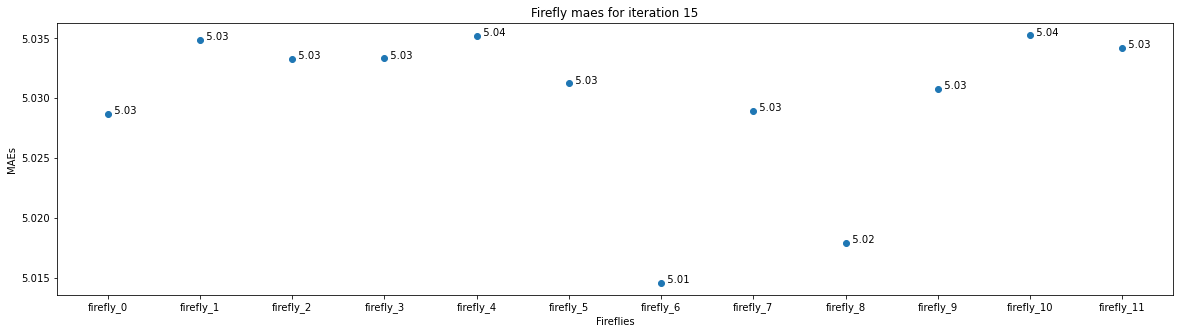


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0394, 0.0395, 0.0395, 0.0394, 0.0395, 0.0398, 0.0395, 0.0397, 0.0395, 0.0394, 0.0395]

firefly_ranked_indexes
[6, 8, 0, 7, 9, 5, 2, 3, 11, 1, 4, 10]

firefly ranked intensities
[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 6 MAE = 5.014581436063679 | Firefly_B = 8 MAE = 5.017896105402656 | B is better than A? False
Firefly_A = 6 MAE = 5.014581436063679 | Firefly_B = 0 MAE = 5.028673841628317 | B is better than A? False
Firefly_A = 6 MAE = 5.014581436063679 | Firefly_B = 7 MAE = 5.028911504872926 | B is better than A? False
Firefly_A = 6 MAE = 5.014581436063679 | Firefly_B = 9 MAE = 5.030798800891255 | B is better than A? False
Firefly_A = 6 MAE = 5.014581436063679 | Firefly_B = 5 MAE = 5.031240050774165 | B is better than A? False
Firefly_A = 6 MAE = 5.014581436063679 | Firefly_B = 2 MAE = 5.033266206026655 | B is better than

Decided to stop using is_weekend as firefly 6 doesn't use it
Decided to stop using energy_cluster as firefly 6 doesn't use it
Decided to start using num_bedrooms as firefly 6 uses it
Decided to stop using dwelling_type_ord as firefly 6 doesn't use it
Decided to stop using dwelling_type_onehot as firefly 6 doesn't use it
Firefly_A = 4 MAE = 5.035179442629086 | Firefly_B = 8 MAE = 5.017896105402656 | B is better than A? True
Intensity difference between 4 and 8 is 0.0005738263762812557
learning_rate has changed from 0.08055303319288165 to 0.08054045629454579 taking a step of size 0.5
num_leaves has changed from 747 to 746.8860954643081 taking a step of size 0.5
max_depth has changed from 9 to 9.0 taking a step of size 0.5
bagging_fraction has changed from 0.6629584429778209 to 0.6630119225699096 taking a step of size 0.5
bagging_freq has changed from 6 to 5.99971308681186 taking a step of size 0.5
feature_fraction has changed from 0.8629159931087722 to 0.8629095769820778 taking a step of

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 16, Firefly 0
Feature groups
['month_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05090466846756699, 'num_leaves': 1708, 'max_depth': 10, 'bagging_fraction': 0.8307445364716448, 'bagging_freq': 16, 'feature_fraction': 0.5732181866104762, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5732181866104762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5732181866104762
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8307445364716448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307445364716448
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02508
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6290531866581549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6290531866581549
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8353037074430307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353037074430307
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03752
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5813530776091163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813530776091163
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9919279333964212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9919279333964212
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0334
MAE = 5.030364722499938, TOE = 0:00:05, Intensity = 0.03951855455278975

Iteration 16, Firefly 8
Feature groups
['dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03672170191500822, 'num_leaves': 350, 'max_depth': 9, 'bagging_fraction': 0.8493541848073389, 'bagging_freq': 5, 'feature_fraction': 0.8405359954895494, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8405359954895494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8405359954895494
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8493541848073389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03004
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6254230560816106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6254230560816106
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7446757182123358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7446757182123358
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

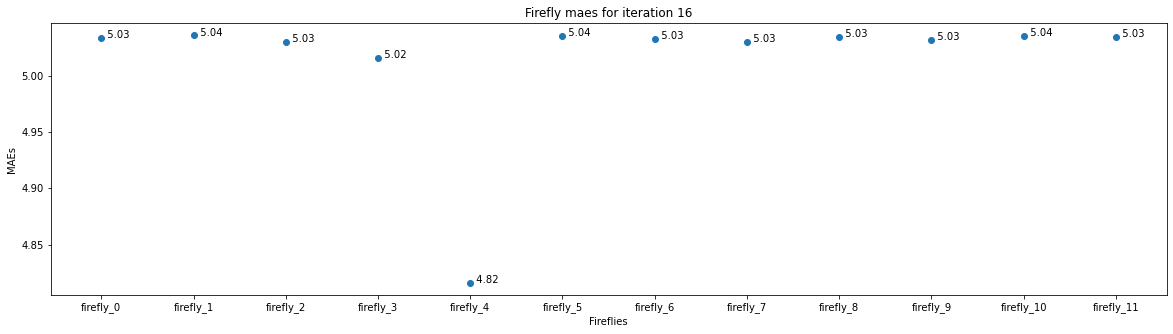


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0394, 0.0395, 0.0397, 0.0431, 0.0394, 0.0395, 0.0395, 0.0395, 0.0395, 0.0394, 0.0395]

firefly_ranked_indexes
[4, 3, 2, 7, 9, 6, 0, 11, 8, 10, 5, 1]

firefly ranked intensities
[0.043, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 4 MAE = 4.816310355916026 | Firefly_B = 3 MAE = 5.016093878902646 | B is better than A? False
Firefly_A = 4 MAE = 4.816310355916026 | Firefly_B = 2 MAE = 5.030233539641648 | B is better than A? False
Firefly_A = 4 MAE = 4.816310355916026 | Firefly_B = 7 MAE = 5.030364722499938 | B is better than A? False
Firefly_A = 4 MAE = 4.816310355916026 | Firefly_B = 9 MAE = 5.031626518504069 | B is better than A? False
Firefly_A = 4 MAE = 4.816310355916026 | Firefly_B = 6 MAE = 5.032896548926021 | B is better than A? False
Firefly_A = 4 MAE = 4.816310355916026 | Firefly_B = 0 MAE = 5.033938542224429 | B is better t

Decided to stop using meter_id_ord as firefly 10 doesn't already use it
Decided to stop using meter_id_binary as firefly 7 doesn't use it
Decided to stop using day_of_year_cyclic as firefly 10 doesn't already use it
Decided to stop using day_of_week as firefly 10 doesn't already use it
Decided to stop using day_of_month as firefly 10 doesn't already use it
Decided to stop using month_ord as firefly 10 doesn't already use it
Decided to stop using month_cyclic as firefly 10 doesn't already use it
Decided to start using is_weekend as firefly 7 uses it
Decided to keep using energy_cluster as firefly 10 already uses it
Decided to stop using num_bedrooms as firefly 10 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 10 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 10 doesn't already use it
Firefly_A = 10 MAE = 5.035249433208092 | Firefly_B = 9 MAE = 5.031626518504069 | B is better than A? True
Intensity difference between 10 and 9 is 0.

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 17, Firefly 0
Feature groups
['is_weekend']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.051134406742919525, 'num_leaves': 1616, 'max_depth': 10, 'bagging_fraction': 0.8293927829009254, 'bagging_freq': 16, 'feature_fraction': 0.5753999401060667, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5753999401060667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5753999401060667
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8293927829009254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8293927829009254
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambd

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02998
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6307681156627707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6307681156627707
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8339523087412668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339523087412668
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03644
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5834826678920736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5834826678920736
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9892619278572414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892619278572414
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03828
MAE = 5.0352813750356, TOE = 0:00:05, Intensity = 0.039441417198875055

Iteration 17, Firefly 8
Feature groups
['meter_id_binary', 'num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.037065463377665364, 'num_leaves': 353, 'max_depth': 8, 'bagging_fraction': 0.8478489010436234, 'bagging_freq': 5, 'feature_fraction': 0.8405812649588232, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8405812649588232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8405812649588232
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8478489010436234, subsample=1.0 will be ignored. Current value: bagging_

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02839
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6397404765611061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6397404765611061
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7440052268865556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7440052268865556
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

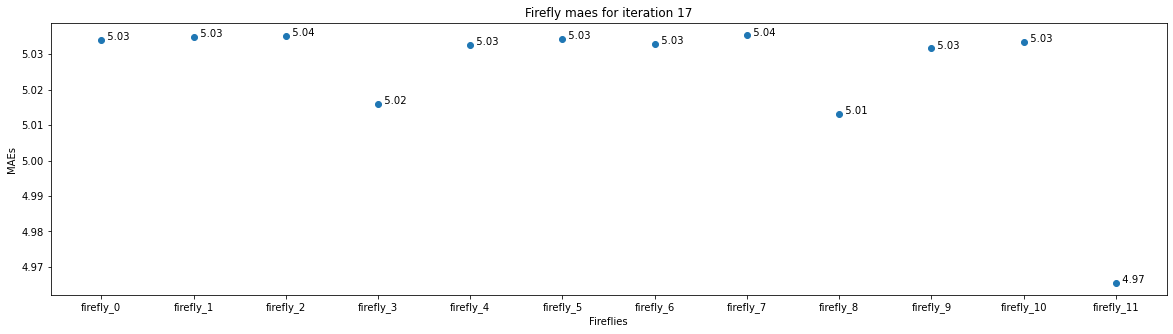


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0395, 0.0394, 0.0394, 0.0397, 0.0395, 0.0395, 0.0395, 0.0394, 0.0398, 0.0395, 0.0395, 0.0406]

firefly_ranked_indexes
[11, 8, 3, 9, 4, 6, 10, 0, 5, 1, 2, 7]

firefly ranked intensities
[0.041, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 11 MAE = 4.965590316407161 | Firefly_B = 8 MAE = 5.013064463631812 | B is better than A? False
Firefly_A = 11 MAE = 4.965590316407161 | Firefly_B = 3 MAE = 5.016067344225831 | B is better than A? False
Firefly_A = 11 MAE = 4.965590316407161 | Firefly_B = 9 MAE = 5.0316135313635835 | B is better than A? False
Firefly_A = 11 MAE = 4.965590316407161 | Firefly_B = 4 MAE = 5.0325144353171165 | B is better than A? False
Firefly_A = 11 MAE = 4.965590316407161 | Firefly_B = 6 MAE = 5.032898739130814 | B is better than A? False
Firefly_A = 11 MAE = 4.965590316407161 | Firefly_B = 10 MAE = 5.0334459259002395 | B 

Decided to stop using day_of_month as firefly 1 doesn't already use it
Decided to stop using month_ord as firefly 1 doesn't already use it
Decided to stop using month_cyclic as firefly 1 doesn't already use it
Decided to stop using is_weekend as firefly 1 doesn't already use it
Decided to stop using energy_cluster as firefly 1 doesn't already use it
Decided to stop using num_bedrooms as firefly 1 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 1 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 1 doesn't already use it
Firefly_A = 1 MAE = 5.03481844643845 | Firefly_B = 4 MAE = 5.0325144353171165 | B is better than A? True
Intensity difference between 1 and 4 is 7.601771002029023e-05
learning_rate has changed from 0.025542082747176537 to 0.025542344035059464 taking a step of size 0.0625
num_leaves has changed from 392 to 392.00182917614734 taking a step of size 0.0625
max_depth has changed from 9 to 9.0 taking a step of size 0.0625
ba

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 18, Firefly 0
Feature groups
['num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.050087979610491384, 'num_leaves': 1615, 'max_depth': 10, 'bagging_fraction': 0.8296054286949394, 'bagging_freq': 16, 'feature_fraction': 0.5757630271029318, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5757630271029318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5757630271029318
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8296054286949394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8296054286949394
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lam

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.02998
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6309833950483148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6309833950483148
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8341521279656966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8341521279656966
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03749
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5838265792629993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5838265792629993
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9890216008896846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9890216008896846
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03828
MAE = 5.035278231227002, TOE = 0:00:05, Intensity = 0.03944146644989934

Iteration 18, Firefly 8
Feature groups
['dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03707252444108676, 'num_leaves': 354, 'max_depth': 8, 'bagging_fraction': 0.847990394018902, 'bagging_freq': 5, 'feature_fraction': 0.840353508569991, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.840353508569991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.840353508569991
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.847990394018902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84799039

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03068
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6399199519414198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399199519414198
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7667884590893198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7667884590893198
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 

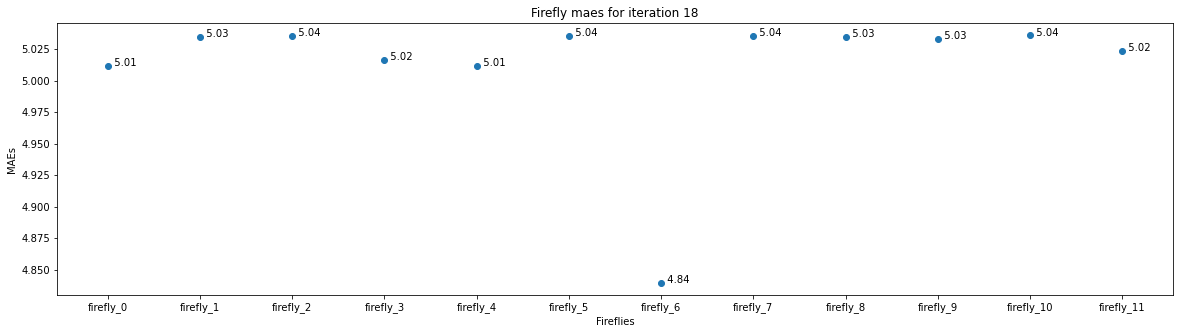


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.0398, 0.0394, 0.0394, 0.0397, 0.0398, 0.0394, 0.0427, 0.0394, 0.0395, 0.0395, 0.0394, 0.0396]

firefly_ranked_indexes
[6, 0, 4, 3, 11, 9, 8, 1, 2, 7, 5, 10]

firefly ranked intensities
[0.043, 0.04, 0.04, 0.04, 0.04, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.039]

Moving the fireflies
Firefly_A = 6 MAE = 4.839673728945393 | Firefly_B = 0 MAE = 5.0114788498848775 | B is better than A? False
Firefly_A = 6 MAE = 4.839673728945393 | Firefly_B = 4 MAE = 5.011707738020849 | B is better than A? False
Firefly_A = 6 MAE = 4.839673728945393 | Firefly_B = 3 MAE = 5.016075651718524 | B is better than A? False
Firefly_A = 6 MAE = 4.839673728945393 | Firefly_B = 11 MAE = 5.023373573899045 | B is better than A? False
Firefly_A = 6 MAE = 4.839673728945393 | Firefly_B = 9 MAE = 5.032831122946778 | B is better than A? False
Firefly_A = 6 MAE = 4.839673728945393 | Firefly_B = 8 MAE = 5.034379983260816 | B is better 

bagging_fraction has changed from 0.9884163572991227 to 0.9883531227592791 taking a step of size 0.25
bagging_freq has changed from 9 to 8.999415803596143 taking a step of size 0.25
feature_fraction has changed from 0.5845108350404007 to 0.5845649605214128 taking a step of size 0.25
lambda_l1 has changed from 17 to 16.99824741078843 taking a step of size 0.25
lambda_l2 has changed from 15 to 14.99805267865381 taking a step of size 0.25
Decided to stop using meter_id_ord as firefly 5 doesn't already use it
Decided to stop using meter_id_binary as firefly 5 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 5 doesn't already use it
Decided to stop using day_of_week as firefly 5 doesn't already use it
Decided to stop using day_of_month as firefly 5 doesn't already use it
Decided to stop using month_ord as firefly 4 doesn't use it
Decided to stop using month_cyclic as firefly 4 doesn't use it
Decided to start using is_weekend as firefly 4 uses it
Decided to keep usi

  0%|          | 0/12 [00:00<?, ?it/s]

Iteration 19, Firefly 0
Feature groups
['dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.05021800281233477, 'num_leaves': 1672, 'max_depth': 10, 'bagging_fraction': 0.8051826813629754, 'bagging_freq': 16, 'feature_fraction': 0.5764198212874634, 'lambda_l1': 16, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5764198212874634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5764198212874634
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_fraction is set=0.8051826813629754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051826813629754
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current val

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.01374
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6313614837008492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6313614837008492
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.8346108980464784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346108980464784
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=14, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0364
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5845585566946837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5845585566946837
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9883191912265858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883191912265858
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1:

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.03826
MAE = 5.03525998469189, TOE = 0:00:05, Intensity = 0.03944175230262933

Iteration 19, Firefly 8
Feature groups
['is_weekend']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 1, 'seed': 1337, 'learning_rate': 0.03732243344968405, 'num_leaves': 355, 'max_depth': 8, 'bagging_fraction': 0.8483463305754845, 'bagging_freq': 5, 'feature_fraction': 0.8391721805701146, 'lambda_l1': 5, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.8391721805701146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8391721805701146
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8483463305754845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84834633057

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5.0252
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6466348319064963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6466348319064963
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.7523994984093805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7523994984093805
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 5

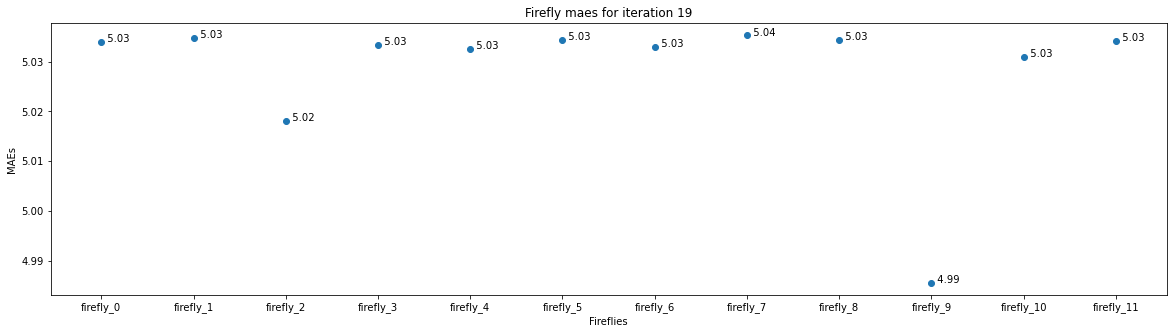

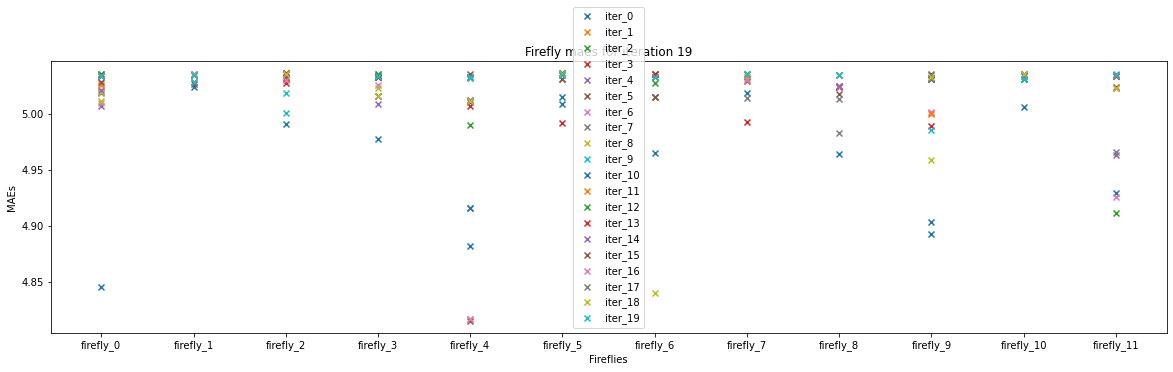

Firefly ran 20 iterations with a population of 12 in 0:21:09



In [51]:
num_folds = 3

number_of_iterations = 20
source_intensity = 1

fireflies = population

all_results = [] # will hold array of all the tuples of results + hyper params

#for the number of iterations
print(f"{color.BOLD}Firefly Algorithm hyper parameter optimization{color.END}\n")
start_time = time.time()
for i in tqdm(range(number_of_iterations)):
    
    iteration_results = [] #results of this iteration
    firefly_intensities = [] #corresponding intensities of the fireflies light
    
    #evaluate each firefly
    best_mae = 9999
    best_index = 0
    
    print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}Training the fireflies{color.END}")
    for f in tqdm(range(len(fireflies))):
        
        print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Iteration {i}, Firefly {f}{color.END}")
            
        #getting this models columns
        X_col_groups = fireflies[f][2]
        X_cols = fireflies[f][0]
        this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
        #getting this models hyper parameters
        this_params = fireflies[f][1]
        
        #inspecting
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Feature groups{color.END}")
        print(X_col_groups)
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper parameters{color.END}")
        print(this_params)
        
        #training this model and storing its results (excluding the lgbm model itself as was running out of memory)
        this_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params)
        iteration_results.append(((this_run[0],this_run[1]), # MAE and TOE (not this_run[2] (lgbm_models) to stop running out of memory)
                                  (X_cols,this_params,X_col_groups))) # models description so we can train and use the best lgbm models without having to store all in memory
        firefly_intensities.append(1/this_run[1]**2) #calculating the intensity of this firefly via inverse square law and storing it 
        print(f"MAE = {this_run[1]}, TOE = {str(datetime.timedelta(seconds=round(this_run[0])))}, Intensity = {str(1/this_run[1]**2)}\n")
        if this_run[1]<best_mae:
            best_mae = this_run[1]
            best_index = f
    #adding this populations results to all_results
    all_results = all_results + iteration_results
    print(f"{color.BOLD}Best results for iteration {i} is {best_mae} from firefly {best_index}{color.END}")

    #visualizing the maes so we can see how they change for each firefly
    plot_firefly_maes = []
    plot_firefly_names = []
    for result_i in range(len(iteration_results)):
        plot_firefly_maes.append(iteration_results[result_i][0][1])
        plot_firefly_names.append("firefly_"+str(result_i))
        
    fig, ax = plt.subplots(figsize=(20,5))
    ax.scatter(plot_firefly_names, plot_firefly_maes)

    for point_index, txt in enumerate(plot_firefly_maes):
        ax.annotate(str("  ")+str(round(txt,2)), (plot_firefly_names[point_index], plot_firefly_maes[point_index]))

    plt.title(f"Firefly maes for iteration {i}")
    plt.xlabel("Fireflies")
    plt.ylabel("MAEs")
    ax.set_xticks(np.arange(len(fireflies)))
    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}__iter{i}_firefly_MAEs.png")
    plt.close()
    plt.close(fig)
    del fig, ax
    gc.collect()

    
    #if this isn't the last iteration...
    if i<number_of_iterations-1:

        #sorting the fireflies in descending order by their intensities (so best firefly at the start)
        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nSorting the fireflies in order of best intensity{color.END}")
        print("firefly_intensities original order")
        rounded_firefly_intensities = []
        for intensity in firefly_intensities:
            rounded_firefly_intensities.append(round(intensity,4))
        print(rounded_firefly_intensities)
        firefly_ranked_indexes = sorted(range(len(firefly_intensities)), key=lambda k: firefly_intensities[k], reverse=True)
        print("\nfirefly_ranked_indexes")
        print(firefly_ranked_indexes)
        print("\nfirefly ranked intensities")
        rounded_firefly_intensities = []
        for n in firefly_ranked_indexes:
            rounded_firefly_intensities.append(round(firefly_intensities[n],3))
        print(rounded_firefly_intensities)

        #normalizing the intensities
        sum_of_intensities = sum(firefly_intensities)
        firefly_intensities = [float(i)/sum_of_intensities for i in firefly_intensities]

        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nMoving the fireflies{color.END}")

        #move the fireflies
        new_fireflies = fireflies.copy()
        for a in firefly_ranked_indexes:
            firefly_A = fireflies[a]
            step_size_coef = 1 # decrease this every time we find a better firefly
            for b in firefly_ranked_indexes:
                #if this is the same firefly then skip this iteration
                if a==b:
                    continue
                firefly_B = fireflies[b]
                print(f"{color.BOLD}{color.PURPLE}Firefly_A = {a} MAE = {iteration_results[a][0][1]} | Firefly_B = {b} MAE = {iteration_results[b][0][1]} | B is better than A? {iteration_results[a][0][1] > iteration_results[b][0][1]}{color.END}")


                #move firefly A towards firefly B if it's error is better (smaller)
                if(iteration_results[a][0][1] > iteration_results[b][0][1]):
                    intensity_difference = abs(firefly_intensities[b]-firefly_intensities[a])
                    print(f"{color.YELLOW}Intensity difference between {a} and {b} is {intensity_difference}{color.END}")

                    #iteratively moving the hyper parameters
                    new_a_params = params.copy()
                    for key in tuned_hyper_names:
                        #getting the current param value
                        a_param = new_fireflies[a][1][key] # considering changes 
                        b_param = fireflies[b][1][key] # only original value
                        #updating the value based on the intensity
                        temp_new_param = (1-intensity_difference)*a_param + intensity_difference*b_param
                        new_a_params[key] = (1-step_size_coef)*a_param+step_size_coef*temp_new_param
                        
                        print(f"{key} has changed from {a_param} to {new_a_params[key]} taking a step of size {step_size_coef}")

                        #if this key needs to be a whole number, round it
                        if(key in whole_number_hyper_names):
                            new_a_params[key] = int(max(1,round(new_a_params[key])))
                        #clipping fractional keys between 0 and 1
                        if(key in fractional_hyper_names):
                            new_a_params[key] = float(max(0, min(new_a_params[key],1)))

                    
                    
                    #iteratively moving the columns
                    new_a_cols = []
                    new_a_col_groups = []
                    for key in possible_columns.keys():

                        #generate a random number and accept it if it it is within the difference then take the column from firefly b
                        if(random.random()<step_size_coef):
                            if key in fireflies[b][0]:
                                new_a_col_groups+=[key]
                                new_a_cols+=possible_columns[key]
                                print(f"Decided to start using {key} as firefly {b} uses it")
                            else:
                                print(f"Decided to stop using {key} as firefly {b} doesn't use it")

                        #else keep this column as it is currently in firefly a (inc. if it has been added by a prior firefly)
                        else:
                            if key in new_fireflies[a][0]:
                                new_a_col_groups+=[key]
                                new_a_cols+=possible_columns[key]
                                print(f"Decided to keep using {key} as firefly {a} already uses it")
                            else:
                                print(f"Decided to stop using {key} as firefly {a} doesn't already use it")

                    step_size_coef/=2# decreasing the step size for the next firefly we find
                    #updating this firefly
                    new_fireflies[a] = (new_a_cols, new_a_params, new_a_col_groups)

#                     break #as we only want to move towards the firefly that is better than us

        #adding some randomness to this firefly
        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nAdding Noise to the fireflies{color.END}")
        for a in range(len(fireflies)):
            #random noise to hyper parameter with a 1/n chance mutating them by +/- up to 10%
            print(f"{color.BOLD}{color.PURPLE}Mutating Firefly_A = {a}{color.END}")
            noisy_a_params = new_fireflies[a][1].copy()
            for key in tuned_hyper_names:
                random_chance = random.randrange(len(tuned_hyper_names))==1
                if random_chance:
                    noisy_a_params[key]*=(random.randrange(90,110)/100)
                    print(f"randomly added noise to {key} changing it from {new_fireflies[a][1][key]} to {noisy_a_params[key]}")
                   #if this key needs to be a whole number, round it
                    if(key in whole_number_hyper_names):
                        noisy_a_params[key] = int(max(1,round(noisy_a_params[key])))
                    #clipping fractional keys between 0 and 1
                    if(key in fractional_hyper_names):
                        noisy_a_params[key] = float(max(0, min(noisy_a_params[key],1)))
                
            #random bitflipping of columns (1/n chance)
            noisy_cols = []
            noisy_cols_groups = []
            for key in possible_columns.keys():
                random_chance = random.randrange(len(possible_columns.keys()))==1
                if random_chance:
                    if key not in new_fireflies[a][0]:
                        noisy_cols_groups+=[key]
                        noisy_cols+=possible_columns[key]
                        print(f"Decided to start using {key} as firefly {a} doesn't already use it and we are randomly walking")
                    else:
                        print(f"Decided to stop using {key} as firefly {a} already uses it and we are randomly walking")
                else:
                    if key in new_fireflies[a][0]:
                        new_a_col_groups+=[key]
                        new_a_cols+=possible_columns[key]
#                         print(f"Decided to keep using {key} as firefly {a} already uses it and we are not randomly changing it")
#                     else:
#                         print(f"Decided to keep using {key} as firefly {a} doesn't already use it and we are not randomly changing it")
            if(len(noisy_cols_groups)<=0):
                    noisy_cols_groups=[random.choice(list(possible_columns.keys()))]
                    noisy_cols+=possible_columns[key]
                    print(f"No columns clipping length to 1 so randomly choosing to use {key}")

            new_fireflies[a] = (noisy_cols, noisy_a_params, noisy_cols_groups)

        #replacing fireflies with the new ones
        fireflies = new_fireflies.copy()
    print("\n\n\n")
    
#visualizing the maes so we can see how they change for each firefly over the iterations
all_firefly_maes = []
plot_firefly_names = []

for all_result_i in range(number_of_iterations):
    iter_firefly_maes = []
    for iter_result_i in range(len(fireflies)):
        iter_firefly_maes.append(all_results[iter_result_i+(all_result_i*len(fireflies))][0][1])
        if all_result_i == 0:
            plot_firefly_names.append("firefly_"+str(iter_result_i))
            
            
    all_firefly_maes.append(iter_firefly_maes)
    

fig, ax = plt.subplots(figsize=(20,15))

plot_iter=0
for this_firefly_maes in all_firefly_maes:
    ax.scatter(plot_firefly_names, this_firefly_maes, label=f"iter_{plot_iter}",marker="x")
    plot_iter+=1
    


plt.legend()
plt.title(f"Firefly maes for iteration {i}")
plt.xlabel("Fireflies")
plt.ylabel("MAEs")
ax.set_xticks(np.arange(len(fireflies)))
plt.show()
fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}__all_iters_firefly_MAEs.png")
plt.close()
plt.close(fig)
del fig, ax
gc.collect()

            
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Firefly ran {number_of_iterations} iterations with a population of {population_size} in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n") 

## Visualising information from the firefly algorithm results
### Box plots of the MAE for the different columns

  0%|          | 0/12 [00:00<?, ?it/s]

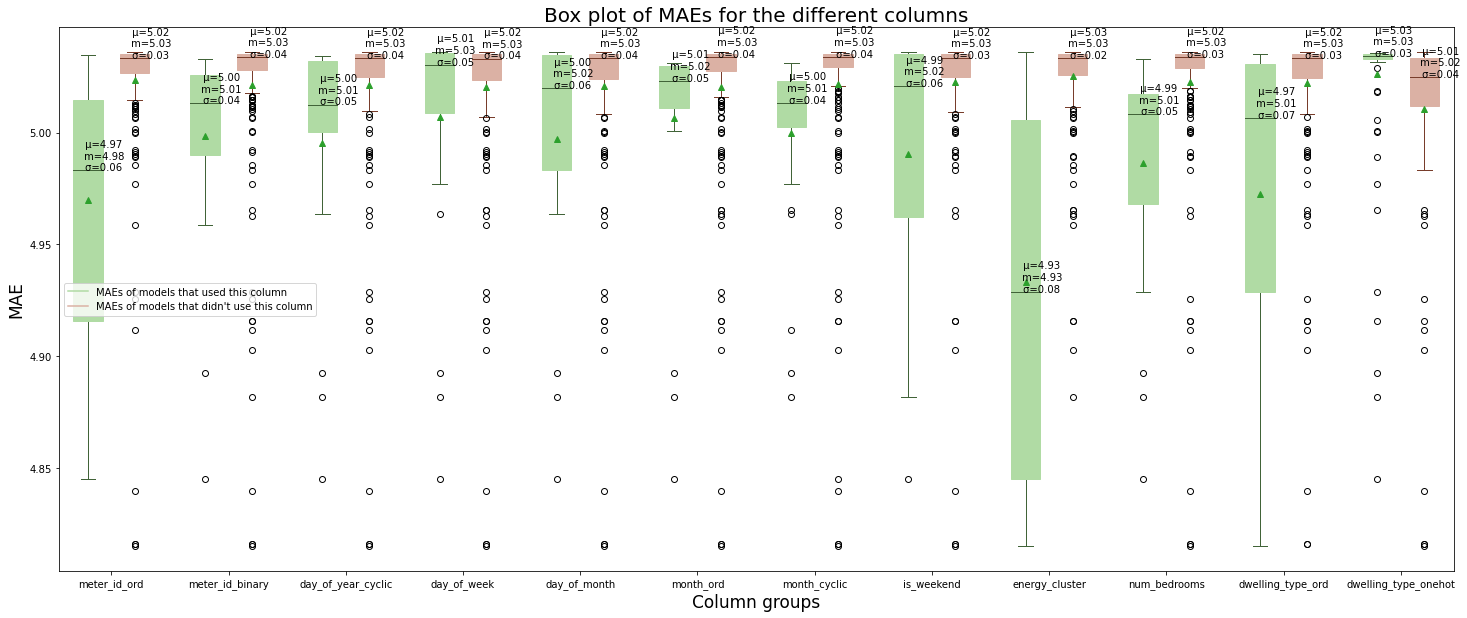

0

In [53]:
columns_maes = {} #dictionary of each columns maes
columnless_mae = {}
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    
    # if this column doesn't yet exist in the dict, create it
    if key not in columns_maes:
        columns_maes[key]=[]
    # if this column doesn't yet exist in the dict, create it
    if key not in columnless_mae:
        columnless_mae[key]=[]

    #iterating through every single models results
    for i in range(len(all_results)):
        
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])
            
        #else this column wasn't used by the model
        else:
            # adding this models mae to the dict entry for this column
            columnless_mae[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of each type{color.END}")
# pprint(columns_maes)

# function for setting the box colour
def set_box_color(bp, color_line, color_fill):
    plt.setp(bp['whiskers'], color=color_line)
    plt.setp(bp['caps'], color=color_line)
    plt.setp(bp['medians'], color=color_line)
    plt.setp(bp['fliers'], color=color_fill)
    plt.setp(bp['boxes'], color=color_fill)
    plt.setp(bp['means'], color=color_line)

    
### plotting a boxplot of these ###
# getting the 2 dicts we will plot
labels, data_columns = columns_maes.keys(), columns_maes.values()
data_columnless = columnless_mae.values()

#plotting these 2 dicts next to each other
fig = plt.figure(figsize=(25,10))
bp_dict_columns = plt.boxplot(data_columns,showmeans=True,positions=np.array(range(len(labels)))*2.0-0.4,patch_artist=True) # getting dictionary returned from boxplot
bp_dict_columnless = plt.boxplot(data_columnless,showmeans=True,positions=np.array(range(len(labels)))*2.0+0.4,patch_artist=True) # getting dictionary returned from boxplot

#colouring them
set_box_color(bp_dict_columns, '#416338','#b0dba4')
set_box_color(bp_dict_columnless, '#783d2b','#dbb1a4')

#annotating the plot
plt.title("Box plot of MAEs for the different columns", fontsize=20)
plt.xlabel("Column groups", fontsize=17)
plt.ylabel("MAE", fontsize=17)

#creating the legend
plt.plot([], c='#b0dba4',label="MAEs of models that used this column")
plt.plot([], c='#dbb1a4',label="MAEs of models that didn't use this column")
plt.legend()


## adding overlayed values to the boxplot

# stats for with columns
column_means = []
column_medians = []
column_std = []
for key in columns_maes.keys():
    column_means.append(np.mean(columns_maes[key]))
    column_medians.append(np.median(columns_maes[key]))
    column_std.append(np.std(columns_maes[key]))
for i, line in enumerate(bp_dict_columns['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(column_means[i], column_medians[i], column_std[i])
    plt.text(x, y, text, horizontalalignment='center')
    
# stats for without columns
columnless_means = []
columnless_medians = []
columnless_std = []
for key in columnless_mae.keys():
    columnless_means.append(np.mean(columnless_mae[key]))
    columnless_medians.append(np.median(columnless_mae[key]))
    columnless_std.append(np.std(columnless_mae[key]))
for i, line in enumerate(bp_dict_columnless['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(columnless_means[i], columnless_medians[i], columnless_std[i])
    plt.text(x, y, text, horizontalalignment='center')


plt.xticks(range(0, len(labels)*2,2), labels)

plt.show()

fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_Box_MAEs.png")

plt.close(fig)
del fig
gc.collect()

## Box and swarm plot to better inspect the distribution

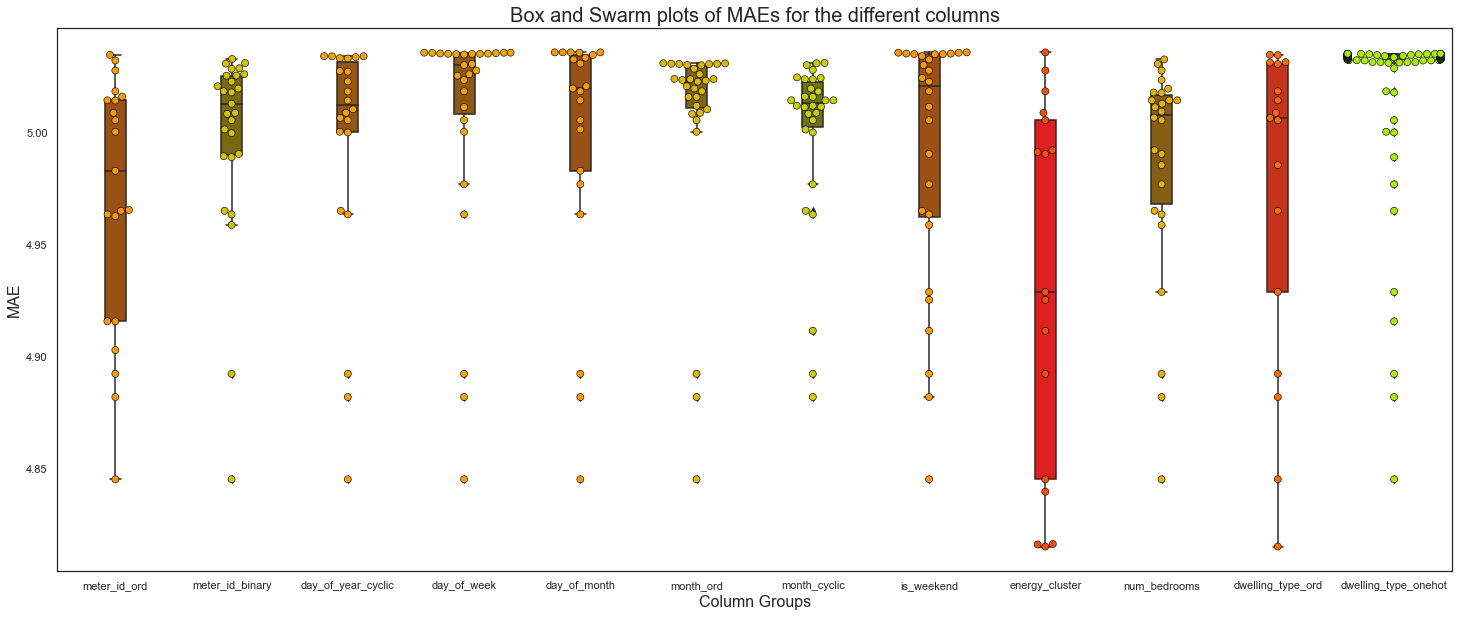

10002

In [54]:
colourBlindFriendly = False # make graph colourBlindFriendly (pink to blue instead of red to green)

#normalizing the std
max_std = max(column_std)
column_std = [float(i)/max_std for i in column_std]

#gradient of green to red based on each columns stats
box_grad_palette = {}
for i in range(len(column_std)):
    box_grad_palette[i] = [column_std[i], 1-column_std[i],1 if colourBlindFriendly else 0] #based on std

fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.boxplot(data=list(data_columns), width=.18, palette=box_grad_palette)

#slightly paler gradient to make it stand out from the box
swarm_grad_palette = box_grad_palette.copy()
for i in range(len(swarm_grad_palette)):
    #fading it to white
    #adding to red to make it paler
    swarm_grad_palette[i][0] = swarm_grad_palette[i][0]+0.3 if swarm_grad_palette[i][0]+0.3<1 else 1
    #adding to green to make it paler
    swarm_grad_palette[i][1] = swarm_grad_palette[i][1]+0.3 if swarm_grad_palette[i][1]+0.3<1 else 1
    #adding to blue to make it paler
    if colourBlindFriendly:
        swarm_grad_palette[i][2] = swarm_grad_palette[i][2]+0.3 if swarm_grad_palette[i][2]+0.3<1 else 1


sns.swarmplot(data=list(data_columns), size=7, edgecolor="black", linewidth=.6, palette=swarm_grad_palette)

plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_BoxSwarm_MAEs_GRAD_STD.png")
plt.close(fig)
del fig
gc.collect()

### Main Effects Plots

  0%|          | 0/8 [00:00<?, ?it/s]

learning_rate       MAE
203          0.095  4.892342

[array([0.095])]


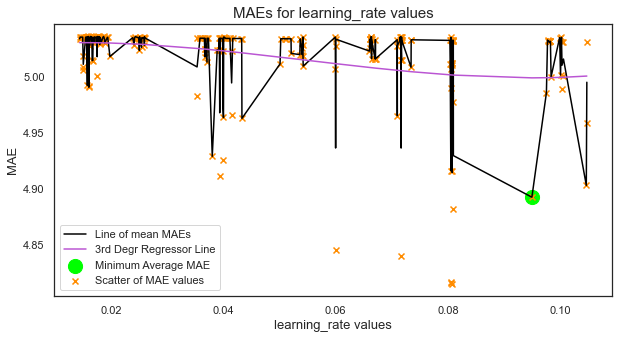

num_leaves       MAE
113      1443.0  4.845214

[array([0.095]), array([1443.])]


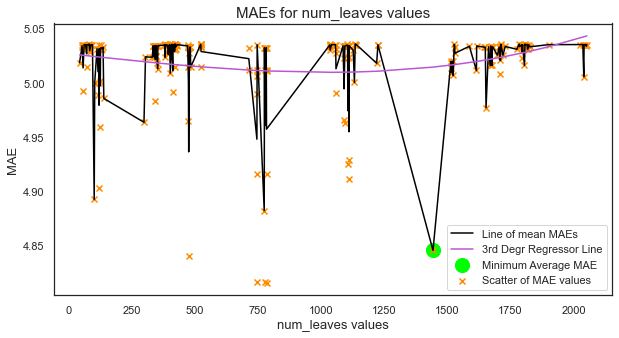

max_depth       MAE
4       10.0  5.010275

[array([0.095]), array([1443.]), array([10.])]


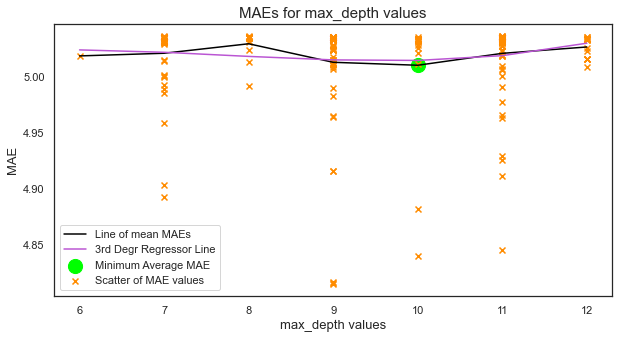

bagging_fraction       MAE
209              0.98  4.845214

[array([0.095]), array([1443.]), array([10.]), array([0.98])]


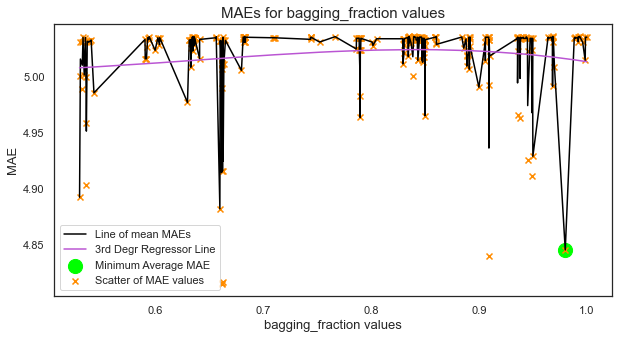

bagging_freq       MAE
1           6.0  4.971487

[array([0.095]), array([1443.]), array([10.]), array([0.98]), array([6.])]


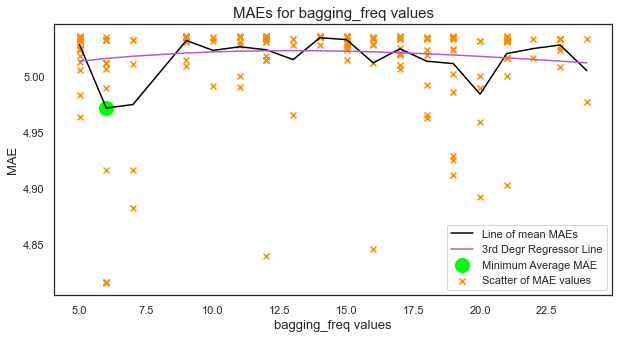

feature_fraction       MAE
199              0.95  4.887156

[array([0.095]), array([1443.]), array([10.]), array([0.98]), array([6.]), array([0.95])]


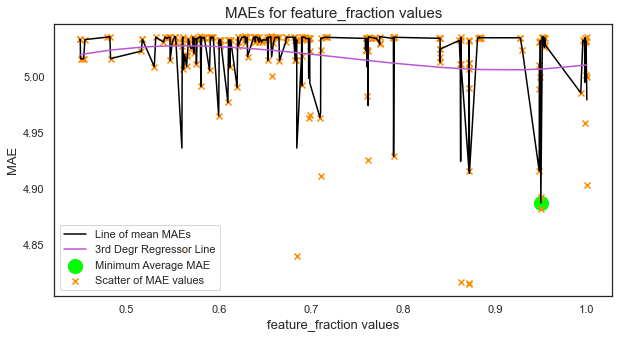

lambda_l1       MAE
1        6.0  4.963579

[array([0.095]), array([1443.]), array([10.]), array([0.98]), array([6.]), array([0.95]), array([6.])]


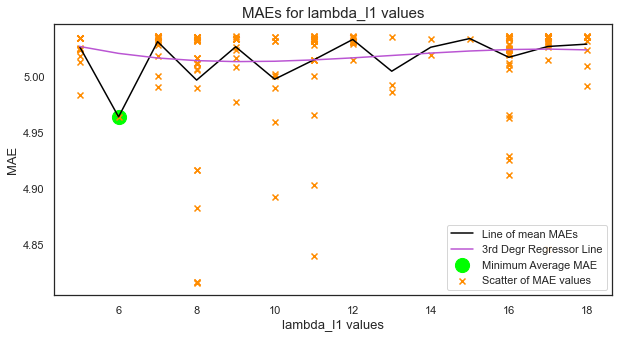

lambda_l2       MAE
0        5.0  4.998671

[array([0.095]), array([1443.]), array([10.]), array([0.98]), array([6.]), array([0.95]), array([6.]), array([5.])]


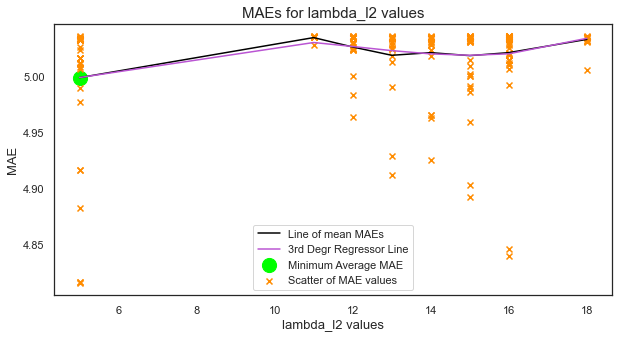

In [55]:
#array of the hyperparameters we tuned
arr_hypers = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
arr_best_hypers = []
#iterate through each of these hypers
for hyper in tqdm(arr_hypers):

    df_max_depth = pd.DataFrame(columns = [hyper,"MAE"])

    #iterating through each column and randomly decide whether or not to pick it
    #iterating through every single models results
    for i in range(len(all_results)):
        # adding this models mae to the dict entry for this column
        df_max_depth.loc[i] = [all_results[i][1][1][hyper],all_results[i][0][1]]

    #sort in ascending order by the params values
    df_all = df_max_depth.sort_values(by=[hyper])
    # display(df_all)

    #grouping together by value and calculating mean
    grouped_df = df_all.groupby(hyper)
    mean_df = grouped_df.mean().reset_index()
    #display(mean_df)
    
    # the minimum point
    df_min = mean_df[mean_df['MAE']==mean_df['MAE'].min()]
    arr_best_hypers.append(df_min[hyper].values)
    display(df_min)

    #plotting the stats for this param 
    fig = plt.figure(figsize=(10,5))
    print(arr_best_hypers)
    
    plt.scatter(df_min[hyper], df_min.MAE, label="Minimum Average MAE", color="lime", marker="o",s=200)
    plt.plot(mean_df[hyper], mean_df.MAE, label="Line of mean MAEs", color="black") # line of means
    plt.scatter(df_all[hyper], df_all.MAE, label="Scatter of MAE values", color="darkorange", marker="x") # scatter of values
    plt.plot(np.unique(df_all[hyper]), 
             np.poly1d(np.polyfit(df_all[hyper], df_all.MAE, 3))
             (np.unique(df_all[hyper])), label="3rd Degr Regressor Line", color="mediumorchid") # line of best fit from a simple regressor

    plt.title(f"MAEs for {hyper} values", fontsize=15)
    plt.xlabel(f"{hyper} values", fontsize=13)
    plt.ylabel("MAE", fontsize=13)
    
    plt.legend()

    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_scatter_{hyper}.png")
    plt.close(fig)
    del fig
    gc.collect()

### inspecting stats on all models TOE and MAE

In [56]:
#inspecting the min/max/mean of time of execution of the models we tested in firefly algorithm
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")


min time of execution = 0:00:05
max time of execution = 0:00:09
mean time of execution = 0:00:05

min MAE = 4.815153487535586
max MAE= 5.0360067156072486
mean MAE = 5.018817720712728


## Inspecting the results of the hyper parameter optimization

In [57]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}iteration {int(i/population_size)} individual {i%population_size} {color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at iteration",int(best_index/population_size),"individual",best_index%population_size,"with a MAE of",best_mae)

iteration 0 individual 0 
Time of execution for skf-cv: 0:00:08
Mean absolute error between OOF preds and meter_reading on training set: 4.845213922417806

iteration 0 individual 1 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.023660018752025

iteration 0 individual 2 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.990623305637164

iteration 0 individual 3 
Time of execution for skf-cv: 0:00:06
Mean absolute error between OOF preds and meter_reading on training set: 4.97705389490744

iteration 0 individual 4 
Time of execution for skf-cv: 0:00:07
Mean absolute error between OOF preds and meter_reading on training set: 4.881970228838986

iteration 0 individual 5 
Time of execution for skf-cv: 0:00:07
Mean absolute error between OOF preds and meter_reading on training set: 5.008989032620252

iteration 0 individual 6 
Time of execution for skf-cv: 0:00:08
M

iteration 12 individual 9 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.031623323046693

iteration 12 individual 10 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.03081151300769

iteration 12 individual 11 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.034140289010857

iteration 13 individual 0 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.03389313157336

iteration 13 individual 1 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.034886414452015

iteration 13 individual 2 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.03600320929613

iteration 13 individual 3 
Time of execution for skf-cv: 0:

Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.034379983260816

iteration 18 individual 9 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.032831122946778

iteration 18 individual 10 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.035839901449305

iteration 18 individual 11 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.023373573899045

iteration 19 individual 0 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.033977574722269

iteration 19 individual 1 
Time of execution for skf-cv: 0:00:05
Mean absolute error between OOF preds and meter_reading on training set: 5.0348033582008185

iteration 19 individual 2 
Time of execution for skf-cv: 0:00:07
Mean absolute err

## Training a model based on the best models 
* Done this as no longer storing the models in memory as was running out
* So instead just storing the configuration
* Then this is used to retrain a model with that configuration
    * Should fix the problem of running out of memory whilst running the GA

In [58]:
#no longer need all results only the best one
best_results = all_results[best_index]
del all_results
gc.collect()

20

In [59]:
best_X_cols = best_results[1][0]
best_X_cats = list(set(best_X_cols).intersection(all_cat)) #getting the categorical values for this X
best_params = best_results[1][1]
best_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, best_X_cols, best_X_cats, best_params)

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.872399423664597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.872399423664597
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6615710343041316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6615710343041316
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 4.81769
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.872399423664597, colsample_bytree=1.0 will be ignored. Curre

## Making predictions on best model

In [60]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = best_run[2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[best_results[1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [61]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from iteration {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(best_results[0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(best_results[0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {best_results[0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(best_results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(best_results[1][1])

best model came from iteration 5 individual 4
Evaluation and results
Time of execution for skf-cv:  0:00:05

Time of execution for predictions: 0:00:01

Total time of execution: 0:00:05

Mean absolute error between OOF preds and meter_reading on training set: 4.815153487535586

preds set with the next years forecasts for each meter


meter_id       date  meter_reading
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-01       8.928668
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-02       8.928668
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-03       8.928668
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-04       8.928668
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-05       8.928668
...                                             ...        ...            ...
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-27       9.892456
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-28       9.892456
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-29       9.892456
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-30       9.892456
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-31       9.892456

[1185520 rows x 3 columns]

Hyper-parameters

X_cols:

['energy_cluster', 'dwelling_type_ord']
model params:  
{'bagging_fraction': 0.6615710343041316,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.872399423664597,
 'lambda_l1': 8,
 'lambda_l2': 5,
 'learning_rate': 0.08079147742821485,
 'max_depth': 9,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 784,
 'num_threads': -1,
 'seed': 1337}


## Saving the description of the best model

In [62]:
BEST_LGBM_FORECASTS.to_pickle(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_daily_forecasts.pkl")

In [63]:
import pickle

desc_disc = {
    "time_of_execution_skf-cv":str(datetime.timedelta(seconds=round(best_results[0][0]))),
    "time_of_execution_preds":str(datetime.timedelta(seconds=round(execution_time))),
    "time_of_execution_total":str(datetime.timedelta(seconds=round(best_results[0][0]+execution_time))),
    "MAE":best_results[0][1],
    "features":best_results[1][0],
    "params":best_results[1][1]
}

with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 4.815153487535586,
 'features': ['energy_cluster', 'dwelling_type_ord'],
 'params': {'bagging_fraction': 0.6615710343041316,
            'bagging_freq': 6,
            'boosting_type': 'gbdt',
            'feature_fraction': 0.872399423664597,
            'lambda_l1': 8,
            'lambda_l2': 5,
            'learning_rate': 0.08079147742821485,
            'max_depth': 9,
            'metric': 'mae',
            'num_iterations': 1,
            'num_leaves': 784,
            'num_threads': -1,
            'seed': 1337},
 'time_of_execution_preds': '0:00:01',
 'time_of_execution_skf-cv': '0:00:05',
 'time_of_execution_total': '0:00:05'}
True


# Converting into monthly forecasts

In [64]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

meter_id         Jan         Feb  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  276.788700  250.002697   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  296.167306  267.505954   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  286.689104  258.944998   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  276.788700  250.002697   
4     0x005958406351bb29580475df698b5f1070096397  286.689104  258.944998   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  276.788700  250.002697   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  296.497517  267.804209   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  296.167306  267.505954   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  286.689104  258.944998   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  286.193722  258.497556   

             Mar         Apr         May         Jun         Jul         Aug  \
0     276.788700  267.860033  276.788700  267.860033  276.788700  276.788700   
1     296.167306  286.613522  296.167306  286.613522  296.167306  296.167306   
2     286.689104  277.441069  286.689104  277.441069  286.689104  286.689104   
3     276.788700  267.860033  276.788700  267.860033  276.788700  276.788700   
4     286.689104  277.441069  286.689104  277.441069  286.689104  286.689104   
...          ...         ...         ...         ...         ...         ...   
3243  276.788700  267.860033  276.788700  267.860033  276.788700  276.788700   
3244  296.497517  286.933081  296.497517  286.933081  296.497517  296.497517   
3245  296.167306  286.613522  296.167306  286.613522  296.167306  296.167306   
3246  286.689104  277.441069  286.689104  277.441069  286.689104  286.689104   
3247  286.193722  276.961667  286.193722  276.961667  286.193722  286.193722   

             Sep         Oct         Nov         Dec  
0     267.860033  276.788700  267.860033  276.788700  
1     286.613522  296.167306  286.613522  296.167306  
2     277.441069  286.689104  277.441069  286.689104  
3     267.860033  276.788700  267.860033  276.788700  
4     277.441069  286.689104  277.441069  286.689104  
...          ...         ...         ...         ...  
3243  267.860033  276.788700  267.860033  276.788700  
3244  286.933081  296.497517  286.933081  296.497517  
3245  286.613522  296.167306  286.613522  296.167306  
3246  277.441069  286.689104  277.441069  286.689104  
3247  276.961667  286.193722  276.961667  286.193722  

[3248 rows x 13 columns]

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [65]:
df_monthly_forecasts.to_csv(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [66]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

meter_id     2018-01     2018-02  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  276.788700  250.002697   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  296.167306  267.505954   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  286.689104  258.944998   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  276.788700  250.002697   
4     0x005958406351bb29580475df698b5f1070096397  286.689104  258.944998   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  276.788700  250.002697   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  296.497517  267.804209   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  296.167306  267.505954   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  286.689104  258.944998   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  286.193722  258.497556   

         2018-03     2018-04     2018-05     2018-06     2018-07     2018-08  \
0     276.788700  267.860033  276.788700  267.860033  276.788700  276.788700   
1     296.167306  286.613522  296.167306  286.613522  296.167306  296.167306   
2     286.689104  277.441069  286.689104  277.441069  286.689104  286.689104   
3     276.788700  267.860033  276.788700  267.860033  276.788700  276.788700   
4     286.689104  277.441069  286.689104  277.441069  286.689104  286.689104   
...          ...         ...         ...         ...         ...         ...   
3243  276.788700  267.860033  276.788700  267.860033  276.788700  276.788700   
3244  296.497517  286.933081  296.497517  286.933081  296.497517  296.497517   
3245  296.167306  286.613522  296.167306  286.613522  296.167306  296.167306   
3246  286.689104  277.441069  286.689104  277.441069  286.689104  286.689104   
3247  286.193722  276.961667  286.193722  276.961667  286.193722  286.193722   

         2018-09     2018-10     2018-11     2018-12  
0     267.860033  276.788700  267.860033  276.788700  
1     286.613522  296.167306  286.613522  296.167306  
2     277.441069  286.689104  277.441069  286.689104  
3     267.860033  276.788700  267.860033  276.788700  
4     277.441069  286.689104  277.441069  286.689104  
...          ...         ...         ...         ...  
3243  267.860033  276.788700  267.860033  276.788700  
3244  286.933081  296.497517  286.933081  296.497517  
3245  286.613522  296.167306  286.613522  296.167306  
3246  277.441069  286.689104  277.441069  286.689104  
3247  276.961667  286.193722  276.961667  286.193722  

[3248 rows x 13 columns]

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [67]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

meter_id  2018-01-01 00:00:00  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c             8.928668   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82             9.553784   
2     0x0019979ee12c59accd24d1c83291528ced1bb734             9.248036   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a             8.928668   
4     0x005958406351bb29580475df698b5f1070096397             9.248036   
...                                          ...                  ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f             8.928668   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb             9.564436   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5             9.553784   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02             9.248036   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4             9.232056   

      2018-01-02 00:00:00  2018-01-03 00:00:00  2018-01-04 00:00:00  \
0                8.928668             8.928668             8.928668   
1                9.553784             9.553784             9.553784   
2                9.248036             9.248036             9.248036   
3                8.928668             8.928668             8.928668   
4                9.248036             9.248036             9.248036   
...                   ...                  ...                  ...   
3243             8.928668             8.928668             8.928668   
3244             9.564436             9.564436             9.564436   
3245             9.553784             9.553784             9.553784   
3246             9.248036             9.248036             9.248036   
3247             9.232056             9.232056             9.232056   

      2018-01-05 00:00:00  2018-01-06 00:00:00  2018-01-07 00:00:00  \
0                8.928668             8.928668             8.928668   
1                9.553784             9.553784             9.553784   
2                9.248036             9.248036             9.248036   
3                8.928668             8.928668             8.928668   
4                9.248036             9.248036             9.248036   
...                   ...                  ...                  ...   
3243             8.928668             8.928668             8.928668   
3244             9.564436             9.564436             9.564436   
3245             9.553784             9.553784             9.553784   
3246             9.248036             9.248036             9.248036   
3247             9.232056             9.232056             9.232056   

      2018-01-08 00:00:00  2018-01-09 00:00:00  ...  2018-12-22 00:00:00  \
0                8.928668             8.928668  ...             8.928668   
1                9.553784             9.553784  ...             9.553784   
2                9.248036             9.248036  ...             9.248036   
3                8.928668             8.928668  ...             8.928668   
4                9.248036             9.248036  ...             9.248036   
...                   ...                  ...  ...                  ...   
3243             8.928668             8.928668  ...             8.928668   
3244             9.564436             9.564436  ...             9.564436   
3245             9.553784             9.553784  ...             9.553784   
3246             9.248036             9.248036  ...             9.248036   
3247             9.232056             9.232056  ...             9.232056   

      2018-12-23 00:00:00  2018-12-24 00:00:00  2018-12-25 00:00:00  \
0                8.928668             8.928668             8.928668   
1                9.553784             9.553784             9.553784   
2                9.248036             9.248036             9.248036   
3                8.928668             8.928668             8.928668   
4                9.248036             9.248036             9.248036   
...                   ...                  ...                  ...   
3243             8.928668             8.928668 

## loading training data and aggregating into months

In [68]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

training data


  0%|          | 0/12 [00:00<?, ?it/s]

meter_id  2017-01-01  2017-01-02  \
0     0xa62b9f23553ff183f61e2bf943aab3d5983d02d7       0.000       0.000   
1     0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da       0.000       0.000   
2     0x4a1ed36825360a058cec2bdd409fc2459e1ce54f       0.000       0.000   
3     0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407       0.000       0.000   
4     0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f       0.000       0.000   
...                                          ...         ...         ...   
3243  0x7dd7a7b8ee1bec7c44b24f738c752482f6161065       2.317       2.301   
3244  0xfdaf9f857621ec06f2cf801f42a020a322835090      14.437      16.274   
3245  0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18       7.824       7.517   
3246  0x47218b46abb2fcaade487a211911406dc6e13730      23.965      28.689   
3247  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd      11.302      14.178   

      2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
0          0.000       0.000       0.000       0.000       0.000       0.000   
1          0.000       0.000       0.000       0.000       0.000       0.000   
2          0.000       0.000       0.000       0.000       0.000       0.000   
3          0.000       0.000       0.000       0.000       0.000       0.000   
4          0.000       0.000       0.000       0.000       0.000       0.000   
...          ...         ...         ...         ...         ...         ...   
3243       2.352       2.516       2.229       2.354       2.397       2.397   
3244       7.031      17.018      17.603      15.005       8.987       8.490   
3245       5.398       6.788       7.360       6.898       7.321       8.042   
3246      27.664      29.229      29.548      27.909      26.923      21.277   
3247      15.499      11.853      17.431      14.506      12.812      10.472   

      2017-01-09  ...  2017-12-22  2017-12-23  2017-12-24  2017-12-25  \
0          0.000  ...       4.030       5.397      5.1075       4.818   
1          0.000  ...      13.101      14.327     14.6315      14.936   
2          0.000  ...      10.201       7.320      7.3520       7.384   
3          0.000  ...      14.833      12.477     11.7255      10.974   
4          0.000  ...      39.440      35.538     21.9445       8.351   
...          ...  ...         ...         ...         ...         ...   
3243       2.269  ...       9.390       9.231      9.2235       9.216   
3244      10.136  ...       4.141       2.828      3.8230       4.818   
3245       8.207  ...       6.767       5.919      5.9980       6.077   
3246      23.452  ...      20.747      19.979     20.1925      20.406   
3247      10.879  ...      14.036      15.990     15.5505      15.111   

      2017-12-26  2017-12-27  2017-12-28  2017-12-29  2017-12-30  2017-12-31  
0          3.931      4.2170       4.503      4.8160       5.129       5.395  
1         16.174     20.3960      24.618     19.8925      15.167      11.751  
2         14.425     16.0650      17.705     13.3355       8.966       4.633  
3         19.646     21.8195      23.993     19.9170      15.841      14.452  
4          9.957     17.9140      25.871     36.0725      46.274      16.901  
...          ...         ...         ...         ...         ...         ...  
3243       9.336      9.6840      10.032      9.8945       9.757       9.480  
3244       3.357      8.1315      12.906      8.0140       3.122       3.401  
3245       7.761      6.6080       5.455      5.5670       5.679       8.148  
3246      23.668     27.7900      31.912     29.1125      26.313      24.201  
3247      16.506     18.7585      21.011     19.2040      17.397      15.237  

[3248 rows x 366 columns]

meter_id   2017-01  2017-02   2017-03  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c    0.0000    0.000    0.0000   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82    0.0000    0.000    0.0000   
2     0x0019979ee12c59accd24d1c83291528ced1bb734    0.0000    0.000    0.0000   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a    0.0000    0.000    0.0000   
4     0x005958406351bb29580475df698b5f1070096397    0.0000    0.000    0.0000   
...                                          ...       ...      ...       ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f   72.7050   63.245   68.4335   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  371.4390  269.691  179.3430   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  209.8065  169.858  184.0130   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  845.6630  608.449  588.7765   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  428.7345  670.505  462.1050   

       2017-04   2017-05  2017-06   2017-07   2017-08   2017-09     2017-10  \
0       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
1       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
2       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
3       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
4       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
...        ...       ...      ...       ...       ...       ...         ...   
3243   66.6265   69.0480  100.430  177.1735  177.4100  216.7245  279.164500   
3244  141.6590  138.4835  122.910  164.2285  100.9610  118.0520  123.135500   
3245  166.7280  134.1760  169.489  157.5775  165.9640  177.0105  185.701833   
3246  503.3050  291.1320  177.605  183.5345  182.0350  244.2255  371.458333   
3247  354.8660  287.9950  200.321  227.0855  231.7585  246.3005  344.210167   

         2017-11    2017-12  
0       0.000000  128.39450  
1       0.000000  553.18400  
2       0.000000  368.90957  
3       0.000000  534.84650  
4       0.000000  946.06400  
...          ...        ...  
3243  351.481000  312.08800  
3244  187.140000  186.88400  
3245  192.288667  200.61950  
3246  695.878667  858.83950  
3247  516.290333  734.61800  

[3248 rows x 13 columns]

## Plotting the predictions against the training data

  0%|          | 0/3248 [00:00<?, ?it/s]

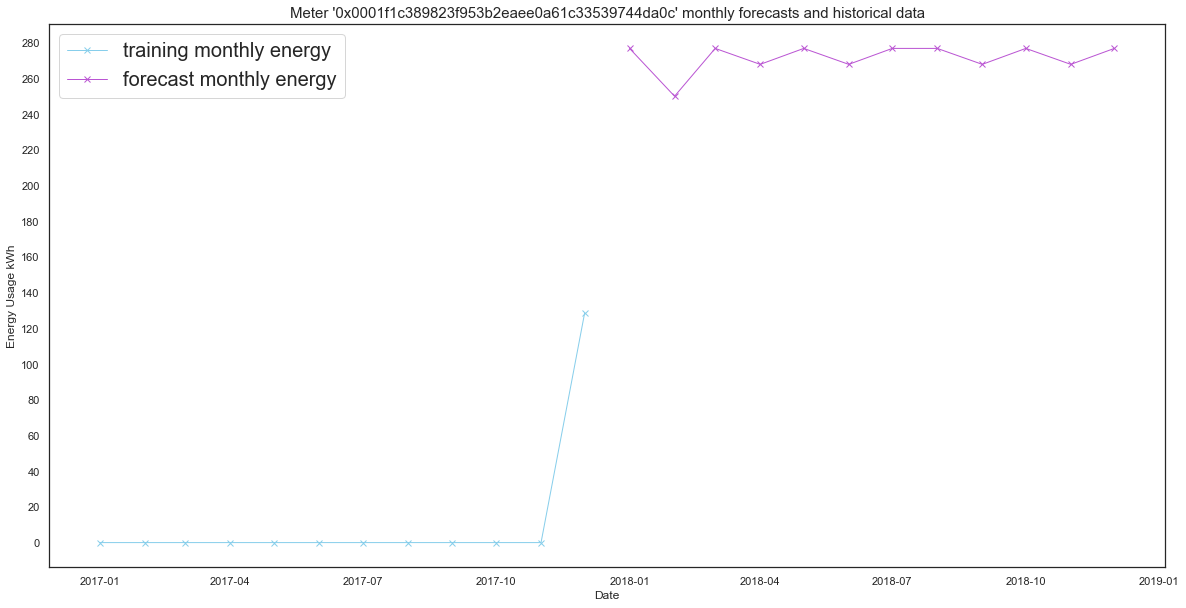

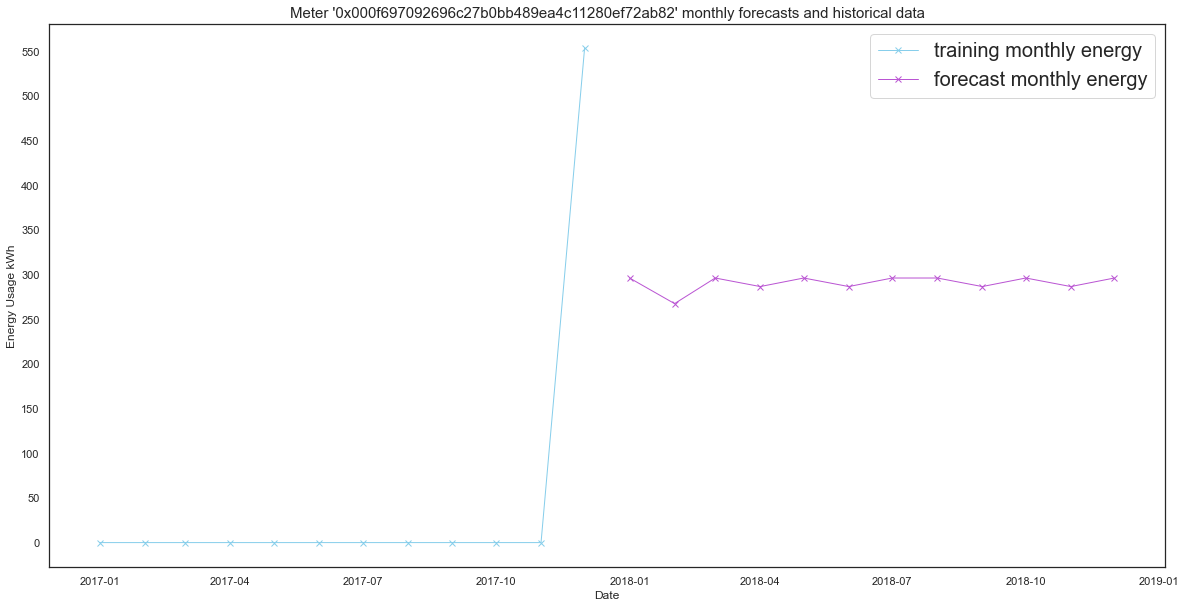

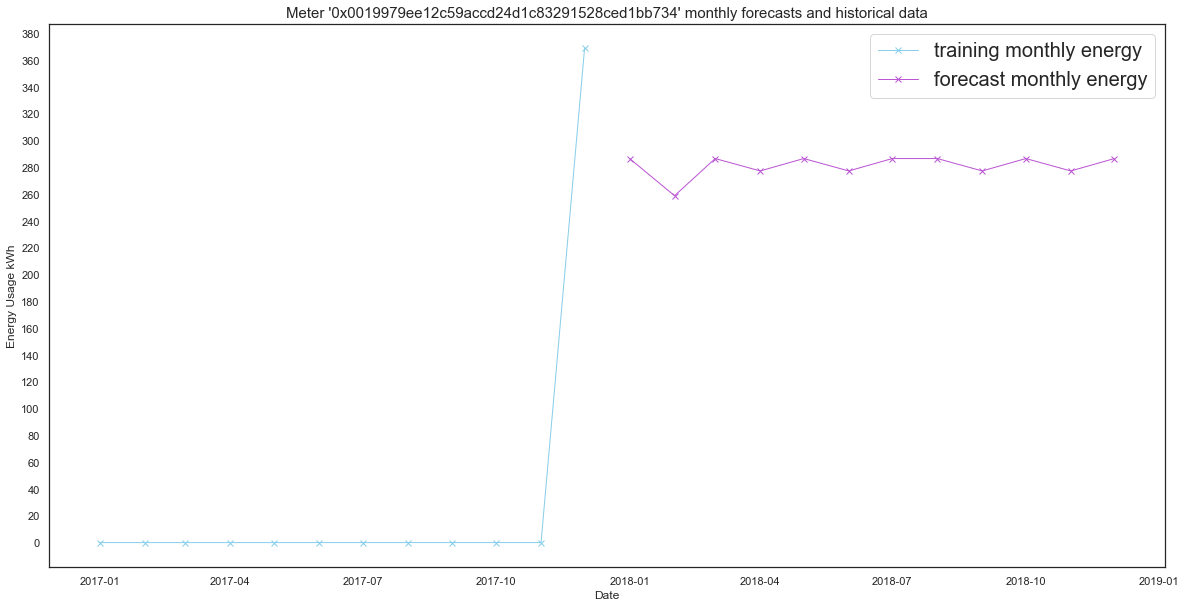

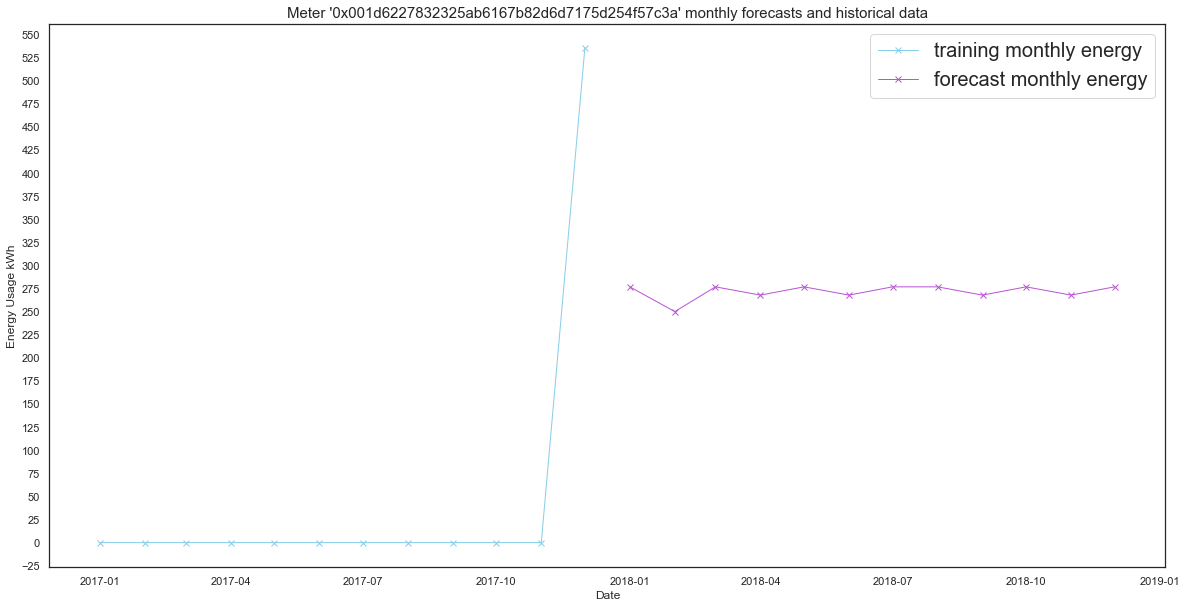

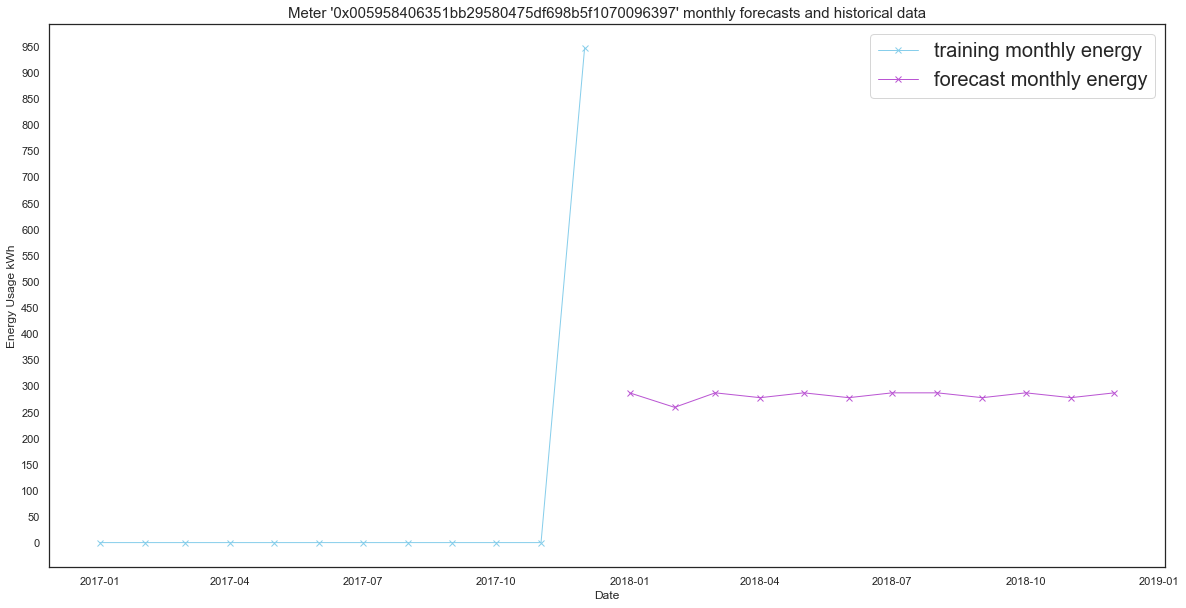

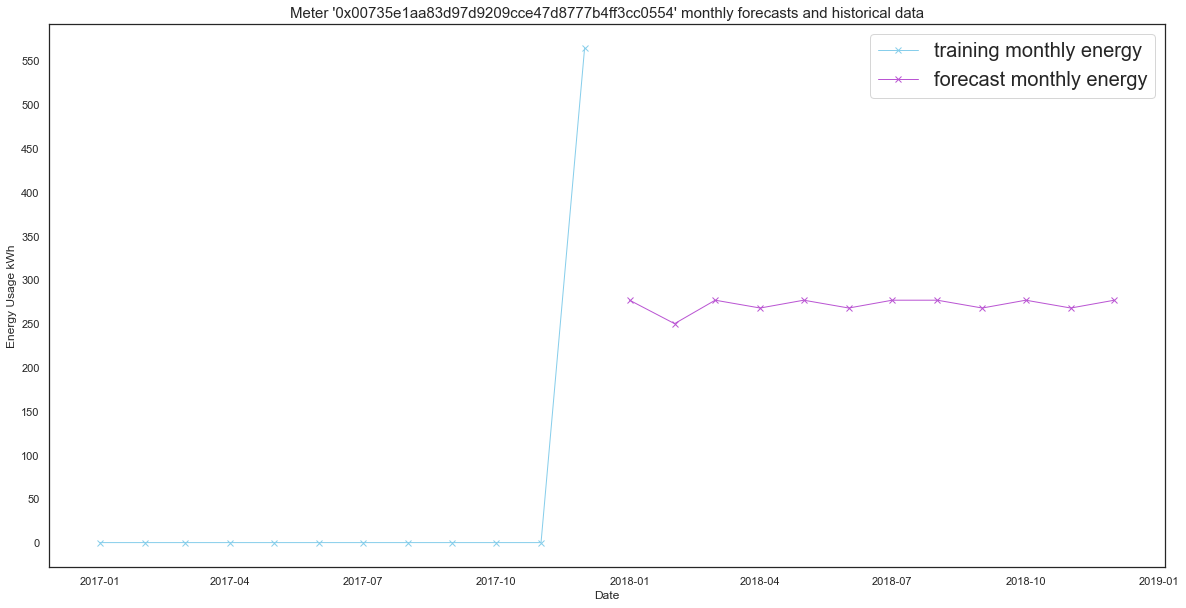

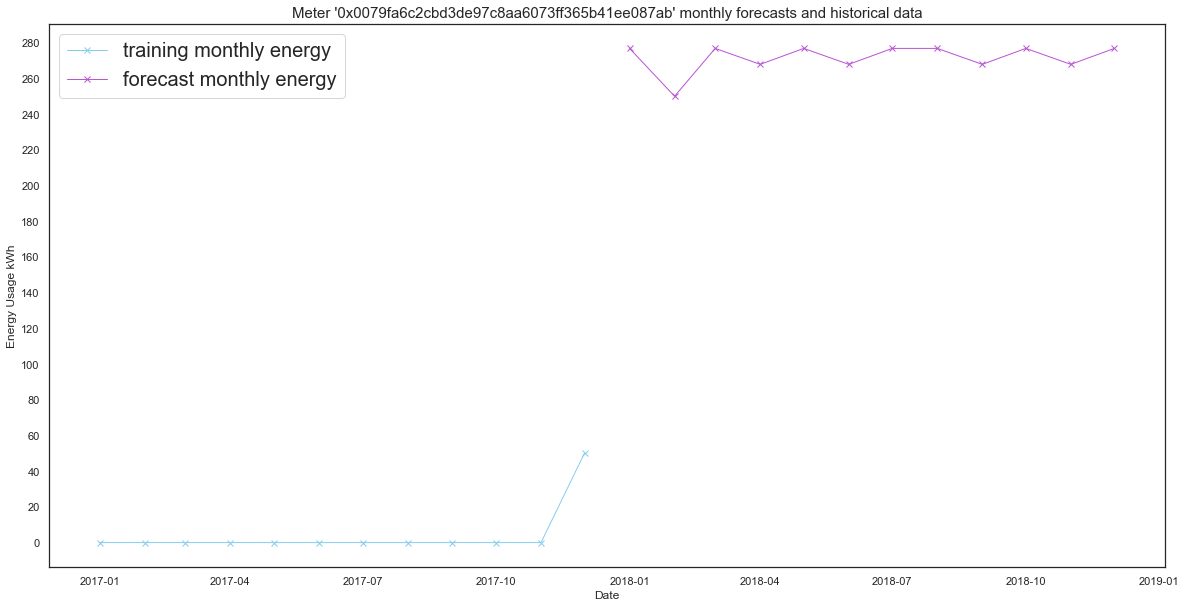

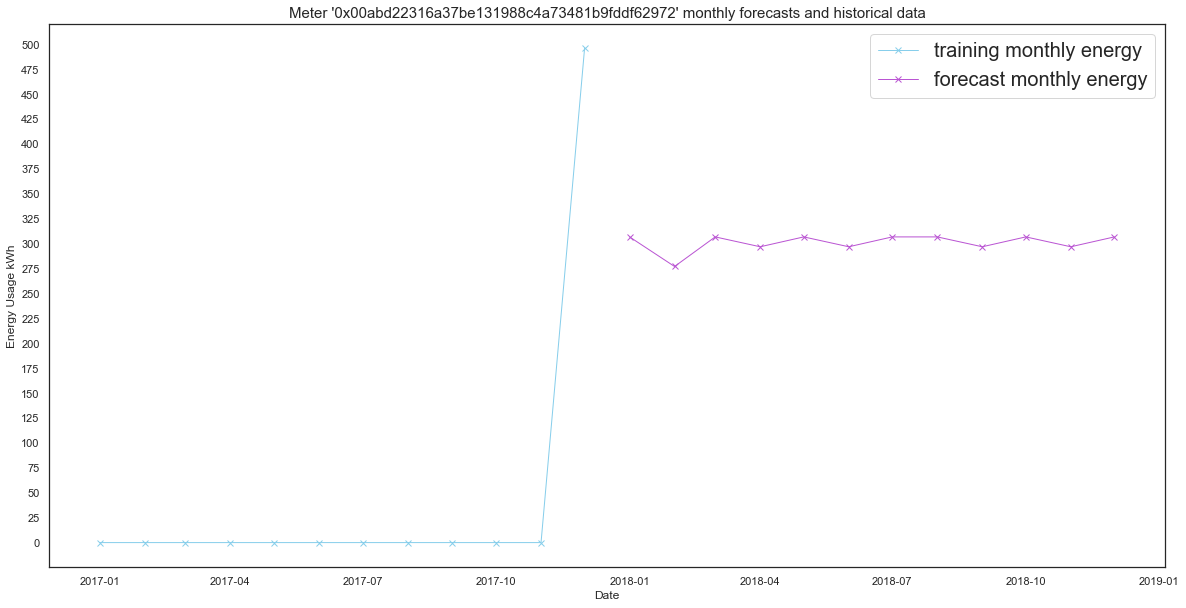

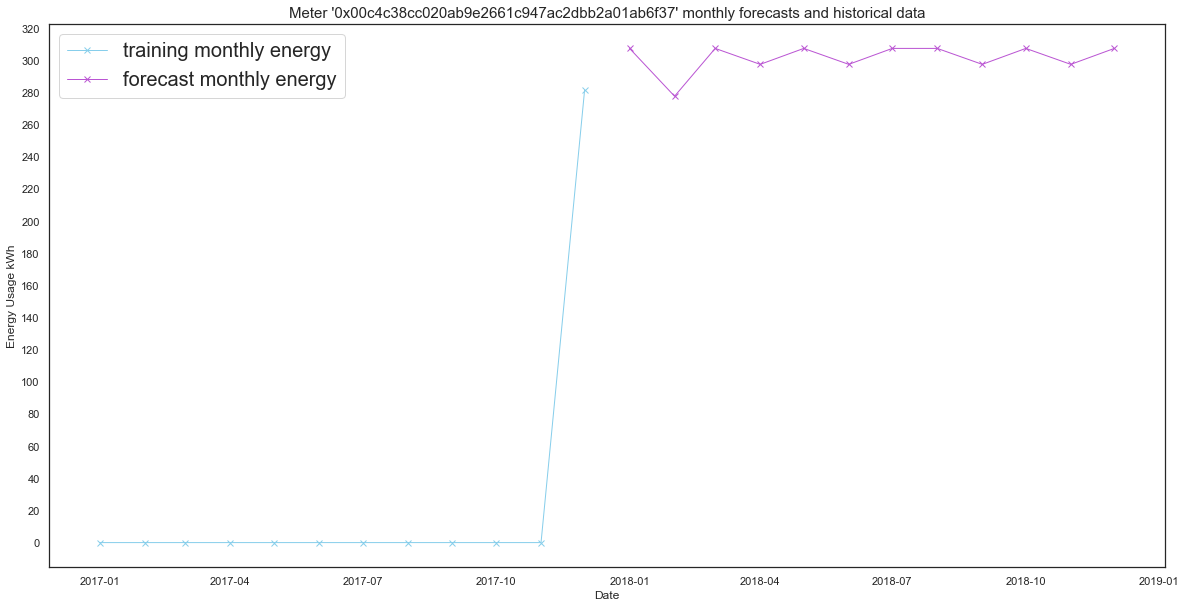

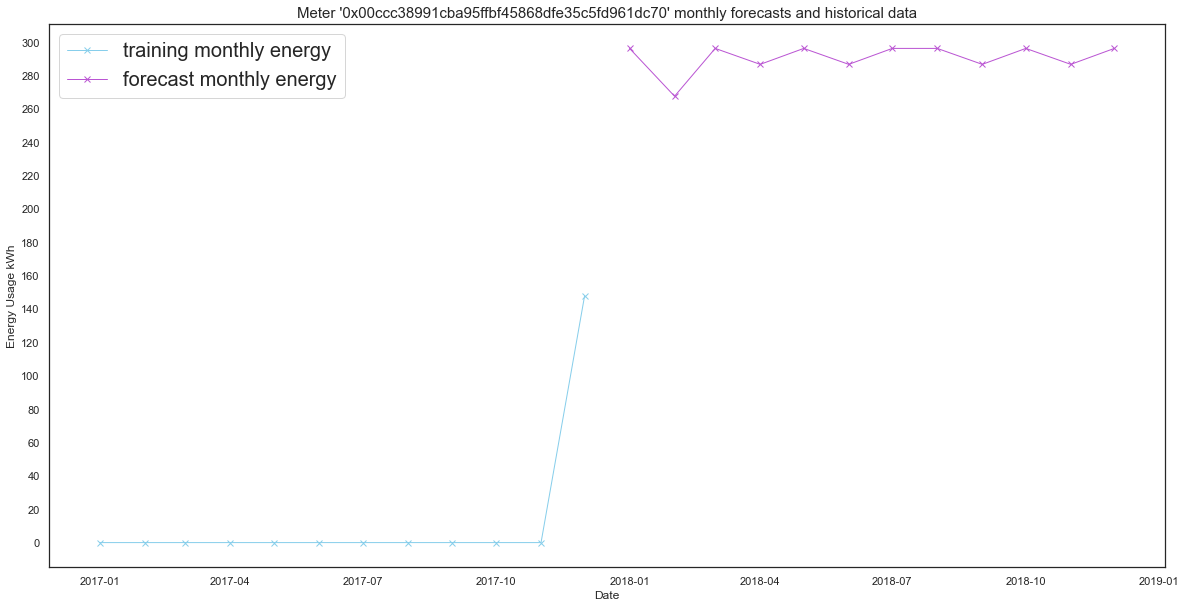

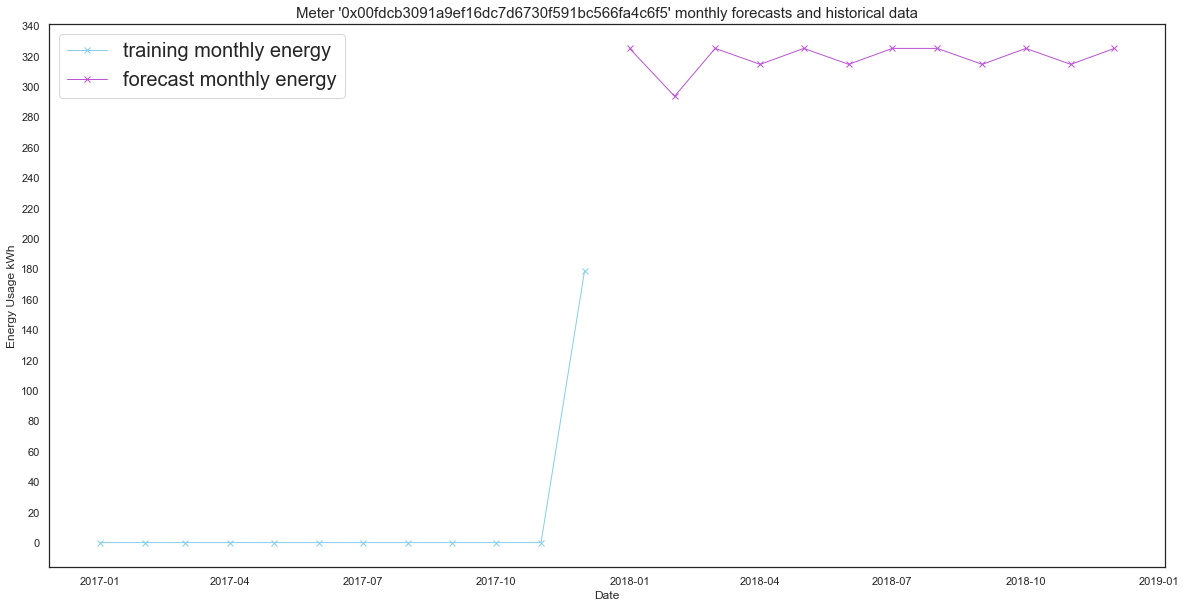

In [69]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\forecasts\\f{population_size}_i{number_of_iterations}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()

# Training a model based on the main effects
* Running on the hyper params determined by main effects (setting that gave the lowest mean result)

In [70]:
# treating columns like main effects: accepting those whose mean error with the column is better than that without the column
main_columm_types = []
i=0
for key in possible_columns.keys():
    print(key,column_means[i]<columnless_means[i])
    main_columm_types.append(key)
    i+=1 
print(main_columm_types)

meter_id_ord True
meter_id_binary True
day_of_year_cyclic True
day_of_week True
day_of_month True
month_ord True
month_cyclic True
is_weekend True
energy_cluster True
num_bedrooms True
dwelling_type_ord True
dwelling_type_onehot False
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']


In [71]:
#inspecting the stored best values for each hyper as determined by the main effects plot
#(value which resulted in the lowest average MAE on the val set)
print(arr_hypers)
print(arr_best_hypers) 

['learning_rate', 'num_leaves', 'max_depth', 'bagging_fraction', 'bagging_freq', 'feature_fraction', 'lambda_l1', 'lambda_l2']
[array([0.095]), array([1443.]), array([10.]), array([0.98]), array([6.]), array([0.95]), array([6.]), array([5.])]


In [72]:
start_time = time.time()
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Running with main effects determined configuration{color.END}")

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the features{color.END}")
X_cols =[]

for key in main_columm_types:
    X_cols+=(possible_columns[key])
this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
print(X_cols)

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the main effects hyper parameters{color.END}")
this_params = params.copy()
this_params["learning_rate"] = arr_best_hypers[0][0]
this_params["max_depth"] = int(arr_best_hypers[2][0])
this_params["num_leaves"] = int(arr_best_hypers[1][0])
this_params["bagging_fraction"] = arr_best_hypers[3][0]
this_params["bagging_freq"] = int(arr_best_hypers[4][0])
this_params["feature_fraction"] = arr_best_hypers[5][0]
this_params["lambda_l1"] = int(arr_best_hypers[6][0])
this_params["lambda_l2"] = int(arr_best_hypers[7][0])
pprint(this_params)

#train the model with this hyper param config and store it's results
results=((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Trained the model in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Running with main effects determined configuration
Using the features
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
Using the main effects hyper parameters
{'bagging_fraction': 0.98,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.95,
 'lambda_l1': 6,
 'lambda_l2': 5,
 'learning_rate': 0.095,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 1443,
 'num_threads': -1,
 'seed': 1337}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] lambda_l1 is set=

# Forecasting from the main effects model

In [73]:
#making predictions based on the best performing model and displaying it's information
main_effects_models = results[0][2] #getting the lgbm_models from the best index
main_effects_forecasts = df_preds.copy()

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(main_effects_models)):
    pred_forecasts = main_effects_models[i].predict(main_effects_forecasts[results[1][0]], num_iteration=main_effects_models[i].best_iteration_) #predicting the unkown df_preds
    main_effects_forecasts[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
main_effects_forecasts["meter_reading"] = main_effects_forecasts.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0

display(main_effects_forecasts)

meter_id meter_id_ord meter_id_0  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
...                                             ...          ...        ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   

        meter_id_1 meter_id_2 meter_id_3 meter_id_4 meter_id_5 meter_id_6  \
0                0          0          0          0          0          0   
1                0          0          0          0          0          0   
2                0          0          0          0          0          0   
3                0          0          0          0          0          0   
4                0          0          0          0          0          0   
...            ...        ...        ...        ...        ...        ...   
1185515          1          1          0          0          1          0   
1185516          1          1          0          0          1          0   
1185517          1          1          0          0          1          0   
1185518          1          1          0          0          1          0   
1185519          1          1          0          0          1          0   

        meter_id_7  ... is_weekend energy_cluster num_bedrooms  \
0                0  ...          0              0          2.0   
1                0  ...          0              0          2.0   
2                0  ...          0              0          2.0   
3                0  ...          0              0          2.0   
4                0  ...          0              0          2.0   
...            ...  ...        ...            ...          ...   
1185515          1  ...          0              1          3.0   
1185516          1  ...          0              1          3.0   
1185517          1  ...          1              1          3.0   
1185518          1  ...          1              1          3.0   
1185519          1  ...          0              1          3.0   

          dwelling_type dwelling_type_ord detached  flat  semi_detached  \
0        terraced_house                 4      0.0   0.0            0.0   
1        terraced_house                 4      0.0   0.0            0.0   
2        terraced_house                 4      0.0   0.0            0.0   
3        terraced_house                 4      0.0   0.0            0.0   
4        terraced_house                 4      0.0   0.0            0.0   
...                 ...               ...      ...   ...            ...   
1185515  detached_house                 1      1.0   0.0            0.0   
1185516  detached_house                 1      1.0   0.0            0.0   
1185517  detached_house                 1      1.0   0.0            0.0   
1185518  detached_house                 1      1.0   0.0            0.0   
1185519  detached_house                 1      1.0   0.0            0.0   

        terraced meter_reading  
0            1.0      9.329082  
1            1.0      9.329082  
2            1.0      9.329082  
3            1.0      9.329082  
4            1.0      9.329082  
...          ...           ...  
1185515      0.0      9.329082  
1185516      0.0      9.329082  
1185517      0.0      9.329082  
1185518      0.0      9.329082  
1185519      0.0      9.329082  

[1185520 rows x 33 columns]

# Comparing the val error of the main effects vs the best from Firefly algorithm tuning
## Firefly Algorithm summary

In [74]:
best_index

64

In [75]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}GA best model came from iteration {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {best_results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(best_results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(best_results[1][1])

GA best model came from iteration 5 individual 4
Evaluation and results
Mean absolute error between OOF preds and meter_reading on training set: 4.815153487535586

Hyper-parameters

X_cols:

['energy_cluster', 'dwelling_type_ord']
model params:  
{'bagging_fraction': 0.6615710343041316,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.872399423664597,
 'lambda_l1': 8,
 'lambda_l2': 5,
 'learning_rate': 0.08079147742821485,
 'max_depth': 9,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 784,
 'num_threads': -1,
 'seed': 1337}


## Main effects based model summary

In [76]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Main effects model based on results of GA{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(results[1][1])

Main effects model based on results of GA
Evaluation and results
Mean absolute error between OOF preds and meter_reading on training set: 4.853916261270321

Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'day_of_month',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'num_bedrooms',
 'dwelling_type_ord',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.98,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.95,
 'lambda_l1': 6,
 'lambda_l2': 5,
 'learning_rate': 0.095,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 1,
 'num_leaves': 1443,
 'num_threads': -1,
 'seed': 1337}


#### Conclusion:
the best model from the GA is way better than the main effects of the GA


# Save the main effects description

In [77]:
import pickle

a = {'hello': 'world'}
desc_disc = {
    "MAE":results[0][1],
    "features":results[1][0],
    "params":results[1][1]
}

with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 4.853916261270321,
 'features': ['meter_id_ord',
              'meter_id_0',
              'meter_id_1',
              'meter_id_2',
              'meter_id_3',
              'meter_id_4',
              'meter_id_5',
              'meter_id_6',
              'meter_id_7',
              'meter_id_8',
              'meter_id_9',
              'meter_id_10',
              'meter_id_11',
              'meter_id_12',
              'day_of_year_sin',
              'day_of_year_cos',
              'day_of_week',
              'day_of_month',
              'month_ord',
              'month_sin',
              'month_cos',
              'is_weekend',
              'energy_cluster',
              'num_bedrooms',
              'dwelling_type_ord',
              'detached',
              'flat',
              'semi_detached',
              'terraced'],
 'params': {'bagging_fraction': 0.98,
            'bagging_freq': 6,
            'boosting_type': 'gbdt',
            'feature_fraction': 0

# Formatting the main effects forecasts and saving them

# Converting into monthly forecasts

In [78]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = main_effects_forecasts.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

meter_id         Jan         Feb  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  289.201552  261.214305   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  289.201552  261.214305   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  289.201552  261.214305   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  289.201552  261.214305   
4     0x005958406351bb29580475df698b5f1070096397  289.201552  261.214305   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  289.201552  261.214305   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  289.201552  261.214305   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  289.201552  261.214305   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  289.201552  261.214305   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  289.201552  261.214305   

             Mar         Apr         May         Jun         Jul         Aug  \
0     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
1     289.201552  287.995007  296.808720  287.234245  296.808720  296.808720   
2     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
4     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
...          ...         ...         ...         ...         ...         ...   
3243  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3244  289.201552  307.333924  316.219783  303.987085  314.119988  315.263963   
3245  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3246  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3247  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   

             Sep         Oct        Nov         Dec  
0     272.840061  281.934729  279.87247  289.201552  
1     287.950256  298.195992  279.87247  289.201552  
2     272.840061  281.934729  279.87247  289.201552  
3     272.840061  281.934729  279.87247  289.201552  
4     272.840061  281.934729  279.87247  289.201552  
...          ...         ...        ...         ...  
3243  272.840061  281.934729  279.87247  289.201552  
3244  306.030532  316.231550  279.87247  289.201552  
3245  272.840061  281.934729  279.87247  289.201552  
3246  272.840061  281.934729  279.87247  289.201552  
3247  272.840061  281.934729  279.87247  289.201552  

[3248 rows x 13 columns]

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [79]:
df_monthly_forecasts.to_csv(f"..\\Results\\Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [80]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

meter_id     2018-01     2018-02  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  289.201552  261.214305   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  289.201552  261.214305   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  289.201552  261.214305   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  289.201552  261.214305   
4     0x005958406351bb29580475df698b5f1070096397  289.201552  261.214305   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  289.201552  261.214305   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  289.201552  261.214305   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  289.201552  261.214305   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  289.201552  261.214305   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  289.201552  261.214305   

         2018-03     2018-04     2018-05     2018-06     2018-07     2018-08  \
0     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
1     289.201552  287.995007  296.808720  287.234245  296.808720  296.808720   
2     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
4     289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
...          ...         ...         ...         ...         ...         ...   
3243  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3244  289.201552  307.333924  316.219783  303.987085  314.119988  315.263963   
3245  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3246  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   
3247  289.201552  272.840061  281.934729  272.840061  281.934729  281.934729   

         2018-09     2018-10    2018-11     2018-12  
0     272.840061  281.934729  279.87247  289.201552  
1     287.950256  298.195992  279.87247  289.201552  
2     272.840061  281.934729  279.87247  289.201552  
3     272.840061  281.934729  279.87247  289.201552  
4     272.840061  281.934729  279.87247  289.201552  
...          ...         ...        ...         ...  
3243  272.840061  281.934729  279.87247  289.201552  
3244  306.030532  316.231550  279.87247  289.201552  
3245  272.840061  281.934729  279.87247  289.201552  
3246  272.840061  281.934729  279.87247  289.201552  
3247  272.840061  281.934729  279.87247  289.201552  

[3248 rows x 13 columns]

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [81]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = main_effects_forecasts.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

meter_id  2018-01-01 00:00:00  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c             9.329082   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82             9.329082   
2     0x0019979ee12c59accd24d1c83291528ced1bb734             9.329082   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a             9.329082   
4     0x005958406351bb29580475df698b5f1070096397             9.329082   
...                                          ...                  ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f             9.329082   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb             9.329082   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5             9.329082   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02             9.329082   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4             9.329082   

      2018-01-02 00:00:00  2018-01-03 00:00:00  2018-01-04 00:00:00  \
0                9.329082             9.329082             9.329082   
1                9.329082             9.329082             9.329082   
2                9.329082             9.329082             9.329082   
3                9.329082             9.329082             9.329082   
4                9.329082             9.329082             9.329082   
...                   ...                  ...                  ...   
3243             9.329082             9.329082             9.329082   
3244             9.329082             9.329082             9.329082   
3245             9.329082             9.329082             9.329082   
3246             9.329082             9.329082             9.329082   
3247             9.329082             9.329082             9.329082   

      2018-01-05 00:00:00  2018-01-06 00:00:00  2018-01-07 00:00:00  \
0                9.329082             9.329082             9.329082   
1                9.329082             9.329082             9.329082   
2                9.329082             9.329082             9.329082   
3                9.329082             9.329082             9.329082   
4                9.329082             9.329082             9.329082   
...                   ...                  ...                  ...   
3243             9.329082             9.329082             9.329082   
3244             9.329082             9.329082             9.329082   
3245             9.329082             9.329082             9.329082   
3246             9.329082             9.329082             9.329082   
3247             9.329082             9.329082             9.329082   

      2018-01-08 00:00:00  2018-01-09 00:00:00  ...  2018-12-22 00:00:00  \
0                9.329082             9.329082  ...             9.329082   
1                9.329082             9.329082  ...             9.329082   
2                9.329082             9.329082  ...             9.329082   
3                9.329082             9.329082  ...             9.329082   
4                9.329082             9.329082  ...             9.329082   
...                   ...                  ...  ...                  ...   
3243             9.329082             9.329082  ...             9.329082   
3244             9.329082             9.329082  ...             9.329082   
3245             9.329082             9.329082  ...             9.329082   
3246             9.329082             9.329082  ...             9.329082   
3247             9.329082             9.329082  ...             9.329082   

      2018-12-23 00:00:00  2018-12-24 00:00:00  2018-12-25 00:00:00  \
0                9.329082             9.329082             9.329082   
1                9.329082             9.329082             9.329082   
2                9.329082             9.329082             9.329082   
3                9.329082             9.329082             9.329082   
4                9.329082             9.329082             9.329082   
...                   ...                  ...                  ...   
3243             9.329082             9.329082 

## loading training data and aggregating into months

In [82]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

training data


  0%|          | 0/12 [00:00<?, ?it/s]

meter_id  2017-01-01  2017-01-02  \
0     0xa62b9f23553ff183f61e2bf943aab3d5983d02d7       0.000       0.000   
1     0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da       0.000       0.000   
2     0x4a1ed36825360a058cec2bdd409fc2459e1ce54f       0.000       0.000   
3     0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407       0.000       0.000   
4     0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f       0.000       0.000   
...                                          ...         ...         ...   
3243  0x7dd7a7b8ee1bec7c44b24f738c752482f6161065       2.317       2.301   
3244  0xfdaf9f857621ec06f2cf801f42a020a322835090      14.437      16.274   
3245  0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18       7.824       7.517   
3246  0x47218b46abb2fcaade487a211911406dc6e13730      23.965      28.689   
3247  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd      11.302      14.178   

      2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
0          0.000       0.000       0.000       0.000       0.000       0.000   
1          0.000       0.000       0.000       0.000       0.000       0.000   
2          0.000       0.000       0.000       0.000       0.000       0.000   
3          0.000       0.000       0.000       0.000       0.000       0.000   
4          0.000       0.000       0.000       0.000       0.000       0.000   
...          ...         ...         ...         ...         ...         ...   
3243       2.352       2.516       2.229       2.354       2.397       2.397   
3244       7.031      17.018      17.603      15.005       8.987       8.490   
3245       5.398       6.788       7.360       6.898       7.321       8.042   
3246      27.664      29.229      29.548      27.909      26.923      21.277   
3247      15.499      11.853      17.431      14.506      12.812      10.472   

      2017-01-09  ...  2017-12-22  2017-12-23  2017-12-24  2017-12-25  \
0          0.000  ...       4.030       5.397      5.1075       4.818   
1          0.000  ...      13.101      14.327     14.6315      14.936   
2          0.000  ...      10.201       7.320      7.3520       7.384   
3          0.000  ...      14.833      12.477     11.7255      10.974   
4          0.000  ...      39.440      35.538     21.9445       8.351   
...          ...  ...         ...         ...         ...         ...   
3243       2.269  ...       9.390       9.231      9.2235       9.216   
3244      10.136  ...       4.141       2.828      3.8230       4.818   
3245       8.207  ...       6.767       5.919      5.9980       6.077   
3246      23.452  ...      20.747      19.979     20.1925      20.406   
3247      10.879  ...      14.036      15.990     15.5505      15.111   

      2017-12-26  2017-12-27  2017-12-28  2017-12-29  2017-12-30  2017-12-31  
0          3.931      4.2170       4.503      4.8160       5.129       5.395  
1         16.174     20.3960      24.618     19.8925      15.167      11.751  
2         14.425     16.0650      17.705     13.3355       8.966       4.633  
3         19.646     21.8195      23.993     19.9170      15.841      14.452  
4          9.957     17.9140      25.871     36.0725      46.274      16.901  
...          ...         ...         ...         ...         ...         ...  
3243       9.336      9.6840      10.032      9.8945       9.757       9.480  
3244       3.357      8.1315      12.906      8.0140       3.122       3.401  
3245       7.761      6.6080       5.455      5.5670       5.679       8.148  
3246      23.668     27.7900      31.912     29.1125      26.313      24.201  
3247      16.506     18.7585      21.011     19.2040      17.397      15.237  

[3248 rows x 366 columns]

meter_id   2017-01  2017-02   2017-03  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c    0.0000    0.000    0.0000   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82    0.0000    0.000    0.0000   
2     0x0019979ee12c59accd24d1c83291528ced1bb734    0.0000    0.000    0.0000   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a    0.0000    0.000    0.0000   
4     0x005958406351bb29580475df698b5f1070096397    0.0000    0.000    0.0000   
...                                          ...       ...      ...       ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f   72.7050   63.245   68.4335   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  371.4390  269.691  179.3430   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  209.8065  169.858  184.0130   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  845.6630  608.449  588.7765   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  428.7345  670.505  462.1050   

       2017-04   2017-05  2017-06   2017-07   2017-08   2017-09     2017-10  \
0       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
1       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
2       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
3       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
4       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
...        ...       ...      ...       ...       ...       ...         ...   
3243   66.6265   69.0480  100.430  177.1735  177.4100  216.7245  279.164500   
3244  141.6590  138.4835  122.910  164.2285  100.9610  118.0520  123.135500   
3245  166.7280  134.1760  169.489  157.5775  165.9640  177.0105  185.701833   
3246  503.3050  291.1320  177.605  183.5345  182.0350  244.2255  371.458333   
3247  354.8660  287.9950  200.321  227.0855  231.7585  246.3005  344.210167   

         2017-11    2017-12  
0       0.000000  128.39450  
1       0.000000  553.18400  
2       0.000000  368.90957  
3       0.000000  534.84650  
4       0.000000  946.06400  
...          ...        ...  
3243  351.481000  312.08800  
3244  187.140000  186.88400  
3245  192.288667  200.61950  
3246  695.878667  858.83950  
3247  516.290333  734.61800  

[3248 rows x 13 columns]

## Plotting the predictions against the training data

  0%|          | 0/3248 [00:00<?, ?it/s]

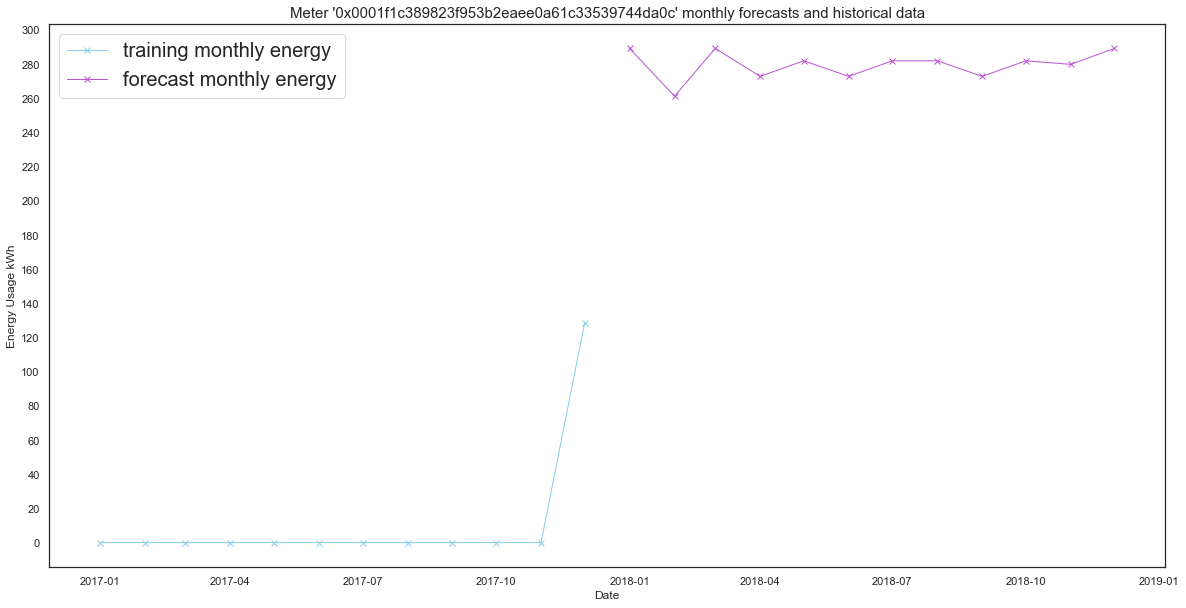

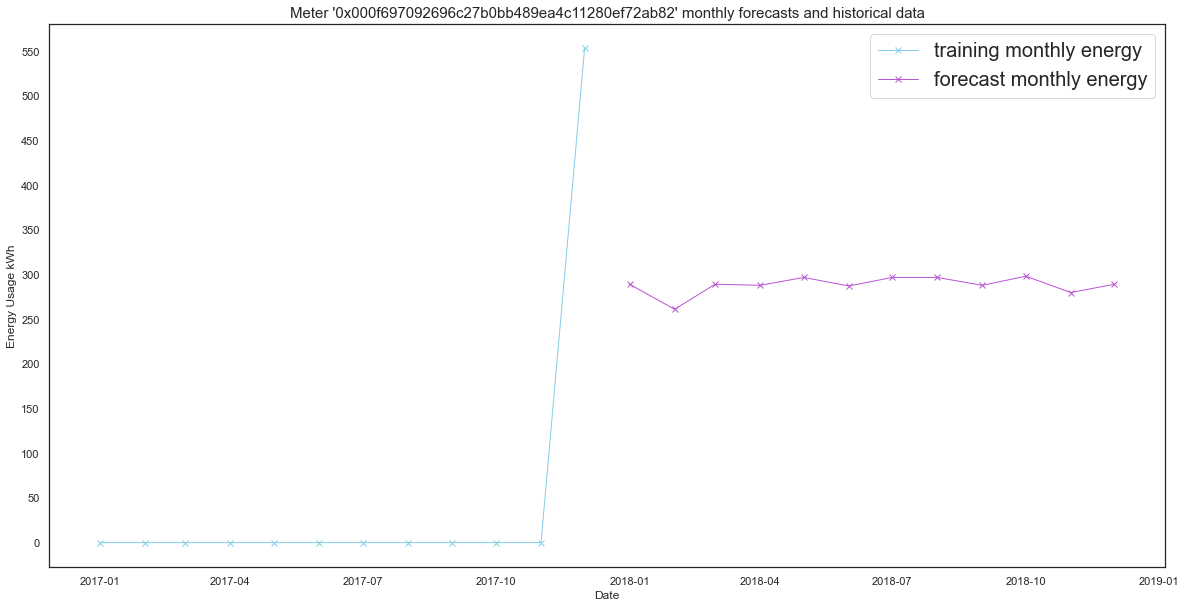

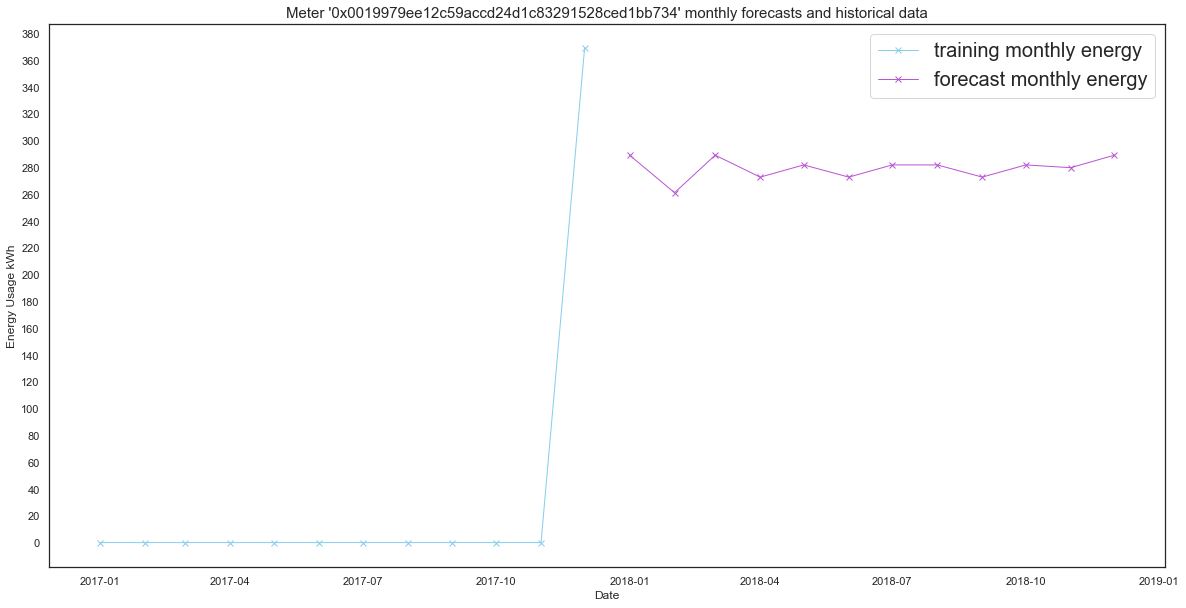

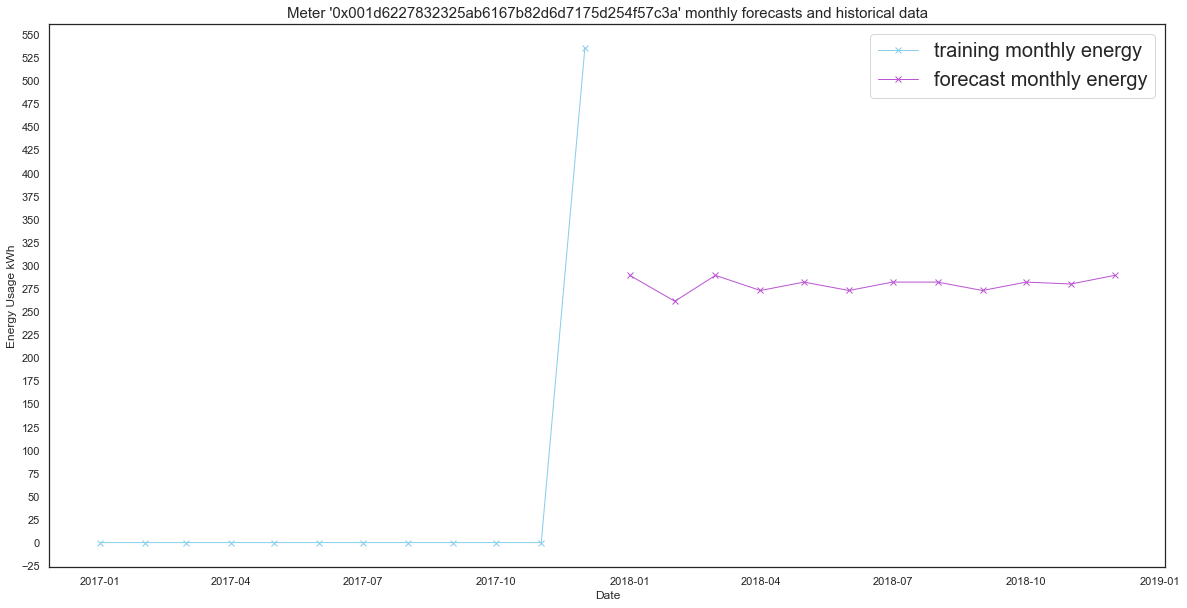

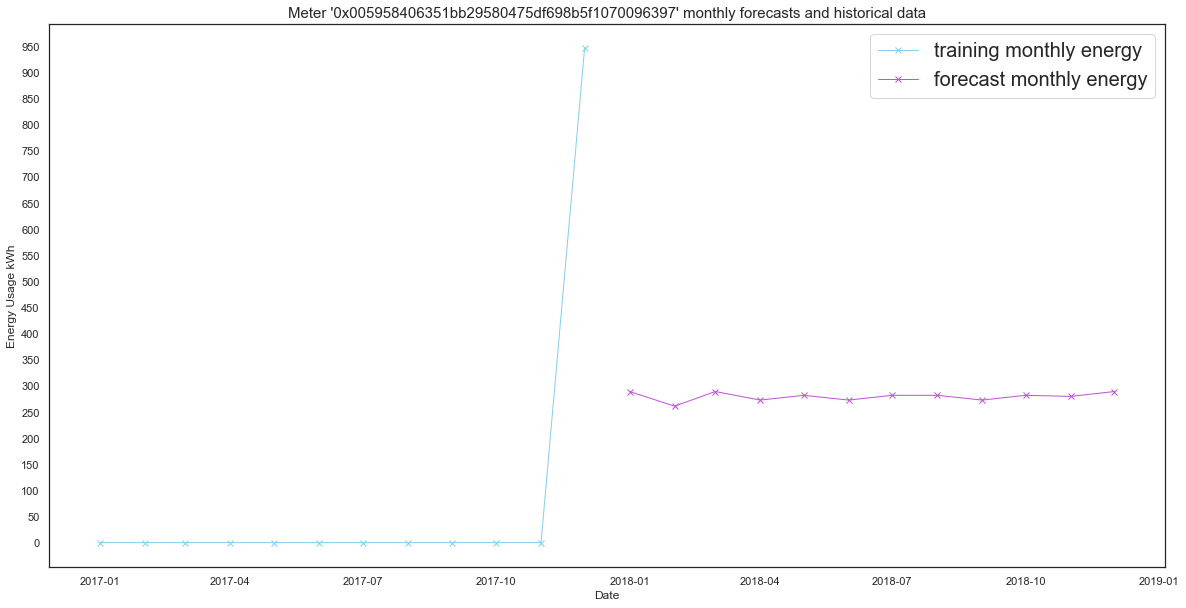

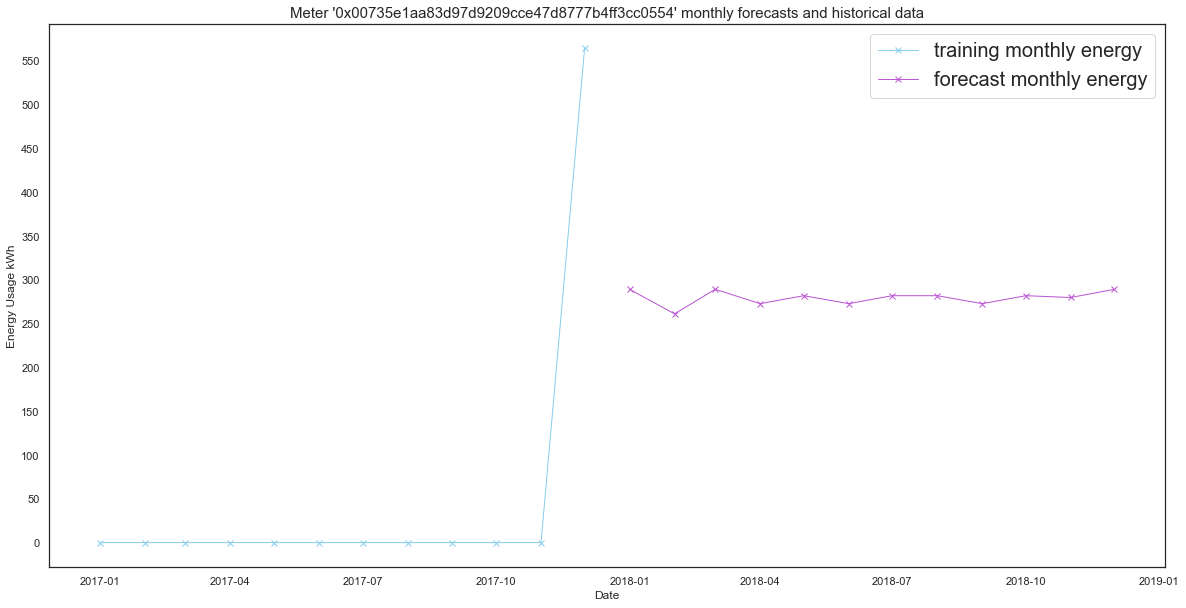

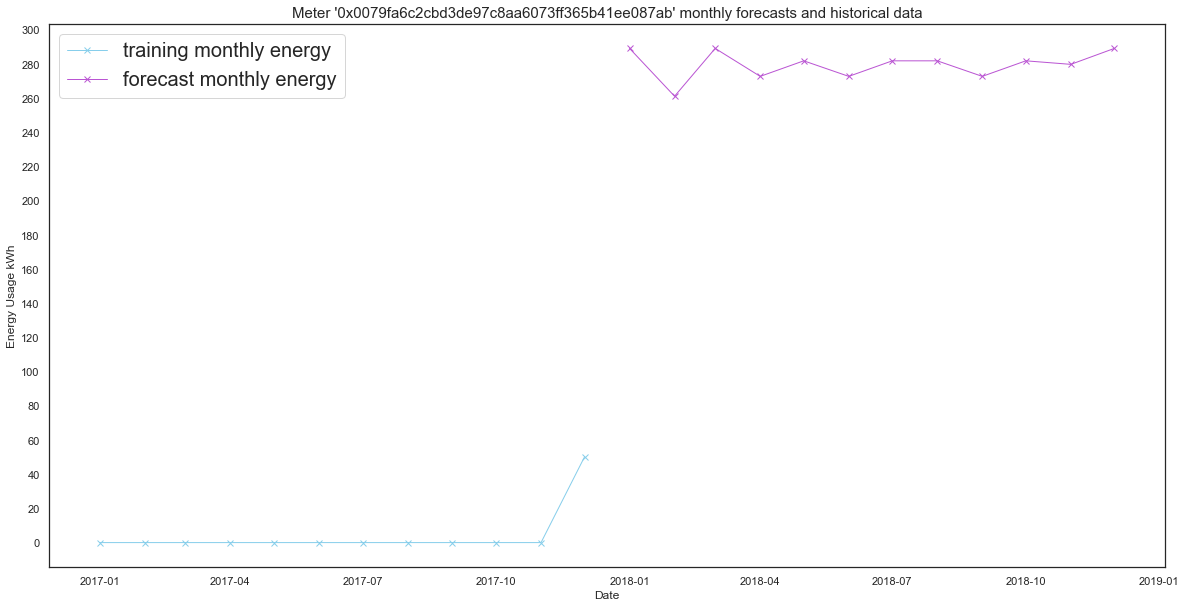

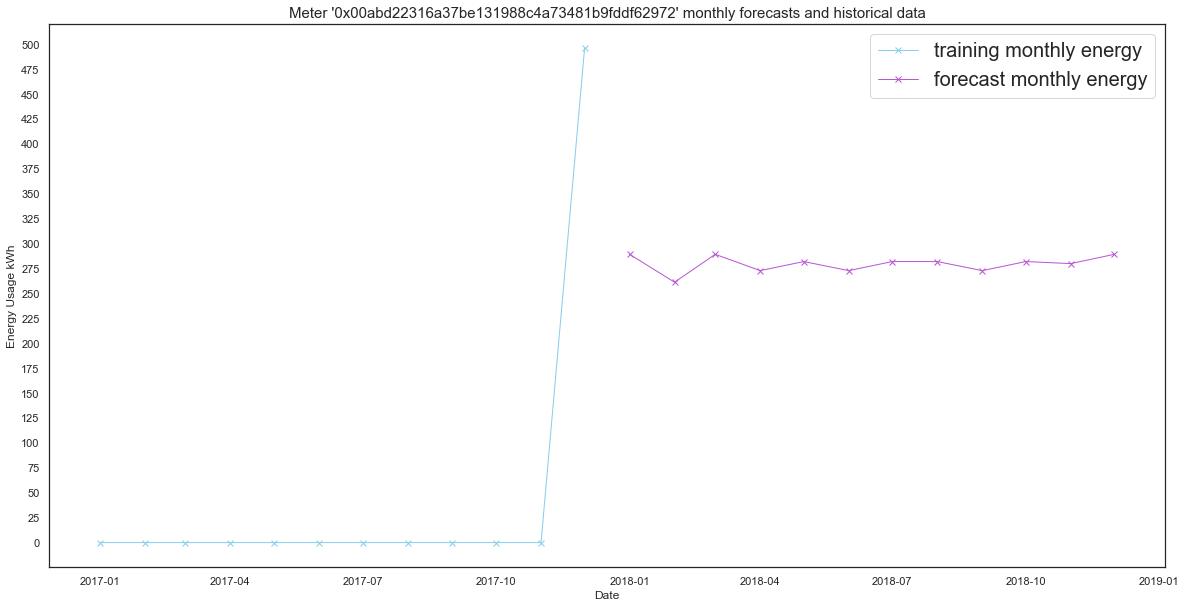

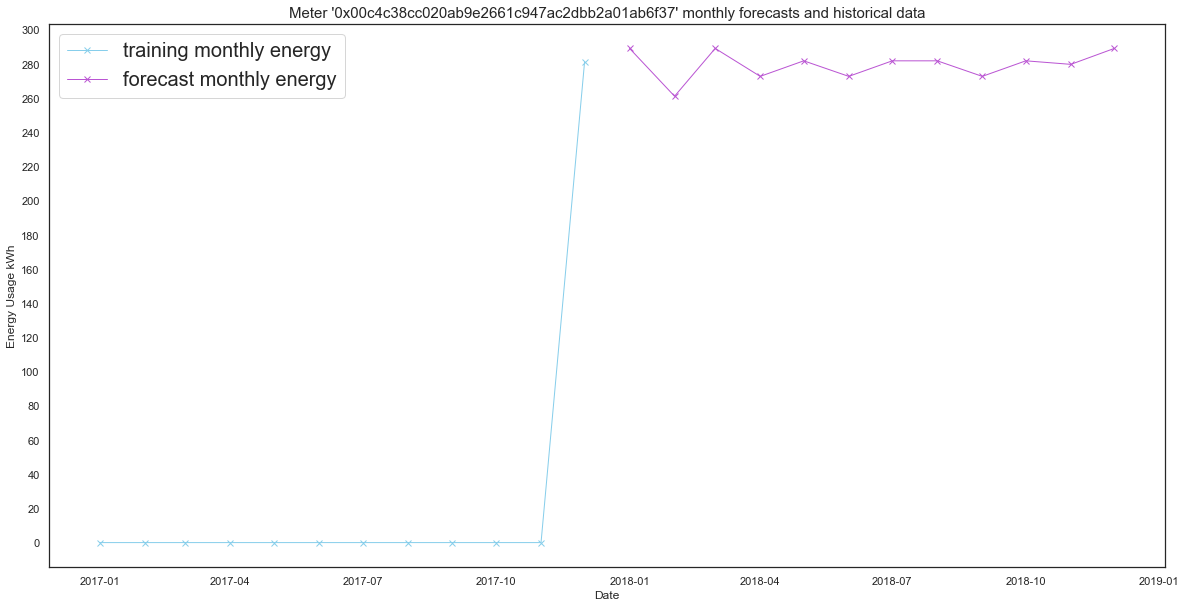

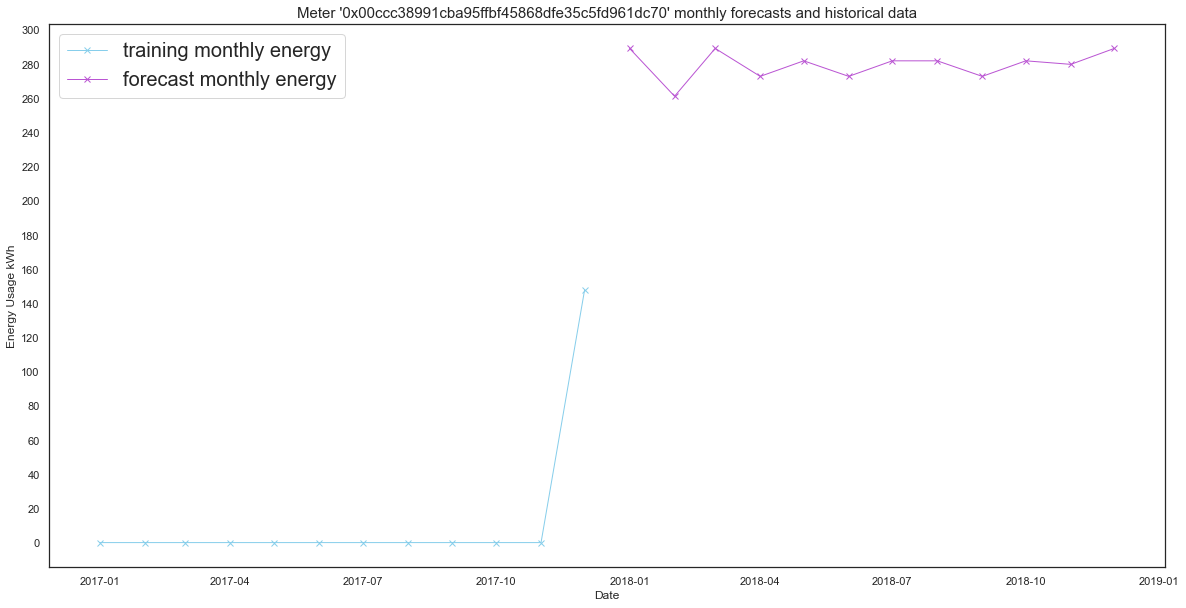

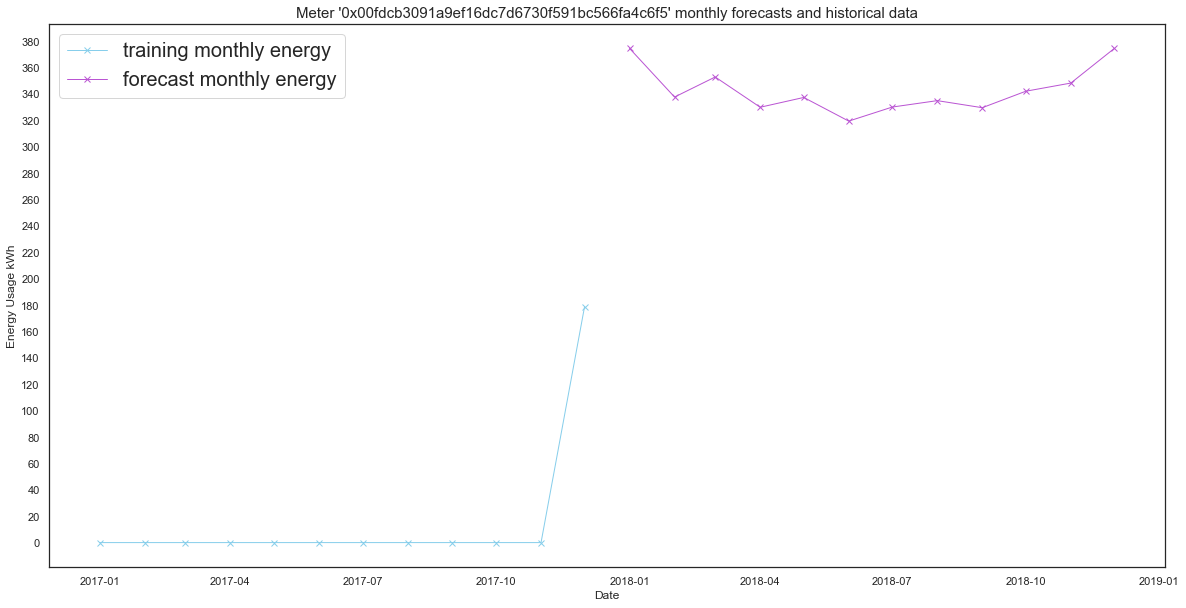

In [83]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Firefly Algorithm\\Plots\\forecasts\\main_effects\\f{population_size}_i{number_of_iterations}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()